# Yolov3 Object Detection

## 设置数据集

请将数据集压缩包上传到Image文件夹下，上传完成后执行下面的代码解压文件。
确保解压后的Image目录下的结构如下：
|Image

|—VOCdevkit

|——VOC

|————Annotations

        └─  *.xml # 存放图片的类别与边框

|————JPEGImages

        └─ *.jpg # 存放图片

|————ImageSets

|——————Main

            └─ *.txt # 存放训练集、验证集所用图片名称，包括train.txt,val.txt其中包含了图片的文件名

In [1]:
#unzip *.zip
import os
os.chdir('Image')
#下一行为下载测试用数据集
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#解压数据集
!tar xf VOCtrainval_06-Nov-2007.tar
!ls

--2018-07-08 13:54:02--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com... 128.208.3.39
Connecting to pjreddie.com|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  38.4MB/s    in 12s     

2018-07-08 13:54:14 (36.6 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

VOCdevkit  VOCtrainval_06-Nov-2007.tar


In [2]:
!pwd

/home/jxm/msfthack/Image


## 标签格式转换

执行如下代码，将会在VOC目录下产生`train.txt`和`val.txt`文件，其中内容为图片的绝对路径。

In [3]:
import xml.etree.ElementTree as ET
import pickle
import os
from os import listdir, getcwd
from os.path import join
#请在下一行进行修改
sets=[('2007', 'train'), ('2007', 'val')]
#请在下一行进行修改
classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(year, image_id):
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    out_file = open('VOCdevkit/VOC%s/labels/%s.txt'%(year, image_id), 'w')
    tree=ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text))
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

wd = getcwd()

for year, image_set in sets:
    if not os.path.exists('VOCdevkit/VOC%s/labels/'%(year)):
        os.makedirs('VOCdevkit/VOC%s/labels/'%(year))
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg\n'%(wd, year, image_id))
        convert_annotation(year, image_id)
    list_file.close()

In [4]:
!ls

2007_train.txt	2007_val.txt  VOCdevkit  VOCtrainval_06-Nov-2007.tar


## 基础参数设置

数据集信息配置

In [19]:
#cfg/voc.data
#请修改下面三行
classes= 20
train  = '/home/jxm/msfthack/Image/2007_train.txt'
valid  = '/home/jxm/msfthack/Image/2007_val.txt'
names = 'data/voc.names'
backup = 'backup'
vocdata=['classes = '+ str(classes), 'train = '+ train, 'valid = '+ valid, 'names = '+ names, 'backup = '+backup]

In [6]:
vocdata

['classes = 20',
 'train = /home/jxm/msfthack/Image/2007_train.txt',
 'valid = /home/jxm/msfthack/Image/2007_val.txt',
 'names = data/voc.names',
 'backup = backup']

In [13]:
filepath = '/home/jxm/msfthack/darknet/cfg/voc.data'
with open(filepath,'r') as f:
    lines = f.readlines()
lines

['classes = 20\n',
 'train = /home/jxm/msfthack/Image/2007_train.txt\n',
 'valid = /home/jxm/msfthack/Image/2007_val.txt\n',
 'names = data/voc.names\n',
 'backup = backup\n']

In [12]:
for i in range(len(vocdata)):
    vocdata[i] = vocdata[i] +'\n'
with open(filepath,'w') as f:
    f.writelines(vocdata)

数据集类别名称设置

**请修改为实际类别名称**

In [14]:
classnames =  ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

In [16]:
filepath = '/home/jxm/msfthack/darknet/data/voc.names'
with open(filepath,'w') as f:
    for item in classnames:
        f.write(item+'\n')

## 训练参数设置

请在训练时将batch和subdivisions设置成不为1的值，测试时使两个值均为1

In [50]:
#请修改下面两行
batch = 64
subdivisions = 16
filters = (classes + 5) * 3

In [52]:
filepath = '/home/jxm/msfthack/darknet/cfg/yolov3-voc.cfg'
with open(filepath,'r') as f:
    lines = f.readlines()
lines

['[net]\n',
 '# Testing\n',
 'batch=1\n',
 'subdivisions=1\n',
 '# Training\n',
 '# batch=64\n',
 '# subdivisions=16\n',
 'width=416\n',
 'height=416\n',
 'channels=3\n',
 'momentum=0.9\n',
 'decay=0.0005\n',
 'angle=0\n',
 'saturation = 1.5\n',
 'exposure = 1.5\n',
 'hue=.1\n',
 '\n',
 'learning_rate=0.001\n',
 'burn_in=1000\n',
 'max_batches = 50200\n',
 'policy=steps\n',
 'steps=40000,45000\n',
 'scales=.1,.1\n',
 '\n',
 '\n',
 '\n',
 '[convolutional]\n',
 'batch_normalize=1\n',
 'filters=32\n',
 'size=3\n',
 'stride=1\n',
 'pad=1\n',
 'activation=leaky\n',
 '\n',
 '# Downsample\n',
 '\n',
 '[convolutional]\n',
 'batch_normalize=1\n',
 'filters=64\n',
 'size=3\n',
 'stride=2\n',
 'pad=1\n',
 'activation=leaky\n',
 '\n',
 '[convolutional]\n',
 'batch_normalize=1\n',
 'filters=32\n',
 'size=1\n',
 'stride=1\n',
 'pad=1\n',
 'activation=leaky\n',
 '\n',
 '[convolutional]\n',
 'batch_normalize=1\n',
 'filters=64\n',
 'size=3\n',
 'stride=1\n',
 'pad=1\n',
 'activation=leaky\n',
 '\n',
 

In [51]:
filepath = '/home/jxm/msfthack/darknet/cfg/yolov3-voc.cfg'
lines = []
with open(filepath,'r') as f:
    lines = f.readlines()
    
if batch != 1 and subdivisions != 1:
    lines[2] = '# batch=1\n'
    lines[3] = '# subdivisions=1\n'
    lines[5] = 'batch=' + str(batch) +'\n'
    lines[6] = 'subdivisions=' + str(subdivisions) +'\n'
else:
    lines[2] = 'batch=1\n'
    lines[3] = 'subdivisions=1\n'
    lines[5] = '# '+ lines[5]
    lines[6] = '# '+ lines[6]
for i in range(len(lines)):
    if lines[i] == '[yolo]\n':
        lines[i-3] = 'filters='+ str(filters) + '\n'
        lines[i+3] = 'classes='+ str(classes) + '\n'
        
with open(filepath,'w') as f:
    f.writelines(lines)

## 开始训练

下载预训练模型

In [26]:
os.chdir('/home/jxm/msfthack/darknet')

In [27]:
!wget https://pjreddie.com/media/files/darknet53.conv.74

--2018-07-08 14:03:22--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com... 128.208.3.39
Connecting to pjreddie.com|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  38.5MB/s    in 4.5s    

2018-07-08 14:03:27 (34.7 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



下面开始训练命令，这一过程时间较长，请观察输出的损失值，在0.0x时可手动终止。开始时损失值较大，后面会收敛到比较小的值。

如果有多个GPU,请修改gpus参数，例如 -gpus 0,1,2,3

In [ ]:
!./darknet detector train cfg/voc.data cfg/yolov3-voc.cfg darknet53.conv.74 -gpus 0

0
yolov3-voc
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.

Region 106 Avg IOU: 0.298239, Class: 0.527657, Obj: 0.373670, No Obj: 0.505462, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.437243, Class: 0.580653, Obj: 0.438717, No Obj: 0.467661, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.340146, Class: 0.518290, Obj: 0.512173, No Obj: 0.554091, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505300, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.481232, Class: 0.346677, Obj: 0.346684, No Obj: 0.468699, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.392469, Class: 0.430889, Obj: 0.534714, No Obj: 0.553918, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.272232, Class: 0.621616, Obj: 0.599954, No Obj: 0.505222, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 82 Avg IOU: 0.317495, Class: 0.460997, Obj: 0.496942, No Obj: 0.468688, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.242145, Class: 0.458961, Obj: 0.4825

Region 82 Avg IOU: 0.574300, Class: 0.413291, Obj: 0.372668, No Obj: 0.467915, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.435711, Class: 0.427164, Obj: 0.453198, No Obj: 0.554754, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505754, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.384544, Class: 0.575847, Obj: 0.447956, No Obj: 0.468225, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.320841, Class: 0.513805, Obj: 0.579957, No Obj: 0.554542, .5R: 0.142857, .75R: 0.000000,  count: 14
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505732, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.372179, Class: 0.489658, Obj: 0.300982, No Obj: 0.468565, .5R: 0.400000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.347917, Class: 0.500732, Obj: 0.664355, No Obj: 0.554475, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.330603, Class: 0.693990, Obj: 0.510343, No Obj: 0.5054

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505591, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.380600, Class: 0.479342, Obj: 0.470933, No Obj: 0.468917, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.493159, Class: 0.338615, Obj: 0.575152, No Obj: 0.553794, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.410616, Class: 0.692639, Obj: 0.202723, No Obj: 0.505396, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.495779, Class: 0.461621, Obj: 0.415132, No Obj: 0.468481, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.420966, Class: 0.581820, Obj: 0.465232, No Obj: 0.554569, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.506073, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.265673, Class: 0.526931, Obj: 0.373797, No Obj: 0.468954, .5R: 0.111111, .75R: 0.000000,  count: 9
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554381, .5R: -nan,

Region 82 Avg IOU: 0.449228, Class: 0.521830, Obj: 0.459824, No Obj: 0.467726, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.262739, Class: 0.448569, Obj: 0.469183, No Obj: 0.555070, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.061781, Class: 0.511442, Obj: 0.396136, No Obj: 0.505445, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.126722, Class: 0.506958, Obj: 0.287445, No Obj: 0.469382, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.319961, Class: 0.381346, Obj: 0.477201, No Obj: 0.553337, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505722, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.406297, Class: 0.473602, Obj: 0.408311, No Obj: 0.468812, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.360085, Class: 0.395596, Obj: 0.585702, No Obj: 0.554205, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.410028, Class: 0.349931, Obj: 0.446626, No Obj: 0.467794, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.392772, Class: 0.806987, Obj: 0.686918, No Obj: 0.554969, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505476, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.431873, Class: 0.507215, Obj: 0.379201, No Obj: 0.469468, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.265163, Class: 0.585926, Obj: 0.634212, No Obj: 0.553749, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505550, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.358381, Class: 0.411979, Obj: 0.435440, No Obj: 0.467871, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.220931, Class: 0.628145, Obj: 0.577363, No Obj: 0.554670, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505739, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505778, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.363915, Class: 0.523110, Obj: 0.430557, No Obj: 0.468768, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.158615, Class: 0.674917, Obj: 0.588518, No Obj: 0.554883, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.131167, Class: 0.413556, Obj: 0.438867, No Obj: 0.505884, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.441715, Class: 0.464395, Obj: 0.500945, No Obj: 0.467664, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.377773, Class: 0.522972, Obj: 0.590910, No Obj: 0.554736, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505583, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.266691, Class: 0.490220, Obj: 0.501352, No Obj: 0.467926, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.123538, Class: 0.264494, Obj: 0.668596, No Obj: 0.554457

Region 82 Avg IOU: 0.360529, Class: 0.404387, Obj: 0.374792, No Obj: 0.468628, .5R: 0.142857, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.348038, Class: 0.508172, Obj: 0.547698, No Obj: 0.554560, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505513, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.339425, Class: 0.428579, Obj: 0.408029, No Obj: 0.468453, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.348422, Class: 0.491032, Obj: 0.619301, No Obj: 0.554495, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505564, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.467411, Class: 0.429483, Obj: 0.367306, No Obj: 0.468616, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554906, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.295990, Class: 0.573452, Obj: 0.657403, No Obj: 0.505320, .5R: 0.000000, .75

Region 82 Avg IOU: 0.424310, Class: 0.347361, Obj: 0.379315, No Obj: 0.468996, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.378937, Class: 0.411622, Obj: 0.553659, No Obj: 0.554875, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.103011, Class: 0.388254, Obj: 0.294462, No Obj: 0.505839, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.430873, Class: 0.570707, Obj: 0.405391, No Obj: 0.468994, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.295837, Class: 0.519058, Obj: 0.545771, No Obj: 0.554660, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.506084, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.365199, Class: 0.439187, Obj: 0.410295, No Obj: 0.468665, .5R: 0.250000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554859, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505473, .5R: -nan,

Region 106 Avg IOU: 0.035144, Class: 0.537948, Obj: 0.500413, No Obj: 0.505603, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.386416, Class: 0.459949, Obj: 0.435622, No Obj: 0.468091, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.173440, Class: 0.515640, Obj: 0.531939, No Obj: 0.554825, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505615, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.398373, Class: 0.491658, Obj: 0.509797, No Obj: 0.468305, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.249829, Class: 0.465878, Obj: 0.519186, No Obj: 0.554900, .5R: 0.000000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.546672, Class: 0.431264, Obj: 0.457182, No Obj: 0.505894, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.308830, Class: 0.424981, Obj: 0.383399, No Obj: 0.467419, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.297024, Class: 0.490882, Obj: 0.594

Region 94 Avg IOU: 0.221478, Class: 0.541588, Obj: 0.471457, No Obj: 0.555201, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.121156, Class: 0.293752, Obj: 0.508685, No Obj: 0.505396, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.511479, Class: 0.528256, Obj: 0.367191, No Obj: 0.468324, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.157186, Class: 0.486807, Obj: 0.440977, No Obj: 0.554909, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505573, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.476997, Class: 0.501168, Obj: 0.365065, No Obj: 0.468164, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.318733, Class: 0.511600, Obj: 0.547768, No Obj: 0.554610, .5R: 0.000000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.266199, Class: 0.464524, Obj: 0.629049, No Obj: 0.505677, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.315920, Class: 0.634296, Obj: 0.3989

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505726, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.408780, Class: 0.436685, Obj: 0.489897, No Obj: 0.468231, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.359859, Class: 0.564689, Obj: 0.540773, No Obj: 0.554959, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505680, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.384770, Class: 0.469018, Obj: 0.497826, No Obj: 0.467784, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554953, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505621, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.367414, Class: 0.471181, Obj: 0.516030, No Obj: 0.468485, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.316401, Class: 0.187428, Obj: 0.597838, No Obj: 0.554228, .5R: 0.000000, .75R: 0.000000,  count:

Region 94 Avg IOU: 0.140877, Class: 0.321745, Obj: 0.310999, No Obj: 0.554657, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505620, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.465874, Class: 0.394666, Obj: 0.560145, No Obj: 0.467232, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.318507, Class: 0.543167, Obj: 0.683400, No Obj: 0.554799, .5R: 0.111111, .75R: 0.000000,  count: 9
Region 106 Avg IOU: 0.292506, Class: 0.658682, Obj: 0.527183, No Obj: 0.505462, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.459995, Class: 0.434183, Obj: 0.457123, No Obj: 0.467508, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.413449, Class: 0.556891, Obj: 0.591310, No Obj: 0.554310, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.328031, Class: 0.525296, Obj: 0.557890, No Obj: 0.505844, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.288768, Class: 0.460178, Obj: 0.4543


 18: 847.697754, 977.991455 avg loss, 0.000000 rate, 10.629892 seconds, 1152 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: 0.462728, Class: 0.504470, Obj: 0.371733, No Obj: 0.467238, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.349898, Class: 0.573429, Obj: 0.678793, No Obj: 0.554755, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.298706, Class: 0.554238, Obj: 0.520560, No Obj: 0.505825, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.269959, Class: 0.476662, Obj: 0.292505, No Obj: 0.467582, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.304731, Class: 0.487714, Obj: 0.558792, No Obj: 0.554613, .5R: 0.153846, .75R: 0.000000,  count: 13
Region 106 Avg IOU: 0.177905, Class: 0.500135, Obj: 0.417364, No Obj: 0.505626, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.414501, Class: 0.486326, Obj: 0.468703, No Obj: 0.468589, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.365343, Class: 0.520212, O

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505505, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.277542, Class: 0.578721, Obj: 0.387431, No Obj: 0.468613, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.195675, Class: 0.331966, Obj: 0.739966, No Obj: 0.554475, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.504870, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.404903, Class: 0.375276, Obj: 0.363184, No Obj: 0.468416, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.188284, Class: 0.526228, Obj: 0.718032, No Obj: 0.554430, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.360385, Class: 0.664815, Obj: 0.407923, No Obj: 0.505473, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.495097, Class: 0.370382, Obj: 0.425922, No Obj: 0.468618, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554100, .5R: -nan,

Region 82 Avg IOU: 0.434340, Class: 0.480981, Obj: 0.483303, No Obj: 0.467093, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.135347, Class: 0.446636, Obj: 0.482847, No Obj: 0.555033, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505010, .5R: -nan, .75R: -nan,  count: 0

 21: 712.177429, 928.920532 avg loss, 0.000000 rate, 8.833424 seconds, 1344 images
Loaded: 0.000145 seconds
Region 82 Avg IOU: 0.307779, Class: 0.501119, Obj: 0.465404, No Obj: 0.467817, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.402850, Class: 0.641296, Obj: 0.580303, No Obj: 0.554830, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505623, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.492161, Class: 0.484368, Obj: 0.322253, No Obj: 0.467847, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.156984, Class: 0.452390, Obj: 0.689513, No Obj: 0.554575, .5R: 0.000

Region 82 Avg IOU: 0.330626, Class: 0.606184, Obj: 0.467420, No Obj: 0.468478, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554611, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.080965, Class: 0.366608, Obj: 0.354958, No Obj: 0.505372, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.329816, Class: 0.535049, Obj: 0.375966, No Obj: 0.469183, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.304284, Class: 0.328297, Obj: 0.636955, No Obj: 0.554084, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505064, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.412049, Class: 0.548440, Obj: 0.471849, No Obj: 0.467757, .5R: 0.222222, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.197601, Class: 0.462217, Obj: 0.634488, No Obj: 0.554887, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505536, .5R: -nan,

Region 94 Avg IOU: 0.257731, Class: 0.530465, Obj: 0.718208, No Obj: 0.554309, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505807, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.298644, Class: 0.459053, Obj: 0.357476, No Obj: 0.468765, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.309462, Class: 0.528603, Obj: 0.557258, No Obj: 0.554090, .5R: 0.000000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505098, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.494988, Class: 0.412250, Obj: 0.472866, No Obj: 0.468407, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.456957, Class: 0.480384, Obj: 0.625887, No Obj: 0.555214, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505544, .5R: -nan, .75R: -nan,  count: 0

 24: 713.961182, 870.415894 avg loss, 0.000000 rate, 9.143680 seconds, 1536 images
Loaded: 0.00

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505193, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.264556, Class: 0.495046, Obj: 0.386195, No Obj: 0.468760, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.361306, Class: 0.471042, Obj: 0.430167, No Obj: 0.554590, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.137429, Class: 0.594895, Obj: 0.484598, No Obj: 0.505580, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.475257, Class: 0.417084, Obj: 0.344466, No Obj: 0.467186, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.256553, Class: 0.568697, Obj: 0.589997, No Obj: 0.554726, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.535074, Class: 0.420621, Obj: 0.406363, No Obj: 0.505473, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.494421, Class: 0.364377, Obj: 0.444045, No Obj: 0.468418, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.433025, Class: 0.679375, Obj: 0.173843, No Obj: 0.468681, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.470056, Class: 0.604690, Obj: 0.615246, No Obj: 0.554097, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.147411, Class: 0.407249, Obj: 0.501961, No Obj: 0.505411, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.399685, Class: 0.484945, Obj: 0.498379, No Obj: 0.467620, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.472293, Class: 0.455335, Obj: 0.506388, No Obj: 0.554674, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.433961, Class: 0.690023, Obj: 0.573208, No Obj: 0.505422, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.464248, Class: 0.460435, Obj: 0.307698, No Obj: 0.467387, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.145150, Class: 0.450684, Obj: 0.705201, No Obj: 0.554070, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: 0.288161, Class: 0.402428, Obj: 0.418971, No Obj: 0.505408, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.444087, Class: 0.392844, Obj: 0.382878, No Obj: 0.468215, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.209551, Class: 0.507112, Obj: 0.440937, No Obj: 0.554626, .5R: 0.083333, .75R: 0.000000,  count: 12
Region 106 Avg IOU: 0.214863, Class: 0.440513, Obj: 0.468231, No Obj: 0.505305, .5R: 0.000000, .75R: 0.000000,  count: 12
Region 82 Avg IOU: 0.329007, Class: 0.503760, Obj: 0.335056, No Obj: 0.469399, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.205768, Class: 0.623073, Obj: 0.406505, No Obj: 0.554595, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.102740, Class: 0.489449, Obj: 0.496116, No Obj: 0.505152, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.440068, Class: 0.539020, Obj: 0.479794, No Obj: 0.467029, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.242177, Class:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505271, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.352656, Class: 0.351909, Obj: 0.393017, No Obj: 0.468358, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.399959, Class: 0.482458, Obj: 0.511762, No Obj: 0.554199, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 106 Avg IOU: 0.058881, Class: 0.685727, Obj: 0.398137, No Obj: 0.505044, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.490436, Class: 0.501709, Obj: 0.451788, No Obj: 0.468133, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.397375, Class: 0.598852, Obj: 0.624902, No Obj: 0.554575, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505308, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.228835, Class: 0.411414, Obj: 0.523570, No Obj: 0.468350, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.420216, Class: 0.525493, Obj: 0.542375, No Obj: 0.554214

Region 106 Avg IOU: 0.262003, Class: 0.446116, Obj: 0.473951, No Obj: 0.504574, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.260041, Class: 0.357541, Obj: 0.602999, No Obj: 0.467817, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.246361, Class: 0.436498, Obj: 0.541839, No Obj: 0.554087, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505348, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.457385, Class: 0.521555, Obj: 0.482068, No Obj: 0.467135, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.238674, Class: 0.304211, Obj: 0.571443, No Obj: 0.554009, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505124, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.330433, Class: 0.475832, Obj: 0.348481, No Obj: 0.467993, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.175117, Class: 0.211950, Obj: 0.449559, No Obj: 0.553731

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505144, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.439214, Class: 0.452358, Obj: 0.519947, No Obj: 0.468037, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.349270, Class: 0.461826, Obj: 0.577700, No Obj: 0.554491, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.219408, Class: 0.606433, Obj: 0.436302, No Obj: 0.505034, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.490359, Class: 0.458990, Obj: 0.506318, No Obj: 0.467653, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.295421, Class: 0.401633, Obj: 0.615668, No Obj: 0.554312, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505068, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.418759, Class: 0.399082, Obj: 0.336016, No Obj: 0.468481, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.341816, Class: 0.307478, Obj: 0.630940, No Obj: 0.554393

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.505131, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.432110, Class: 0.428776, Obj: 0.302085, No Obj: 0.468003, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.554206, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.504938, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.260649, Class: 0.466916, Obj: 0.337258, No Obj: 0.467784, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.385232, Class: 0.563678, Obj: 0.539078, No Obj: 0.554312, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.157289, Class: 0.579718, Obj: 0.544571, No Obj: 0.504750, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.262370, Class: 0.434910, Obj: 0.452525, No Obj: 0.467911, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.395874, Class: 0.578459, Obj: 0.534071, No Obj: 0.553748, .5R: 0.200000, .75

Region 82 Avg IOU: 0.318922, Class: 0.464755, Obj: 0.391663, No Obj: 0.468210, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.202736, Class: 0.587477, Obj: 0.381595, No Obj: 0.554292, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.209530, Class: 0.170982, Obj: 0.264738, No Obj: 0.504240, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.510907, Class: 0.420450, Obj: 0.353625, No Obj: 0.467485, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.294866, Class: 0.417253, Obj: 0.534029, No Obj: 0.553846, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.343358, Class: 0.482984, Obj: 0.597944, No Obj: 0.504591, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.444853, Class: 0.533479, Obj: 0.390755, No Obj: 0.466883, .5R: 0.333333, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.311268, Class: 0.503619, Obj: 0.403591, No Obj: 0.554267, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.522273, Class: 0.500235, Obj: 0.420084, No Obj: 0.467996, .5R: 0.714286, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.296957, Class: 0.439258, Obj: 0.498444, No Obj: 0.553686, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.504336, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.426770, Class: 0.409289, Obj: 0.624396, No Obj: 0.467423, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.359003, Class: 0.562156, Obj: 0.534565, No Obj: 0.553799, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.504476, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.420513, Class: 0.496399, Obj: 0.562727, No Obj: 0.467817, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.258478, Class: 0.512676, Obj: 0.461428, No Obj: 0.553976, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.327231, Class: 0.378324, Obj: 0.514280, No Obj: 0.504283

Region 82 Avg IOU: 0.362246, Class: 0.440698, Obj: 0.416409, No Obj: 0.466957, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.251735, Class: 0.526252, Obj: 0.705438, No Obj: 0.553779, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.504131, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.545865, Class: 0.463010, Obj: 0.471466, No Obj: 0.468894, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.352324, Class: 0.408050, Obj: 0.378837, No Obj: 0.553808, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503732, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.437014, Class: 0.589738, Obj: 0.391370, No Obj: 0.467520, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.353058, Class: 0.527373, Obj: 0.509945, No Obj: 0.553349, .5R: 0.250000, .75R: 0.000000,  count: 12
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.504278, .5R: -na

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503483, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.299201, Class: 0.501144, Obj: 0.465058, No Obj: 0.468656, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.476574, Class: 0.600174, Obj: 0.554900, No Obj: 0.553044, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503496, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.418929, Class: 0.443779, Obj: 0.445990, No Obj: 0.468479, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.553136, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503209, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.353358, Class: 0.601400, Obj: 0.544008, No Obj: 0.467760, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.282449, Class: 0.547534, Obj: 0.567853, No Obj: 0.553270, .5R: 0.166667, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503305, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.425173, Class: 0.563558, Obj: 0.432448, No Obj: 0.467947, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.321752, Class: 0.595561, Obj: 0.809890, No Obj: 0.553189, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.503394, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.411312, Class: 0.448326, Obj: 0.363588, No Obj: 0.467738, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.159164, Class: 0.339703, Obj: 0.660365, No Obj: 0.552961, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.282761, Class: 0.366133, Obj: 0.677962, No Obj: 0.503721, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.374658, Class: 0.495740, Obj: 0.409960, No Obj: 0.467755, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.095845, Class: 0.565178, Obj: 0.616551, No Obj: 0.553214

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.502740, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.434365, Class: 0.493430, Obj: 0.439521, No Obj: 0.467229, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.210634, Class: 0.324870, Obj: 0.810921, No Obj: 0.553263, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.502720, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.500746, Class: 0.511586, Obj: 0.471810, No Obj: 0.466485, .5R: 0.500000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.375134, Class: 0.578463, Obj: 0.630496, No Obj: 0.552824, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.502741, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.451810, Class: 0.458143, Obj: 0.441704, No Obj: 0.467866, .5R: 0.333333, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.529970, Class: 0.421110, Obj: 0.636826, No Obj: 0.553676, .5R: 0.666667, .75

Region 106 Avg IOU: 0.342860, Class: 0.501770, Obj: 0.702300, No Obj: 0.502367, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.338892, Class: 0.532551, Obj: 0.566598, No Obj: 0.468014, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.170533, Class: 0.455960, Obj: 0.599752, No Obj: 0.552870, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.501778, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.469170, Class: 0.496269, Obj: 0.367346, No Obj: 0.467186, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.298055, Class: 0.534693, Obj: 0.606805, No Obj: 0.552715, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.107723, Class: 0.672186, Obj: 0.497404, No Obj: 0.502083, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.401639, Class: 0.434290, Obj: 0.385068, No Obj: 0.467830, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.186654, Class: 0.465220, Obj: 0.6953

Region 94 Avg IOU: 0.311016, Class: 0.424399, Obj: 0.538055, No Obj: 0.552710, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.500883, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.402842, Class: 0.521961, Obj: 0.409561, No Obj: 0.468124, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.551838, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.501154, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.426041, Class: 0.452217, Obj: 0.443179, No Obj: 0.466334, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.056093, Class: 0.295938, Obj: 0.418219, No Obj: 0.551549, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.288417, Class: 0.430182, Obj: 0.702905, No Obj: 0.501349, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.386253, Class: 0.546969, Obj: 0.389665, No Obj: 0.467298, .5R: 0.166667, .75

Region 94 Avg IOU: 0.172314, Class: 0.317800, Obj: 0.402819, No Obj: 0.551482, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.500434, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.491255, Class: 0.495450, Obj: 0.442301, No Obj: 0.467381, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.218024, Class: 0.488001, Obj: 0.536218, No Obj: 0.551564, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.294822, Class: 0.390077, Obj: 0.595501, No Obj: 0.500503, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.460852, Class: 0.458806, Obj: 0.530322, No Obj: 0.467364, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.551742, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.500741, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.358949, Class: 0.467781, Obj: 0.451621, No Obj: 0.467342, .5R: 0.333333, .75

Region 82 Avg IOU: 0.317945, Class: 0.643151, Obj: 0.421881, No Obj: 0.466701, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.251448, Class: 0.401042, Obj: 0.632947, No Obj: 0.551032, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.498560, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.396199, Class: 0.476774, Obj: 0.495224, No Obj: 0.467249, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.265792, Class: 0.357741, Obj: 0.571972, No Obj: 0.550846, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.263044, Class: 0.469198, Obj: 0.459664, No Obj: 0.498978, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.484604, Class: 0.390890, Obj: 0.377430, No Obj: 0.466112, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.311944, Class: 0.592442, Obj: 0.611598, No Obj: 0.550588, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.605554, Class: 0.674189, Obj: 0.3509

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.497760, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.404557, Class: 0.472283, Obj: 0.498515, No Obj: 0.466341, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.185988, Class: 0.617745, Obj: 0.509409, No Obj: 0.551009, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.497889, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.286668, Class: 0.522089, Obj: 0.401400, No Obj: 0.466855, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.269066, Class: 0.471624, Obj: 0.594493, No Obj: 0.550024, .5R: 0.083333, .75R: 0.000000,  count: 12
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.497893, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.360321, Class: 0.543177, Obj: 0.435049, No Obj: 0.466172, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.179135, Class: 0.460721, Obj: 0.693334, No Obj: 0.550307, .5R: 0.000000, .7

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.549881, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.495924, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.287002, Class: 0.505991, Obj: 0.452671, No Obj: 0.464550, .5R: 0.000000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.260260, Class: 0.403569, Obj: 0.574865, No Obj: 0.549206, .5R: 0.000000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.301882, Class: 0.538475, Obj: 0.330884, No Obj: 0.495820, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.367986, Class: 0.522075, Obj: 0.483059, No Obj: 0.466266, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.333305, Class: 0.439022, Obj: 0.499198, No Obj: 0.548769, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.496140, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.399673, Class: 0.524580, Obj: 0.470287, No Obj: 0.465529, .5R: 0.333333, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494850, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.426085, Class: 0.509217, Obj: 0.400349, No Obj: 0.466787, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.367756, Class: 0.490781, Obj: 0.551917, No Obj: 0.548432, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.216951, Class: 0.542969, Obj: 0.532142, No Obj: 0.494813, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.468699, Class: 0.399277, Obj: 0.480836, No Obj: 0.465277, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.548685, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.494477, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.562838, Class: 0.349030, Obj: 0.465369, No Obj: 0.465699, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.548822, .5R: -nan, .75R: -nan,  count:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.547088, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492096, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.305935, Class: 0.412088, Obj: 0.512427, No Obj: 0.465240, .5R: 0.000000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.462731, Class: 0.508270, Obj: 0.622192, No Obj: 0.546691, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.492007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.605073, Class: 0.507935, Obj: 0.484384, No Obj: 0.465384, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.202820, Class: 0.407224, Obj: 0.399335, No Obj: 0.547732, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.345241, Class: 0.614676, Obj: 0.363231, No Obj: 0.492267, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.443587, Class: 0.463373, Obj: 0.407846, No Obj: 0.465691, .5R: 0.333333, .7

Region 94 Avg IOU: 0.330409, Class: 0.342629, Obj: 0.642542, No Obj: 0.546010, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.566052, Class: 0.386899, Obj: 0.379276, No Obj: 0.491474, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.508383, Class: 0.488017, Obj: 0.433071, No Obj: 0.463869, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.418345, Class: 0.713018, Obj: 0.610528, No Obj: 0.546764, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.490716, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.311659, Class: 0.548317, Obj: 0.343598, No Obj: 0.464708, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.545951, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.490800, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.351018, Class: 0.466360, Obj: 0.506588, No Obj: 0.465210, .5R: 0.333333, .75


 58: 1251.969971, 1328.041626 avg loss, 0.000000 rate, 16.041751 seconds, 3712 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: 0.405532, Class: 0.490066, Obj: 0.453626, No Obj: 0.464395, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.240951, Class: 0.468151, Obj: 0.615035, No Obj: 0.545002, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.487762, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.337794, Class: 0.544946, Obj: 0.409762, No Obj: 0.464005, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.281502, Class: 0.561988, Obj: 0.679326, No Obj: 0.545059, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.487742, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.531932, Class: 0.469431, Obj: 0.340733, No Obj: 0.463124, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.400488, Class: 0.458223, Obj: 0.717802, No Obj: 0.544977, .5R: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.486326, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.458882, Class: 0.552247, Obj: 0.405632, No Obj: 0.463752, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.544024, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.486230, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.365154, Class: 0.399737, Obj: 0.396531, No Obj: 0.464633, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.543423, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.486179, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.359005, Class: 0.433553, Obj: 0.427296, No Obj: 0.463382, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.455053, Class: 0.735632, Obj: 0.459048, No Obj: 0.543610, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IO

Region 82 Avg IOU: 0.404272, Class: 0.489805, Obj: 0.564981, No Obj: 0.462452, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.353149, Class: 0.495459, Obj: 0.521780, No Obj: 0.543018, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.484617, .5R: -nan, .75R: -nan,  count: 0

 61: 927.862244, 1273.213257 avg loss, 0.000000 rate, 11.874785 seconds, 3904 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: 0.370183, Class: 0.563111, Obj: 0.415259, No Obj: 0.462035, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.327203, Class: 0.517266, Obj: 0.669941, No Obj: 0.541344, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.433974, Class: 0.308679, Obj: 0.461372, No Obj: 0.482572, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.430820, Class: 0.553872, Obj: 0.458574, No Obj: 0.462322, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.434903, Class: 0.384993, Obj: 0.812821, No Obj

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480752, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.365377, Class: 0.572185, Obj: 0.479494, No Obj: 0.461717, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.541269, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.426909, Class: 0.293497, Obj: 0.438695, No Obj: 0.481008, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.512747, Class: 0.606106, Obj: 0.366033, No Obj: 0.461697, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.288521, Class: 0.570768, Obj: 0.362676, No Obj: 0.541262, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.480232, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.303936, Class: 0.450397, Obj: 0.556814, No Obj: 0.462364, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.350313, Class: 0.586422, Obj: 0.543548, No Obj: 0.540783, .5R: 0.000000, .75

Region 106 Avg IOU: 0.243267, Class: 0.609639, Obj: 0.632550, No Obj: 0.478059, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.314111, Class: 0.344068, Obj: 0.417391, No Obj: 0.462268, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.330426, Class: 0.416557, Obj: 0.559092, No Obj: 0.539861, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.479033, .5R: -nan, .75R: -nan,  count: 0

 64: 908.939148, 1175.970215 avg loss, 0.000000 rate, 12.321264 seconds, 4096 images
Loaded: 0.000168 seconds
Region 82 Avg IOU: 0.389815, Class: 0.622059, Obj: 0.328973, No Obj: 0.461625, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.558631, Class: 0.490689, Obj: 0.583793, No Obj: 0.538009, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.476965, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.394845, Class: 0.410425, Obj: 0.349876, No Obj: 0.459724, .5R: 0.

Region 82 Avg IOU: 0.440804, Class: 0.597819, Obj: 0.439499, No Obj: 0.461735, .5R: 0.250000, .75R: 0.083333,  count: 12
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.537070, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.475593, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.186616, Class: 0.455765, Obj: 0.214339, No Obj: 0.462404, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.596222, Class: 0.435910, Obj: 0.302526, No Obj: 0.536670, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.475348, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.366457, Class: 0.500828, Obj: 0.523862, No Obj: 0.461238, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.245396, Class: 0.520046, Obj: 0.416037, No Obj: 0.537448, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.474470, .5R: -nan, .75R: -nan,  count

Region 82 Avg IOU: 0.290439, Class: 0.527841, Obj: 0.343805, No Obj: 0.459996, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.353854, Class: 0.404377, Obj: 0.482473, No Obj: 0.536264, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.472335, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.508706, Class: 0.480429, Obj: 0.465914, No Obj: 0.460309, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.214780, Class: 0.464206, Obj: 0.587768, No Obj: 0.536230, .5R: 0.000000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.389395, Class: 0.453446, Obj: 0.338923, No Obj: 0.471780, .5R: 0.500000, .75R: 0.000000,  count: 2

 67: 889.368652, 1099.957520 avg loss, 0.000000 rate, 12.346299 seconds, 4288 images
Loaded: 0.000040 seconds
Region 82 Avg IOU: 0.360517, Class: 0.528905, Obj: 0.389501, No Obj: 0.459419, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.294096, Class: 0.413944, Obj: 0.623474, No Ob

Region 94 Avg IOU: 0.298995, Class: 0.453277, Obj: 0.589939, No Obj: 0.533331, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.244689, Class: 0.343161, Obj: 0.474203, No Obj: 0.467842, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 82 Avg IOU: 0.452927, Class: 0.505631, Obj: 0.358909, No Obj: 0.459598, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.432604, Class: 0.549974, Obj: 0.657233, No Obj: 0.533639, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.466961, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.510443, Class: 0.411264, Obj: 0.315397, No Obj: 0.459457, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.532918, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.111072, Class: 0.390265, Obj: 0.368176, No Obj: 0.468013, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.413901, Class: 0.598098, Obj: 0.375658, No Obj: 0.459177

Region 82 Avg IOU: 0.387959, Class: 0.416835, Obj: 0.399515, No Obj: 0.458437, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.290586, Class: 0.570570, Obj: 0.489905, No Obj: 0.532118, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.464272, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.403480, Class: 0.518645, Obj: 0.321217, No Obj: 0.457352, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.252473, Class: 0.586247, Obj: 0.477364, No Obj: 0.531879, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.198687, Class: 0.281580, Obj: 0.499283, No Obj: 0.464203, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.441815, Class: 0.480013, Obj: 0.447394, No Obj: 0.458321, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.346486, Class: 0.481285, Obj: 0.552733, No Obj: 0.532156, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: 0.480368, Class: 0.240854, Obj: 0.670352, No Obj: 0.528710, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.458387, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.371524, Class: 0.512099, Obj: 0.480043, No Obj: 0.457538, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.361590, Class: 0.418203, Obj: 0.790956, No Obj: 0.529220, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.458843, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.338659, Class: 0.530046, Obj: 0.394791, No Obj: 0.457709, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.321844, Class: 0.507207, Obj: 0.674896, No Obj: 0.528494, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.458520, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.467633, Class: 0.578963, Obj: 0.305453, No Obj: 0.457812, .5R: 0.400000, .75

Region 94 Avg IOU: 0.298237, Class: 0.505212, Obj: 0.487065, No Obj: 0.527080, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.455914, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.539734, Class: 0.540480, Obj: 0.471777, No Obj: 0.455866, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.526780, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.455901, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.392493, Class: 0.455581, Obj: 0.371221, No Obj: 0.457274, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.267190, Class: 0.318239, Obj: 0.526626, No Obj: 0.526935, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.455733, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.380274, Class: 0.430300, Obj: 0.409236, No Obj: 0.457012, .5R: 0.181818, .75R: 0.090909,  count:

Region 82 Avg IOU: 0.349529, Class: 0.488070, Obj: 0.441257, No Obj: 0.455564, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.444497, Class: 0.444582, Obj: 0.671609, No Obj: 0.522467, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.448852, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.405409, Class: 0.470969, Obj: 0.446527, No Obj: 0.455141, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.618784, Class: 0.804309, Obj: 0.521569, No Obj: 0.522305, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.448515, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.393090, Class: 0.520424, Obj: 0.404201, No Obj: 0.454257, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.168860, Class: 0.537156, Obj: 0.523255, No Obj: 0.522936, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.448874, .5R: -nan,

Region 82 Avg IOU: 0.356211, Class: 0.536325, Obj: 0.362002, No Obj: 0.454320, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.489169, Class: 0.505687, Obj: 0.543500, No Obj: 0.520662, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.444371, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.421211, Class: 0.433396, Obj: 0.453760, No Obj: 0.454473, .5R: 0.307692, .75R: 0.000000,  count: 13
Region 94 Avg IOU: 0.230419, Class: 0.537447, Obj: 0.526114, No Obj: 0.520215, .5R: 0.000000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.443792, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.405944, Class: 0.493310, Obj: 0.346425, No Obj: 0.454630, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.520715, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.443525, .5R: -nan, .75R: -nan,  count

Region 106 Avg IOU: 0.175788, Class: 0.486027, Obj: 0.345321, No Obj: 0.434957, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.278953, Class: 0.581085, Obj: 0.485717, No Obj: 0.451987, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.250355, Class: 0.527170, Obj: 0.532870, No Obj: 0.515138, .5R: 0.000000, .75R: 0.000000,  count: 12
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.435067, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.370196, Class: 0.501931, Obj: 0.405708, No Obj: 0.451233, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.515126, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.436877, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.419719, Class: 0.393631, Obj: 0.452046, No Obj: 0.450808, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.515245, .5R: -nan, .75R: -nan,  count

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.430999, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.475360, Class: 0.459724, Obj: 0.467179, No Obj: 0.451096, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.214379, Class: 0.432571, Obj: 0.505703, No Obj: 0.512217, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.433106, Class: 0.491647, Obj: 0.590105, No Obj: 0.430273, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.508718, Class: 0.459118, Obj: 0.421740, No Obj: 0.451003, .5R: 0.571429, .75R: 0.285714,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.512196, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.429899, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.362394, Class: 0.487640, Obj: 0.431501, No Obj: 0.450286, .5R: 0.166667, .75R: 0.000000,  count: 12
Region 94 Avg IOU: 0.262988, Class: 0.498840, Obj: 0.500943, No Obj: 0.512509, .5R: 0.000000, .7

Region 82 Avg IOU: 0.361261, Class: 0.444798, Obj: 0.402732, No Obj: 0.447313, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.360540, Class: 0.408754, Obj: 0.607896, No Obj: 0.506489, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.418998, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.341973, Class: 0.508317, Obj: 0.441880, No Obj: 0.446969, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.181898, Class: 0.523111, Obj: 0.586757, No Obj: 0.505728, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.421110, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.594518, Class: 0.564328, Obj: 0.584958, No Obj: 0.446149, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.474640, Class: 0.426898, Obj: 0.388575, No Obj: 0.506850, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.420304, .5R: -nan,

Region 82 Avg IOU: 0.358291, Class: 0.523701, Obj: 0.393295, No Obj: 0.446109, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.205096, Class: 0.433729, Obj: 0.542201, No Obj: 0.502434, .5R: 0.000000, .75R: 0.000000,  count: 11
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.413565, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.392805, Class: 0.468999, Obj: 0.405371, No Obj: 0.445743, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.342830, Class: 0.370669, Obj: 0.418537, No Obj: 0.502787, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.357374, Class: 0.348916, Obj: 0.422065, No Obj: 0.413648, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.329595, Class: 0.460002, Obj: 0.303523, No Obj: 0.446914, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.139881, Class: 0.425433, Obj: 0.143252, No Obj: 0.502634, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: 0.327865, Class: 0.483826, Obj: 0.365254, No Obj: 0.444369, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.330555, Class: 0.501013, Obj: 0.278590, No Obj: 0.496974, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.402963, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.362635, Class: 0.422395, Obj: 0.296104, No Obj: 0.443835, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.262620, Class: 0.569834, Obj: 0.520103, No Obj: 0.496434, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.468975, Class: 0.456951, Obj: 0.501763, No Obj: 0.403306, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.405296, Class: 0.415429, Obj: 0.375570, No Obj: 0.444227, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.111689, Class: 0.273049, Obj: 0.544199, No Obj: 0.496106, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.426328, Class: 0.357741, Obj: 0.2534

Region 82 Avg IOU: 0.370391, Class: 0.481270, Obj: 0.341541, No Obj: 0.442054, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.481658, Class: 0.575309, Obj: 0.456102, No Obj: 0.493993, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.397929, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.352684, Class: 0.397651, Obj: 0.373261, No Obj: 0.442914, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.306852, Class: 0.211259, Obj: 0.678142, No Obj: 0.494025, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.400017, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.500961, Class: 0.543232, Obj: 0.389847, No Obj: 0.443145, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.323113, Class: 0.469726, Obj: 0.547174, No Obj: 0.493244, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.397180, .5R: -nan,

Region 82 Avg IOU: 0.378718, Class: 0.436511, Obj: 0.224366, No Obj: 0.439372, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.292065, Class: 0.572546, Obj: 0.329907, No Obj: 0.487556, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.311436, Class: 0.555017, Obj: 0.320609, No Obj: 0.389606, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 82 Avg IOU: 0.452901, Class: 0.373574, Obj: 0.433902, No Obj: 0.440257, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.487653, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.496851, Class: 0.562832, Obj: 0.441689, No Obj: 0.388910, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.372409, Class: 0.526490, Obj: 0.369055, No Obj: 0.439082, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.374940, Class: 0.506441, Obj: 0.441836, No Obj: 0.488179, .5R: 0.300000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.459216, Class: 0.679939, Obj: 0.409

Region 82 Avg IOU: 0.317166, Class: 0.423556, Obj: 0.345258, No Obj: 0.436785, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.265639, Class: 0.449139, Obj: 0.547204, No Obj: 0.484497, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.127373, Class: 0.539129, Obj: 0.334927, No Obj: 0.383765, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.571530, Class: 0.532017, Obj: 0.350319, No Obj: 0.438705, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.357688, Class: 0.545910, Obj: 0.399175, No Obj: 0.484433, .5R: 0.142857, .75R: 0.142857,  count: 7
Region 106 Avg IOU: 0.045684, Class: 0.444342, Obj: 0.349915, No Obj: 0.385952, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.634186, Class: 0.547650, Obj: 0.479464, No Obj: 0.438249, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.371385, Class: 0.504656, Obj: 0.612339, No Obj: 0.484628, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.246086, Class: 0

Region 94 Avg IOU: 0.215100, Class: 0.529567, Obj: 0.357620, No Obj: 0.481892, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.358090, Class: 0.476674, Obj: 0.399054, No Obj: 0.379826, .5R: 0.000000, .75R: 0.000000,  count: 1

 89: 306.562958, 684.220276 avg loss, 0.000000 rate, 6.473803 seconds, 5696 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: 0.278151, Class: 0.398781, Obj: 0.436104, No Obj: 0.437000, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.274521, Class: 0.621590, Obj: 0.403764, No Obj: 0.478829, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.146643, Class: 0.525793, Obj: 0.186570, No Obj: 0.376949, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.522469, Class: 0.547735, Obj: 0.397682, No Obj: 0.436909, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.293723, Class: 0.447063, Obj: 0.503435, No Obj: 0.478326, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.120729, Class: 0.562177, Ob

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.369745, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.300189, Class: 0.337218, Obj: 0.477513, No Obj: 0.436001, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.235061, Class: 0.485018, Obj: 0.604089, No Obj: 0.476216, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.370491, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.453413, Class: 0.463615, Obj: 0.482720, No Obj: 0.434977, .5R: 0.333333, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.265202, Class: 0.519539, Obj: 0.342552, No Obj: 0.475309, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.370141, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.404249, Class: 0.489781, Obj: 0.381027, No Obj: 0.434335, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.307316, Class: 0.494172, Obj: 0.463703, No Obj: 0.475444, .5R: 0.272727, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.364760, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.279360, Class: 0.381499, Obj: 0.485963, No Obj: 0.432795, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.072468, Class: 0.735939, Obj: 0.341996, No Obj: 0.472330, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.366491, .5R: -nan, .75R: -nan,  count: 0

 92: 1013.037842, 717.602478 avg loss, 0.000000 rate, 20.107506 seconds, 5888 images
Loaded: 0.000186 seconds
Region 82 Avg IOU: 0.402822, Class: 0.462830, Obj: 0.448154, No Obj: 0.432255, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.310475, Class: 0.496242, Obj: 0.484324, No Obj: 0.468701, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.360270, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.452040, Class: 0.428663, Obj: 0.333811, No Obj: 0.432045, .5R: 0.333333, .75R: 0.1111

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.464229, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.352087, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.481244, Class: 0.469109, Obj: 0.502904, No Obj: 0.430019, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.464598, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.352616, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.389188, Class: 0.469949, Obj: 0.383483, No Obj: 0.429765, .5R: 0.250000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.230526, Class: 0.492605, Obj: 0.417969, No Obj: 0.464763, .5R: 0.111111, .75R: 0.111111,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.351628, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.325631, Class: 0.512604, Obj: 0.512684, No Obj: 0.430007, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.346991, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.317895, Class: 0.470958, Obj: 0.359493, No Obj: 0.427851, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.406109, Class: 0.419857, Obj: 0.356475, No Obj: 0.460496, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.347811, .5R: -nan, .75R: -nan,  count: 0

 95: 937.256653, 783.366638 avg loss, 0.000000 rate, 20.133351 seconds, 6080 images
Loaded: 0.000184 seconds
Region 82 Avg IOU: 0.449205, Class: 0.445943, Obj: 0.352385, No Obj: 0.426236, .5R: 0.333333, .75R: 0.083333,  count: 12
Region 94 Avg IOU: 0.190919, Class: 0.459198, Obj: 0.485743, No Obj: 0.455043, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.340791, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.431837, Class: 0.582435, Obj: 0.377946, No Obj: 0.426836, .5R: 0.333333, .75R: 0.0000

Region 94 Avg IOU: 0.523794, Class: 0.368621, Obj: 0.407061, No Obj: 0.450025, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.330428, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.275468, Class: 0.506666, Obj: 0.342005, No Obj: 0.425027, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.451695, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.339862, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.380772, Class: 0.472088, Obj: 0.447923, No Obj: 0.422468, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.305857, Class: 0.486686, Obj: 0.471062, No Obj: 0.450447, .5R: 0.142857, .75R: 0.000000,  count: 14
Region 106 Avg IOU: 0.250502, Class: 0.578749, Obj: 0.386757, No Obj: 0.331908, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.451518, Class: 0.548199, Obj: 0.409145, No Obj: 0.424179, .5R: 0.333333, .7

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.326716, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.368781, Class: 0.491691, Obj: 0.389030, No Obj: 0.421270, .5R: 0.153846, .75R: 0.076923,  count: 13
Region 94 Avg IOU: 0.357139, Class: 0.391515, Obj: 0.499840, No Obj: 0.444617, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.325332, .5R: -nan, .75R: -nan,  count: 0

 98: 848.783936, 808.814758 avg loss, 0.000000 rate, 20.153920 seconds, 6272 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: 0.256876, Class: 0.534998, Obj: 0.602661, No Obj: 0.418819, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.221635, Class: 0.501036, Obj: 0.326599, No Obj: 0.438918, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.316372, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.351234, Class: 0.389088, Obj: 0.373309, No Obj: 0.419570, .5R: 0.500000, .75R: 0.0000

Region 94 Avg IOU: 0.145857, Class: 0.283464, Obj: 0.375885, No Obj: 0.433284, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.311991, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.338100, Class: 0.396762, Obj: 0.406811, No Obj: 0.416834, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.432824, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.309921, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.343616, Class: 0.512578, Obj: 0.339267, No Obj: 0.415598, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.194394, Class: 0.396910, Obj: 0.465610, No Obj: 0.431970, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.306222, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.448006, Class: 0.476618, Obj: 0.364709, No Obj: 0.415389, .5R: 0.333333, .75R: 0.111111,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.300846, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.293617, Class: 0.489629, Obj: 0.344768, No Obj: 0.413170, .5R: 0.000000, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.364619, Class: 0.522795, Obj: 0.395288, No Obj: 0.426573, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.301479, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.433894, Class: 0.548716, Obj: 0.364319, No Obj: 0.413984, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.392105, Class: 0.481631, Obj: 0.313764, No Obj: 0.426059, .5R: 0.222222, .75R: 0.222222,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.299514, .5R: -nan, .75R: -nan,  count: 0

 101: 754.039429, 802.138428 avg loss, 0.000000 rate, 19.437361 seconds, 6464 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: 0.410762, Class: 0.452080, Obj: 0.335599, No Obj: 0.409513, .5R: 0.285714, .75R: 0.0000

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.283982, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.461437, Class: 0.522640, Obj: 0.434566, No Obj: 0.405884, .5R: 0.500000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.211568, Class: 0.455711, Obj: 0.382832, No Obj: 0.411257, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.111080, Class: 0.341467, Obj: 0.346520, No Obj: 0.279403, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.405911, Class: 0.419281, Obj: 0.493032, No Obj: 0.406063, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.081310, Class: 0.404020, Obj: 0.419893, No Obj: 0.411898, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.281683, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.503521, Class: 0.390498, Obj: 0.397085, No Obj: 0.407139, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.411936, .5R: -nan

Region 94 Avg IOU: 0.265161, Class: 0.480455, Obj: 0.349207, No Obj: 0.405498, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.276120, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.520256, Class: 0.601264, Obj: 0.319012, No Obj: 0.403878, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.372935, Class: 0.471332, Obj: 0.345543, No Obj: 0.405225, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.274462, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.665499, Class: 0.445776, Obj: 0.404881, No Obj: 0.404489, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.145202, Class: 0.827608, Obj: 0.106525, No Obj: 0.404713, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.274577, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.491905, Class: 0.482155, Obj: 0.364437, No Obj: 0.404078, .5R: 0.600000, .75

Region 94 Avg IOU: 0.405167, Class: 0.423618, Obj: 0.375388, No Obj: 0.387937, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.254007, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.392148, Class: 0.385317, Obj: 0.376309, No Obj: 0.395867, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.426295, Class: 0.529916, Obj: 0.550813, No Obj: 0.387983, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.250658, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.360965, Class: 0.611306, Obj: 0.325923, No Obj: 0.395607, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.325484, Class: 0.447183, Obj: 0.473235, No Obj: 0.388537, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.251826, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.434393, Class: 0.381328, Obj: 0.421451, No Obj: 0.395451, .5R: 0.333333, .75

Region 94 Avg IOU: 0.377258, Class: 0.551944, Obj: 0.416457, No Obj: 0.381157, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.247402, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.348942, Class: 0.414172, Obj: 0.403116, No Obj: 0.392167, .5R: 0.222222, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.374489, Class: 0.300597, Obj: 0.403782, No Obj: 0.381785, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.249636, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.325445, Class: 0.547854, Obj: 0.438981, No Obj: 0.392214, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.381325, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.245877, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.458854, Class: 0.519688, Obj: 0.392693, No Obj: 0.391278, .5R: 0.250000, .75R: 0.000000,  count:

Region 94 Avg IOU: 0.419925, Class: 0.561691, Obj: 0.280692, No Obj: 0.362853, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.224401, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.413184, Class: 0.476237, Obj: 0.397928, No Obj: 0.384403, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.184700, Class: 0.554973, Obj: 0.459724, No Obj: 0.365100, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.232189, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.456392, Class: 0.451534, Obj: 0.409426, No Obj: 0.383323, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.212831, Class: 0.547928, Obj: 0.374686, No Obj: 0.363858, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.232472, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.410753, Class: 0.465083, Obj: 0.261285, No Obj: 0.383651, .5R: 0.142857, .75

Region 94 Avg IOU: 0.652866, Class: 0.457385, Obj: 0.328991, No Obj: 0.354179, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.215363, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.261020, Class: 0.507199, Obj: 0.362810, No Obj: 0.379686, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.258081, Class: 0.554413, Obj: 0.470598, No Obj: 0.354442, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.013162, Class: 0.291709, Obj: 0.103571, No Obj: 0.215719, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.326341, Class: 0.396083, Obj: 0.469201, No Obj: 0.378797, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.354525, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.217669, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.397068, Class: 0.500772, Obj: 0.385493, No Obj: 0.379179, .5R: 0.333333, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.199788, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.534033, Class: 0.546847, Obj: 0.410323, No Obj: 0.369667, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.432393, Class: 0.323293, Obj: 0.304376, No Obj: 0.336759, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.213450, Class: 0.493308, Obj: 0.065973, No Obj: 0.200296, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.363230, Class: 0.278928, Obj: 0.393093, No Obj: 0.370106, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.204392, Class: 0.410996, Obj: 0.319831, No Obj: 0.336264, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.197368, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.375202, Class: 0.384959, Obj: 0.329747, No Obj: 0.369976, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.279635, Class: 0.376825, Obj: 0.239351, No Obj: 0.338363

Region 94 Avg IOU: 0.208837, Class: 0.494942, Obj: 0.328102, No Obj: 0.326625, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.189492, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.480967, Class: 0.475775, Obj: 0.527889, No Obj: 0.365537, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.111424, Class: 0.323143, Obj: 0.342629, No Obj: 0.327674, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.189770, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.378515, Class: 0.474196, Obj: 0.283225, No Obj: 0.365332, .5R: 0.100000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.447019, Class: 0.590797, Obj: 0.273445, No Obj: 0.326840, .5R: 0.500000, .75R: 0.000000,  count: 14
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.188037, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.433150, Class: 0.461098, Obj: 0.297865, No Obj: 0.365405, .5R: 0.250000, .

Region 82 Avg IOU: 0.325418, Class: 0.565430, Obj: 0.330999, No Obj: 0.355258, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.333913, Class: 0.219604, Obj: 0.188437, No Obj: 0.308478, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.160932, Class: 0.516344, Obj: 0.080899, No Obj: 0.171342, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.448464, Class: 0.454872, Obj: 0.308426, No Obj: 0.354598, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.666423, Class: 0.641529, Obj: 0.238033, No Obj: 0.308773, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.175167, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.489642, Class: 0.560180, Obj: 0.406146, No Obj: 0.354351, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.318974, Class: 0.490729, Obj: 0.356679, No Obj: 0.308325, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.436964, Class: 0.400385, Obj: 0.380309, No Obj: 0.350621, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.252960, Class: 0.497609, Obj: 0.130973, No Obj: 0.300700, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.166213, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.340997, Class: 0.489309, Obj: 0.417461, No Obj: 0.350076, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.501129, Class: 0.507001, Obj: 0.227948, No Obj: 0.299979, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.165537, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.434780, Class: 0.426385, Obj: 0.331835, No Obj: 0.349921, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.221842, Class: 0.428611, Obj: 0.340157, No Obj: 0.298969, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.164222, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.149353, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.372369, Class: 0.452880, Obj: 0.335712, No Obj: 0.339479, .5R: 0.125000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.127112, Class: 0.518592, Obj: 0.184860, No Obj: 0.282066, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.151465, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.334151, Class: 0.502889, Obj: 0.319811, No Obj: 0.339192, .5R: 0.125000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.280622, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.147355, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.308546, Class: 0.481772, Obj: 0.378794, No Obj: 0.339867, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.282907, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 94 Avg IOU: 0.100272, Class: 0.558745, Obj: 0.400911, No Obj: 0.271334, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.140989, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.476721, Class: 0.501632, Obj: 0.299888, No Obj: 0.334153, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.398496, Class: 0.399468, Obj: 0.248428, No Obj: 0.271935, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.179026, Class: 0.477302, Obj: 0.072600, No Obj: 0.142737, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.407514, Class: 0.412696, Obj: 0.291167, No Obj: 0.333522, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.314145, Class: 0.720186, Obj: 0.325627, No Obj: 0.270935, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.140658, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.409676, Class: 0.495316, Obj: 0.271604, No Obj: 0.334911

Region 82 Avg IOU: 0.370291, Class: 0.494249, Obj: 0.263296, No Obj: 0.321027, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.340370, Class: 0.374050, Obj: 0.236223, No Obj: 0.251510, .5R: 0.125000, .75R: 0.000000,  count: 16
Region 106 Avg IOU: 0.426042, Class: 0.544514, Obj: 0.044892, No Obj: 0.125258, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.221700, Class: 0.503279, Obj: 0.224759, No Obj: 0.323523, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.413296, Class: 0.516852, Obj: 0.259014, No Obj: 0.255193, .5R: 0.250000, .75R: 0.000000,  count: 12
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.129676, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.569776, Class: 0.450172, Obj: 0.283294, No Obj: 0.322619, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.274974, Class: 0.499056, Obj: 0.385294, No Obj: 0.253657, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj

Region 82 Avg IOU: 0.305384, Class: 0.483059, Obj: 0.277020, No Obj: 0.316235, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.089279, Class: 0.485387, Obj: 0.165412, No Obj: 0.245663, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.350171, Class: 0.358215, Obj: 0.034166, No Obj: 0.123336, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.410943, Class: 0.641157, Obj: 0.250891, No Obj: 0.316969, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.381430, Class: 0.412304, Obj: 0.227952, No Obj: 0.244632, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.123006, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.315945, Class: 0.433169, Obj: 0.202549, No Obj: 0.317474, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.106993, Class: 0.363683, Obj: 0.296147, No Obj: 0.244172, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.189248, Class: 0.541500, Obj: 0.0545

Region 82 Avg IOU: 0.453082, Class: 0.598820, Obj: 0.245306, No Obj: 0.306191, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.132281, Class: 0.438172, Obj: 0.317945, No Obj: 0.227088, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.108711, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.477332, Class: 0.432777, Obj: 0.246755, No Obj: 0.307521, .5R: 0.625000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.448138, Class: 0.373763, Obj: 0.216740, No Obj: 0.231293, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.112226, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.319373, Class: 0.551494, Obj: 0.317193, No Obj: 0.308823, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.324741, Class: 0.435999, Obj: 0.167788, No Obj: 0.229589, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.109369, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.107156, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.422552, Class: 0.464324, Obj: 0.254336, No Obj: 0.300888, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.176951, Class: 0.606389, Obj: 0.154564, No Obj: 0.221461, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.104573, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.471566, Class: 0.447715, Obj: 0.277581, No Obj: 0.299952, .5R: 0.222222, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.389140, Class: 0.539018, Obj: 0.255444, No Obj: 0.220540, .5R: 0.333333, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.104756, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.427547, Class: 0.469652, Obj: 0.290994, No Obj: 0.301323, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.405270, Class: 0.501135, Obj: 0.245510, No Obj: 0.221376, .5R: 0.375000, .75

Region 82 Avg IOU: 0.394845, Class: 0.517869, Obj: 0.272125, No Obj: 0.292987, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.370002, Class: 0.319395, Obj: 0.162390, No Obj: 0.206648, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.230821, Class: 0.396954, Obj: 0.086419, No Obj: 0.094804, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.363536, Class: 0.452515, Obj: 0.172808, No Obj: 0.294128, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.336788, Class: 0.634188, Obj: 0.129094, No Obj: 0.208905, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.165318, Class: 0.483825, Obj: 0.062830, No Obj: 0.097053, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.290709, Class: 0.475081, Obj: 0.221116, No Obj: 0.292586, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.259567, Class: 0.384979, Obj: 0.136187, No Obj: 0.207547, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.292017, Class: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.201805, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.092868, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.182281, Class: 0.401863, Obj: 0.258331, No Obj: 0.288119, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.256056, Class: 0.462609, Obj: 0.128607, No Obj: 0.204844, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.096256, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.572726, Class: 0.469401, Obj: 0.237138, No Obj: 0.287753, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.251492, Class: 0.621376, Obj: 0.181362, No Obj: 0.202404, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.092072, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.376158, Class: 0.539585, Obj: 0.236884, No Obj: 0.288602, .5R: 0.200000, .75R: 0.200000,  count:

Region 82 Avg IOU: 0.422883, Class: 0.474167, Obj: 0.217103, No Obj: 0.282931, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.546129, Class: 0.362244, Obj: 0.169255, No Obj: 0.195409, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.232935, Class: 0.336279, Obj: 0.080511, No Obj: 0.088000, .5R: 0.000000, .75R: 0.000000,  count: 1

 129: 58.238384, 210.618546 avg loss, 0.000000 rate, 9.119082 seconds, 8256 images
Loaded: 0.000044 seconds
Region 82 Avg IOU: 0.364199, Class: 0.358863, Obj: 0.174819, No Obj: 0.281134, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.350643, Class: 0.530411, Obj: 0.067086, No Obj: 0.192489, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.314609, Class: 0.343758, Obj: 0.060660, No Obj: 0.087709, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.405680, Class: 0.518329, Obj: 0.251884, No Obj: 0.279653, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.334716, Class: 0.553199, Obj

Region 82 Avg IOU: 0.337868, Class: 0.431429, Obj: 0.249990, No Obj: 0.274946, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.279772, Class: 0.522741, Obj: 0.158238, No Obj: 0.185323, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.225226, Class: 0.421527, Obj: 0.072646, No Obj: 0.082433, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.507209, Class: 0.608795, Obj: 0.286812, No Obj: 0.277338, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.384305, Class: 0.352126, Obj: 0.157174, No Obj: 0.188135, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.087607, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.473499, Class: 0.469590, Obj: 0.295392, No Obj: 0.275299, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.335054, Class: 0.661426, Obj: 0.117533, No Obj: 0.185977, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.468033, Class: 0.432821, Obj: 0.264638, No Obj: 0.270229, .5R: 0.400000, .75R: 0.100000,  count: 10
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.178712, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.078950, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.349864, Class: 0.475870, Obj: 0.284939, No Obj: 0.272006, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.256680, Class: 0.423113, Obj: 0.186910, No Obj: 0.181767, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.469765, Class: 0.584278, Obj: 0.040430, No Obj: 0.080208, .5R: 0.500000, .75R: 0.000000,  count: 2

 132: 51.319138, 168.167435 avg loss, 0.000000 rate, 9.157811 seconds, 8448 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: 0.349084, Class: 0.547130, Obj: 0.252469, No Obj: 0.265949, .5R: 0.100000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.262534, Class: 0.403627, Obj: 0.141707, No Obj: 0.174828, .5R: 0.0

Region 82 Avg IOU: 0.469790, Class: 0.524167, Obj: 0.202819, No Obj: 0.263926, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.340176, Class: 0.315038, Obj: 0.070010, No Obj: 0.172729, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.077100, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.434537, Class: 0.509618, Obj: 0.250656, No Obj: 0.264535, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.171501, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.074618, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.438796, Class: 0.522111, Obj: 0.255317, No Obj: 0.265538, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.077288, Class: 0.285039, Obj: 0.101243, No Obj: 0.171256, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.073845, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: 0.276235, Class: 0.350082, Obj: 0.025539, No Obj: 0.072108, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.359590, Class: 0.411161, Obj: 0.204878, No Obj: 0.260270, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.292095, Class: 0.514734, Obj: 0.124133, No Obj: 0.167637, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.073512, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.367118, Class: 0.494448, Obj: 0.134567, No Obj: 0.262815, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.342829, Class: 0.535705, Obj: 0.154012, No Obj: 0.168655, .5R: 0.250000, .75R: 0.125000,  count: 8
Region 106 Avg IOU: 0.108871, Class: 0.406612, Obj: 0.122677, No Obj: 0.074104, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.385639, Class: 0.391833, Obj: 0.271580, No Obj: 0.260529, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.414779, Class: 0.593620, Obj: 0.2126

Region 82 Avg IOU: 0.223313, Class: 0.585561, Obj: 0.278995, No Obj: 0.254316, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.256328, Class: 0.589503, Obj: 0.126514, No Obj: 0.158544, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.271668, Class: 0.531994, Obj: 0.045850, No Obj: 0.067296, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.331912, Class: 0.557395, Obj: 0.160522, No Obj: 0.252690, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.487347, Class: 0.546564, Obj: 0.091623, No Obj: 0.158377, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.067311, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.332571, Class: 0.560529, Obj: 0.185227, No Obj: 0.253073, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.377822, Class: 0.380941, Obj: 0.185799, No Obj: 0.156793, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 106 Avg IOU: 0.398520, Class: 0.622322, Obj: 0.046681, No Obj: 0.064803, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.386058, Class: 0.357908, Obj: 0.315807, No Obj: 0.248971, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.109224, Class: 0.491839, Obj: 0.105335, No Obj: 0.154646, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.067184, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.581301, Class: 0.290551, Obj: 0.187613, No Obj: 0.248821, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.307581, Class: 0.427215, Obj: 0.211248, No Obj: 0.155327, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.068745, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.370013, Class: 0.530807, Obj: 0.197009, No Obj: 0.252645, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.350108, Class: 0.472623, Obj: 0.112914, No Obj: 0.157988

Region 82 Avg IOU: 0.372489, Class: 0.460624, Obj: 0.198959, No Obj: 0.240479, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.288083, Class: 0.391533, Obj: 0.112016, No Obj: 0.145812, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.335238, Class: 0.629568, Obj: 0.032094, No Obj: 0.061602, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.508782, Class: 0.298045, Obj: 0.182916, No Obj: 0.242404, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.347787, Class: 0.506197, Obj: 0.082779, No Obj: 0.147606, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.063914, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.318216, Class: 0.501580, Obj: 0.282051, No Obj: 0.244141, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.280905, Class: 0.524307, Obj: 0.089826, No Obj: 0.146713, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: 0.428998, Class: 0.401378, Obj: 0.097635, No Obj: 0.142639, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.133688, Class: 0.520324, Obj: 0.106095, No Obj: 0.060219, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.344545, Class: 0.476584, Obj: 0.225717, No Obj: 0.237949, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.143470, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.059644, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.542192, Class: 0.456020, Obj: 0.218541, No Obj: 0.239611, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.284758, Class: 0.431482, Obj: 0.098732, No Obj: 0.144422, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.061469, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.429138, Class: 0.423876, Obj: 0.204527, No Obj: 0.237618, .5R: 0.166667, .75

Region 82 Avg IOU: 0.318556, Class: 0.589861, Obj: 0.171865, No Obj: 0.230985, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.188893, Class: 0.533654, Obj: 0.131285, No Obj: 0.135725, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.252341, Class: 0.320987, Obj: 0.049279, No Obj: 0.057047, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.489978, Class: 0.541053, Obj: 0.134672, No Obj: 0.233175, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.632814, Class: 0.557267, Obj: 0.032890, No Obj: 0.137743, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057731, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.332499, Class: 0.462280, Obj: 0.285097, No Obj: 0.231706, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.339952, Class: 0.646365, Obj: 0.089583, No Obj: 0.135444, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: 0.260236, Class: 0.525393, Obj: 0.139511, No Obj: 0.134620, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.057576, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.313733, Class: 0.569384, Obj: 0.173274, No Obj: 0.228244, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.132477, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.054756, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.377141, Class: 0.493386, Obj: 0.163745, No Obj: 0.227422, .5R: 0.444444, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.494585, Class: 0.500129, Obj: 0.037148, No Obj: 0.133048, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.054807, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.460550, Class: 0.489457, Obj: 0.182338, No Obj: 0.229151, .5R: 0.333333, .75R: 0.111111,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.052700, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.476436, Class: 0.433497, Obj: 0.160626, No Obj: 0.221493, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.193906, Class: 0.529881, Obj: 0.146964, No Obj: 0.127277, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.052994, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.344552, Class: 0.501726, Obj: 0.200976, No Obj: 0.221492, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.389897, Class: 0.534400, Obj: 0.081513, No Obj: 0.125625, .5R: 0.444444, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.051915, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.409113, Class: 0.497204, Obj: 0.152921, No Obj: 0.221037, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.146015, Class: 0.329538, Obj: 0.086299, No Obj: 0.126991, .5R: 0.000000, .75

Region 106 Avg IOU: 0.063613, Class: 0.578864, Obj: 0.040365, No Obj: 0.052266, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.428499, Class: 0.559826, Obj: 0.168467, No Obj: 0.219614, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.646013, Class: 0.478927, Obj: 0.141357, No Obj: 0.123800, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.342587, Class: 0.782590, Obj: 0.041567, No Obj: 0.050878, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.607462, Class: 0.497783, Obj: 0.105997, No Obj: 0.217382, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.165818, Class: 0.480944, Obj: 0.098095, No Obj: 0.123895, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.050693, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.356932, Class: 0.533779, Obj: 0.207034, No Obj: 0.217528, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.324985, Class: 0.622236, Obj: 0.0759


 148: 32.758244, 61.925404 avg loss, 0.000000 rate, 10.613947 seconds, 9472 images
Loaded: 0.000045 seconds
Region 82 Avg IOU: 0.373053, Class: 0.410993, Obj: 0.108152, No Obj: 0.211485, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.564030, Class: 0.446251, Obj: 0.120456, No Obj: 0.118400, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.088291, Class: 0.333978, Obj: 0.033470, No Obj: 0.048631, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.359955, Class: 0.479193, Obj: 0.222709, No Obj: 0.209913, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.329964, Class: 0.417583, Obj: 0.118972, No Obj: 0.118103, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.049656, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.377272, Class: 0.610875, Obj: 0.203151, No Obj: 0.212363, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.261117, Class: 0.453457, Obj: 0.107974, No Obj: 

Region 82 Avg IOU: 0.307502, Class: 0.413373, Obj: 0.168624, No Obj: 0.207278, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.266372, Class: 0.553341, Obj: 0.112126, No Obj: 0.114986, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.443409, Class: 0.497440, Obj: 0.035467, No Obj: 0.047402, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.371208, Class: 0.528933, Obj: 0.081815, No Obj: 0.209895, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.136747, Class: 0.542069, Obj: 0.166725, No Obj: 0.115454, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.047061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.378286, Class: 0.544692, Obj: 0.160498, No Obj: 0.206760, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.423568, Class: 0.409378, Obj: 0.085754, No Obj: 0.114422, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.153464, Class: 0.530081, Obj: 0.0459

Region 82 Avg IOU: 0.499806, Class: 0.431995, Obj: 0.233075, No Obj: 0.207114, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.305101, Class: 0.563757, Obj: 0.048013, No Obj: 0.113231, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.046881, .5R: -nan, .75R: -nan,  count: 0

 151: 30.628061, 53.450317 avg loss, 0.000001 rate, 10.248888 seconds, 9664 images
Loaded: 0.000065 seconds
Region 82 Avg IOU: 0.409311, Class: 0.572306, Obj: 0.102725, No Obj: 0.199326, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.175932, Class: 0.541798, Obj: 0.071168, No Obj: 0.108773, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044995, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.327644, Class: 0.345256, Obj: 0.201638, No Obj: 0.199232, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.108756, .5R: -nan, .75R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044240, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.483377, Class: 0.485790, Obj: 0.131865, No Obj: 0.196779, .5R: 0.500000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.163704, Class: 0.342447, Obj: 0.067164, No Obj: 0.106591, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.044011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.526551, Class: 0.310497, Obj: 0.231438, No Obj: 0.197819, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.286717, Class: 0.370536, Obj: 0.121836, No Obj: 0.106115, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.313716, Class: 0.232310, Obj: 0.033158, No Obj: 0.044535, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.454666, Class: 0.423066, Obj: 0.193826, No Obj: 0.195628, .5R: 0.333333, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.328394, Class: 0.506238, Obj: 0.080071, No Obj: 0.106823

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.104151, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.042375, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.370880, Class: 0.381787, Obj: 0.128806, No Obj: 0.194269, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.230084, Class: 0.469036, Obj: 0.110469, No Obj: 0.104800, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043282, .5R: -nan, .75R: -nan,  count: 0

 154: 26.977392, 46.680130 avg loss, 0.000001 rate, 10.640206 seconds, 9856 images
Loaded: 0.000232 seconds
Region 82 Avg IOU: 0.326181, Class: 0.617352, Obj: 0.143556, No Obj: 0.192052, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.102313, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.041686, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.374672,

Region 82 Avg IOU: 0.295315, Class: 0.542343, Obj: 0.138858, No Obj: 0.186330, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.098953, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040362, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.578353, Class: 0.430284, Obj: 0.240481, No Obj: 0.185768, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.414472, Class: 0.596827, Obj: 0.050726, No Obj: 0.097551, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040229, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.438125, Class: 0.395679, Obj: 0.257736, No Obj: 0.185523, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.343118, Class: 0.345082, Obj: 0.037745, No Obj: 0.098624, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.040570, .5R: -nan, .75R: -nan,  count:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.096180, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.544757, Class: 0.645266, Obj: 0.033969, No Obj: 0.039913, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.399186, Class: 0.443548, Obj: 0.125042, No Obj: 0.183744, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.357691, Class: 0.369860, Obj: 0.066285, No Obj: 0.096069, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.492144, Class: 0.547826, Obj: 0.039023, No Obj: 0.039505, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.260320, Class: 0.350190, Obj: 0.137641, No Obj: 0.186163, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.218288, Class: 0.272381, Obj: 0.087120, No Obj: 0.096215, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.039025, .5R: -nan, .75R: -nan,  count: 0

 157: 26.666967, 41.262653 avg loss, 0.000001 rate, 10.624818 seconds, 10048

Region 82 Avg IOU: 0.461113, Class: 0.415197, Obj: 0.177954, No Obj: 0.175568, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.436669, Class: 0.528358, Obj: 0.120137, No Obj: 0.090906, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037261, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.447921, Class: 0.417736, Obj: 0.132759, No Obj: 0.176396, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.359164, Class: 0.384523, Obj: 0.045132, No Obj: 0.091001, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.449622, Class: 0.421195, Obj: 0.029337, No Obj: 0.037705, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.387820, Class: 0.562423, Obj: 0.196565, No Obj: 0.176916, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.451624, Class: 0.536979, Obj: 0.102098, No Obj: 0.090611, .5R: 0.375000, .75R: 0.125000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.407790, Class: 0.439668, Obj: 0.142937, No Obj: 0.172538, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.483548, Class: 0.504189, Obj: 0.127681, No Obj: 0.088113, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.036428, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.347750, Class: 0.491621, Obj: 0.141611, No Obj: 0.172557, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.295336, Class: 0.468143, Obj: 0.078372, No Obj: 0.089370, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.037025, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.291207, Class: 0.520147, Obj: 0.143078, No Obj: 0.172223, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.341847, Class: 0.651451, Obj: 0.121201, No Obj: 0.088324, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.242792, Class: 0.460061, Obj: 0.025682, No Obj: 0.036433

Region 82 Avg IOU: 0.326456, Class: 0.441332, Obj: 0.119712, No Obj: 0.166860, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.682581, Class: 0.505705, Obj: 0.034687, No Obj: 0.084080, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.319730, Class: 0.353078, Obj: 0.036747, No Obj: 0.034632, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.386776, Class: 0.375302, Obj: 0.150851, No Obj: 0.166920, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.151164, Class: 0.419272, Obj: 0.036542, No Obj: 0.084485, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.035027, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.597339, Class: 0.363003, Obj: 0.172710, No Obj: 0.164695, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.084532, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.358097, Class: 0.273673, Obj: 0.034034, No Obj: 0.035036

Region 82 Avg IOU: 0.407973, Class: 0.439159, Obj: 0.158189, No Obj: 0.163351, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.409525, Class: 0.433666, Obj: 0.068415, No Obj: 0.082363, .5R: 0.333333, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.033867, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.346229, Class: 0.494652, Obj: 0.155691, No Obj: 0.162961, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.324213, Class: 0.516358, Obj: 0.057162, No Obj: 0.083269, .5R: 0.100000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.408450, Class: 0.628585, Obj: 0.017143, No Obj: 0.033779, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.313392, Class: 0.565582, Obj: 0.158350, No Obj: 0.163719, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.575099, Class: 0.432718, Obj: 0.064343, No Obj: 0.082198, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 94 Avg IOU: 0.208895, Class: 0.270822, Obj: 0.048064, No Obj: 0.079082, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032522, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.245820, Class: 0.451759, Obj: 0.142096, No Obj: 0.156591, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.306460, Class: 0.583774, Obj: 0.072126, No Obj: 0.078027, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032193, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.619360, Class: 0.538254, Obj: 0.138770, No Obj: 0.157984, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.262248, Class: 0.397418, Obj: 0.033055, No Obj: 0.079222, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.493005, Class: 0.383710, Obj: 0.020061, No Obj: 0.032790, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.525229, Class: 0.495365, Obj: 0.169800, No Obj: 0.157353

Region 82 Avg IOU: 0.402721, Class: 0.522132, Obj: 0.110989, No Obj: 0.154335, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.265167, Class: 0.380757, Obj: 0.056979, No Obj: 0.078070, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032806, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.303210, Class: 0.368356, Obj: 0.116050, No Obj: 0.154398, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.226429, Class: 0.336463, Obj: 0.053033, No Obj: 0.076792, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031468, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.345631, Class: 0.586366, Obj: 0.177073, No Obj: 0.152790, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.301929, Class: 0.516714, Obj: 0.096309, No Obj: 0.075942, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.031744, .5R: -nan,

Region 94 Avg IOU: 0.335928, Class: 0.649627, Obj: 0.071638, No Obj: 0.072957, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030082, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.468272, Class: 0.359676, Obj: 0.131233, No Obj: 0.150404, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.373280, Class: 0.427748, Obj: 0.043662, No Obj: 0.074210, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.428384, Class: 0.484399, Obj: 0.024517, No Obj: 0.032347, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.476309, Class: 0.575612, Obj: 0.138625, No Obj: 0.148140, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.393345, Class: 0.461544, Obj: 0.060881, No Obj: 0.073253, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.030261, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.499323, Class: 0.353317, Obj: 0.097580, No Obj: 0.150702

Region 82 Avg IOU: 0.252041, Class: 0.481436, Obj: 0.143907, No Obj: 0.146320, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.503306, Class: 0.416822, Obj: 0.039194, No Obj: 0.071832, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029988, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.331891, Class: 0.457375, Obj: 0.091373, No Obj: 0.144291, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.227267, Class: 0.615890, Obj: 0.025868, No Obj: 0.071282, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.595152, Class: 0.447603, Obj: 0.054511, No Obj: 0.030032, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.416260, Class: 0.460571, Obj: 0.118574, No Obj: 0.145480, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.426123, Class: 0.473769, Obj: 0.080810, No Obj: 0.072350, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.029468, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.511080, Class: 0.499118, Obj: 0.130415, No Obj: 0.139887, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.531925, Class: 0.594336, Obj: 0.067163, No Obj: 0.068165, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028402, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.706798, Class: 0.532264, Obj: 0.076573, No Obj: 0.141103, .5R: 0.666667, .75R: 0.666667,  count: 3
Region 94 Avg IOU: 0.085262, Class: 0.327680, Obj: 0.023628, No Obj: 0.068032, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.516289, Class: 0.609617, Obj: 0.027592, No Obj: 0.028660, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 82 Avg IOU: 0.250522, Class: 0.362564, Obj: 0.123898, No Obj: 0.142986, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.375543, Class: 0.531804, Obj: 0.046210, No Obj: 0.070139

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.028612, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.353185, Class: 0.496976, Obj: 0.109648, No Obj: 0.137907, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.262011, Class: 0.404848, Obj: 0.056844, No Obj: 0.066791, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.199214, Class: 0.639457, Obj: 0.011590, No Obj: 0.028003, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.394467, Class: 0.567396, Obj: 0.145445, No Obj: 0.137612, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.067581, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027912, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.443682, Class: 0.464378, Obj: 0.098161, No Obj: 0.137352, .5R: 0.363636, .75R: 0.000000,  count: 11
Region 94 Avg IOU: 0.274150, Class: 0.474978, Obj: 0.077284, No Obj: 0.066434, .5R: 0.000000, .7


 173: 21.719736, 22.934147 avg loss, 0.000001 rate, 13.687420 seconds, 11072 images
Loaded: 0.000248 seconds
Region 82 Avg IOU: 0.461340, Class: 0.434645, Obj: 0.096894, No Obj: 0.132059, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.148599, Class: 0.530185, Obj: 0.054089, No Obj: 0.063427, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026920, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.289645, Class: 0.429263, Obj: 0.142801, No Obj: 0.133786, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.386182, Class: 0.587994, Obj: 0.038891, No Obj: 0.063692, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.027089, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.364915, Class: 0.363473, Obj: 0.129847, No Obj: 0.131753, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.433513, Class: 0.472740, Obj: 0.077285, No Obj: 0.063266, .5R: 0.00

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.062058, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026257, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.394535, Class: 0.555277, Obj: 0.126153, No Obj: 0.129184, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.330410, Class: 0.536994, Obj: 0.063130, No Obj: 0.061359, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026001, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.364027, Class: 0.567016, Obj: 0.121713, No Obj: 0.127031, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.495299, Class: 0.586691, Obj: 0.043922, No Obj: 0.062147, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026410, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.379705, Class: 0.389620, Obj: 0.079650, No Obj: 0.130720, .5R: 0.000000, .75R: 0.000000,  count:

Region 94 Avg IOU: 0.232669, Class: 0.492398, Obj: 0.055435, No Obj: 0.060583, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.121085, Class: 0.642638, Obj: 0.013782, No Obj: 0.025620, .5R: 0.000000, .75R: 0.000000,  count: 1

 176: 16.166759, 21.456137 avg loss, 0.000001 rate, 13.681524 seconds, 11264 images
Loaded: 0.000256 seconds
Region 82 Avg IOU: 0.336305, Class: 0.541702, Obj: 0.108287, No Obj: 0.123616, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.058882, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024898, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.458074, Class: 0.399057, Obj: 0.107020, No Obj: 0.124586, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.362315, Class: 0.239238, Obj: 0.057624, No Obj: 0.058746, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024690, .5R: -nan, .75R: -na

Region 82 Avg IOU: 0.363551, Class: 0.407255, Obj: 0.132406, No Obj: 0.120488, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.157387, Class: 0.687662, Obj: 0.021913, No Obj: 0.056933, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024195, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.362446, Class: 0.402916, Obj: 0.100903, No Obj: 0.118096, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.178952, Class: 0.224215, Obj: 0.052748, No Obj: 0.056587, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023879, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.262355, Class: 0.460585, Obj: 0.141591, No Obj: 0.119302, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.305879, Class: 0.470328, Obj: 0.045479, No Obj: 0.056511, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.467620, Class: 0.621977, Obj: 0.020000, No Obj: 0.024275

Region 82 Avg IOU: 0.467330, Class: 0.668003, Obj: 0.125613, No Obj: 0.117537, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.171111, Class: 0.478158, Obj: 0.057286, No Obj: 0.056076, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.024360, .5R: -nan, .75R: -nan,  count: 0

 179: 17.164227, 20.285158 avg loss, 0.000001 rate, 13.709591 seconds, 11456 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: 0.527079, Class: 0.485177, Obj: 0.111204, No Obj: 0.114291, .5R: 0.500000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.244831, Class: 0.567931, Obj: 0.049505, No Obj: 0.054412, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023898, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.395967, Class: 0.533744, Obj: 0.103547, No Obj: 0.114417, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.053949, .5R: -nan, .75R: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021878, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.495815, Class: 0.395955, Obj: 0.107616, No Obj: 0.110601, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.417758, Class: 0.423940, Obj: 0.024830, No Obj: 0.052154, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.367341, Class: 0.149079, Obj: 0.025283, No Obj: 0.022447, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.399997, Class: 0.483542, Obj: 0.095310, No Obj: 0.110607, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.053247, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.557642, Class: 0.770398, Obj: 0.021106, No Obj: 0.023336, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.428478, Class: 0.444209, Obj: 0.098781, No Obj: 0.110267, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.193773, Class: 0.547298, Obj: 0.045225, No Obj: 0.051899

Region 82 Avg IOU: 0.509929, Class: 0.375614, Obj: 0.086902, No Obj: 0.108403, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.050296, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.210683, Class: 0.480846, Obj: 0.012947, No Obj: 0.021686, .5R: 0.000000, .75R: 0.000000,  count: 1

 182: 13.754673, 18.748938 avg loss, 0.000001 rate, 12.317519 seconds, 11648 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: 0.484779, Class: 0.468390, Obj: 0.139212, No Obj: 0.105121, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.295226, Class: 0.534736, Obj: 0.010174, No Obj: 0.049091, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020953, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.407278, Class: 0.370014, Obj: 0.091337, No Obj: 0.104645, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.352171, Class: 0.459264, Obj: 0.032565, No Obj: 0.049419, .5R: 0.00

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.048472, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020974, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.383787, Class: 0.496889, Obj: 0.119184, No Obj: 0.102897, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.300624, Class: 0.424042, Obj: 0.036566, No Obj: 0.047879, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.020614, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.581415, Class: 0.511766, Obj: 0.077268, No Obj: 0.102370, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.048103, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021015, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.403298, Class: 0.556259, Obj: 0.094608, No Obj: 0.101455, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019695, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.440302, Class: 0.535791, Obj: 0.095463, No Obj: 0.098515, .5R: 0.142857, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.045970, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019821, .5R: -nan, .75R: -nan,  count: 0

 185: 12.446027, 17.007034 avg loss, 0.000001 rate, 12.338087 seconds, 11840 images
Loaded: 0.000256 seconds
Region 82 Avg IOU: 0.445614, Class: 0.499529, Obj: 0.092457, No Obj: 0.096597, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.354982, Class: 0.711477, Obj: 0.046510, No Obj: 0.044497, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019422, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.351779, Class: 0.569618, Obj: 0.071718, No Obj: 0.096112, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 

Region 82 Avg IOU: 0.337598, Class: 0.460261, Obj: 0.059033, No Obj: 0.095087, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.340992, Class: 0.477529, Obj: 0.030998, No Obj: 0.044907, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019602, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.414075, Class: 0.559023, Obj: 0.075694, No Obj: 0.093332, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.321202, Class: 0.535608, Obj: 0.052247, No Obj: 0.043701, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.211445, Class: 0.513559, Obj: 0.010479, No Obj: 0.019109, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.395593, Class: 0.433765, Obj: 0.072926, No Obj: 0.094200, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.043702, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.019115, .5R: -nan,

Region 82 Avg IOU: 0.404809, Class: 0.498186, Obj: 0.064066, No Obj: 0.091986, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.208264, Class: 0.445905, Obj: 0.017940, No Obj: 0.042523, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.086856, Class: 0.510579, Obj: 0.013500, No Obj: 0.018466, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.436763, Class: 0.557784, Obj: 0.092271, No Obj: 0.090902, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.274195, Class: 0.517832, Obj: 0.041742, No Obj: 0.042197, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.186322, Class: 0.550337, Obj: 0.009819, No Obj: 0.018448, .5R: 0.000000, .75R: 0.000000,  count: 1

 188: 13.634876, 15.952343 avg loss, 0.000001 rate, 12.321032 seconds, 12032 images
Loaded: 0.000269 seconds
Region 82 Avg IOU: 0.427584, Class: 0.523687, Obj: 0.078606, No Obj: 0.089496, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.505528, Class: 0.511136, Ob

Region 82 Avg IOU: 0.272644, Class: 0.511495, Obj: 0.086389, No Obj: 0.087019, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.387534, Class: 0.436908, Obj: 0.021365, No Obj: 0.040515, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.017903, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.373410, Class: 0.472368, Obj: 0.096105, No Obj: 0.086546, .5R: 0.250000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.448718, Class: 0.481201, Obj: 0.032702, No Obj: 0.040357, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.088080, Class: 0.578144, Obj: 0.007787, No Obj: 0.017383, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.332295, Class: 0.539099, Obj: 0.061092, No Obj: 0.087921, .5R: 0.125000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.304454, Class: 0.386180, Obj: 0.029967, No Obj: 0.040665, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.413370, Class: 0.384748, Obj: 0.058530, No Obj: 0.084585, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.581548, Class: 0.434904, Obj: 0.050241, No Obj: 0.038726, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016987, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.422111, Class: 0.537735, Obj: 0.081648, No Obj: 0.084179, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.038770, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016914, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.462926, Class: 0.601233, Obj: 0.073330, No Obj: 0.083949, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.251671, Class: 0.580593, Obj: 0.020459, No Obj: 0.038659, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016875, .5R: -nan, .75R: -nan,  count:

Region 94 Avg IOU: 0.287058, Class: 0.505913, Obj: 0.039058, No Obj: 0.036394, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016032, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.439177, Class: 0.499960, Obj: 0.069695, No Obj: 0.080050, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.438602, Class: 0.609609, Obj: 0.028214, No Obj: 0.037497, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.016172, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.369674, Class: 0.473419, Obj: 0.073097, No Obj: 0.079789, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.355927, Class: 0.472780, Obj: 0.041687, No Obj: 0.036785, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.370094, Class: 0.413033, Obj: 0.028980, No Obj: 0.015873, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.464723, Class: 0.503020, Obj: 0.053386, No Obj: 0.079638

Region 82 Avg IOU: 0.323614, Class: 0.457549, Obj: 0.079812, No Obj: 0.077651, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.334801, Class: 0.418936, Obj: 0.032154, No Obj: 0.035472, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.198039, Class: 0.421515, Obj: 0.013858, No Obj: 0.015588, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 82 Avg IOU: 0.466228, Class: 0.498798, Obj: 0.065183, No Obj: 0.077813, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.520045, Class: 0.411961, Obj: 0.014673, No Obj: 0.036038, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.471372, Class: 0.622306, Obj: 0.017455, No Obj: 0.015865, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.233682, Class: 0.483035, Obj: 0.077605, No Obj: 0.077556, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.431095, Class: 0.498547, Obj: 0.020194, No Obj: 0.035818, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.374146, Class: 0

Region 94 Avg IOU: 0.401430, Class: 0.324369, Obj: 0.027517, No Obj: 0.034263, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.421735, Class: 0.513467, Obj: 0.010046, No Obj: 0.015033, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 82 Avg IOU: 0.393805, Class: 0.379452, Obj: 0.048528, No Obj: 0.074304, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.034215, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014886, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.357604, Class: 0.413283, Obj: 0.051428, No Obj: 0.074158, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.416181, Class: 0.499263, Obj: 0.036652, No Obj: 0.034094, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.084904, Class: 0.716035, Obj: 0.008599, No Obj: 0.015041, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.446854, Class: 0.475973, Obj: 0.043623, No Obj: 0.074522

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014678, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.335266, Class: 0.439793, Obj: 0.059937, No Obj: 0.075110, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.273668, Class: 0.600835, Obj: 0.024321, No Obj: 0.033545, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014980, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.442657, Class: 0.501352, Obj: 0.058459, No Obj: 0.072089, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.560267, Class: 0.448376, Obj: 0.006477, No Obj: 0.033202, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.540015, Class: 0.503133, Obj: 0.027897, No Obj: 0.014692, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.485741, Class: 0.584259, Obj: 0.042569, No Obj: 0.072399, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.411084, Class: 0.406979, Obj: 0.025925, No Obj: 0.033312

Region 82 Avg IOU: 0.163469, Class: 0.471325, Obj: 0.069705, No Obj: 0.070167, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.198765, Class: 0.667651, Obj: 0.041098, No Obj: 0.031988, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.594720, Class: 0.599403, Obj: 0.009714, No Obj: 0.014297, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.501179, Class: 0.402149, Obj: 0.032368, No Obj: 0.070166, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.503395, Class: 0.457777, Obj: 0.033539, No Obj: 0.031962, .5R: 0.444444, .75R: 0.111111,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013854, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.462642, Class: 0.499529, Obj: 0.071393, No Obj: 0.070218, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.032168, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.028653, Class: 0.447373, Obj: 0.011887, No Obj: 0.014089

Region 82 Avg IOU: 0.288246, Class: 0.528440, Obj: 0.066573, No Obj: 0.068494, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.262067, Class: 0.514059, Obj: 0.037718, No Obj: 0.031359, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013923, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.399785, Class: 0.412921, Obj: 0.058437, No Obj: 0.068820, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.139255, Class: 0.391026, Obj: 0.010103, No Obj: 0.032161, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014948, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.488535, Class: 0.566206, Obj: 0.064804, No Obj: 0.067733, .5R: 0.714286, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.598031, Class: 0.434480, Obj: 0.025979, No Obj: 0.030935, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.236331, Class: 0.435215, Obj: 0.005761, No Obj: 0.013653

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013495, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.283652, Class: 0.530409, Obj: 0.056084, No Obj: 0.065798, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.079498, Class: 0.349151, Obj: 0.010950, No Obj: 0.030069, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.581615, Class: 0.746385, Obj: 0.005581, No Obj: 0.013337, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.534148, Class: 0.386215, Obj: 0.082754, No Obj: 0.065971, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.409618, Class: 0.446736, Obj: 0.027002, No Obj: 0.029801, .5R: 0.375000, .75R: 0.125000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013203, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.397847, Class: 0.368455, Obj: 0.054554, No Obj: 0.065878, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.651747, Class: 0.463312, Obj: 0.065956, No Obj: 0.030437

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013152, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.399144, Class: 0.367751, Obj: 0.066075, No Obj: 0.065199, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.353900, Class: 0.488554, Obj: 0.042626, No Obj: 0.029249, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.315309, Class: 0.457897, Obj: 0.017055, No Obj: 0.012825, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.398206, Class: 0.448080, Obj: 0.047706, No Obj: 0.064771, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.240260, Class: 0.526743, Obj: 0.040294, No Obj: 0.029418, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.160616, Class: 0.276307, Obj: 0.006047, No Obj: 0.013140, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.409863, Class: 0.544664, Obj: 0.074569, No Obj: 0.064971, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: 0.335707, Class: 0.499186, Obj: 0.020967, No Obj: 0.027599, .5R: 0.090909, .75R: 0.000000,  count: 11
Region 106 Avg IOU: 0.286979, Class: 0.599427, Obj: 0.011393, No Obj: 0.012352, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.421964, Class: 0.419761, Obj: 0.062191, No Obj: 0.061651, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.394842, Class: 0.537622, Obj: 0.022705, No Obj: 0.027946, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.229063, Class: 0.534959, Obj: 0.012132, No Obj: 0.012367, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.498582, Class: 0.453678, Obj: 0.050354, No Obj: 0.061767, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.165212, Class: 0.558168, Obj: 0.015296, No Obj: 0.027872, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012243, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.294291, Class: 0.482592, Obj: 0.083

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012039, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.368418, Class: 0.487218, Obj: 0.059754, No Obj: 0.060445, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.155560, Class: 0.476136, Obj: 0.012349, No Obj: 0.027564, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.416916, Class: 0.352993, Obj: 0.004503, No Obj: 0.012344, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.436856, Class: 0.667953, Obj: 0.044383, No Obj: 0.060134, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.260850, Class: 0.450351, Obj: 0.025623, No Obj: 0.027372, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012182, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.505815, Class: 0.538877, Obj: 0.058068, No Obj: 0.060223, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.406409, Class: 0.447823, Obj: 0.025810, No Obj: 0.027432

Region 82 Avg IOU: 0.456488, Class: 0.396901, Obj: 0.064277, No Obj: 0.057009, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.724080, Class: 0.479374, Obj: 0.014522, No Obj: 0.026090, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011569, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.392235, Class: 0.568493, Obj: 0.050969, No Obj: 0.056778, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.372545, Class: 0.583189, Obj: 0.047785, No Obj: 0.025675, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011517, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.383799, Class: 0.488852, Obj: 0.031583, No Obj: 0.057982, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.026372, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012019, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.350134, Class: 0.537551, Obj: 0.058151, No Obj: 0.055577, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.389810, Class: 0.451985, Obj: 0.035203, No Obj: 0.025291, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011307, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.437781, Class: 0.439743, Obj: 0.056519, No Obj: 0.056589, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.111522, Class: 0.370948, Obj: 0.013149, No Obj: 0.026075, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011992, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.507040, Class: 0.616699, Obj: 0.040890, No Obj: 0.055180, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.193118, Class: 0.598200, Obj: 0.020786, No Obj: 0.025141, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.572162, Class: 0.580802, Obj: 0.026372, No Obj: 0.011528

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011221, .5R: -nan, .75R: -nan,  count: 0

 210: 10.232696, 10.645216 avg loss, 0.000002 rate, 13.699743 seconds, 13440 images
Resizing
448 x 448 
 try to allocate workspace = 9217 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000053 seconds
Region 82 Avg IOU: 0.394136, Class: 0.512218, Obj: 0.030877, No Obj: 0.053792, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.371408, Class: 0.362681, Obj: 0.041064, No Obj: 0.024196, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011021, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.532459, Class: 0.366295, Obj: 0.031248, No Obj: 0.053209, .5R: 0.666667, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.182077, Class: 0.397219, Obj: 0.010158, No Obj: 0.024298, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011095, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg 

Region 82 Avg IOU: 0.391755, Class: 0.491259, Obj: 0.060178, No Obj: 0.052276, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.091142, Class: 0.437726, Obj: 0.032373, No Obj: 0.023301, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010449, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.600152, Class: 0.395226, Obj: 0.043939, No Obj: 0.052007, .5R: 0.500000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.023402, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010591, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.263720, Class: 0.426109, Obj: 0.038143, No Obj: 0.051368, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.366505, Class: 0.577004, Obj: 0.011252, No Obj: 0.023368, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010605, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010275, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.511741, Class: 0.391036, Obj: 0.036585, No Obj: 0.051696, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.022910, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.010476, .5R: -nan, .75R: -nan,  count: 0

 213: 9.051741, 10.406973 avg loss, 0.000002 rate, 13.687232 seconds, 13632 images
Loaded: 0.000125 seconds
Region 82 Avg IOU: 0.409126, Class: 0.449527, Obj: 0.047352, No Obj: 0.048961, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.401071, Class: 0.522928, Obj: 0.023332, No Obj: 0.022132, .5R: 0.300000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009899, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.486650, Class: 0.441441, Obj: 0.040697, No Obj: 0.048883, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 

Region 82 Avg IOU: 0.510790, Class: 0.529614, Obj: 0.036738, No Obj: 0.049021, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021857, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009699, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.346396, Class: 0.490764, Obj: 0.057127, No Obj: 0.047870, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.379685, Class: 0.371340, Obj: 0.015511, No Obj: 0.022002, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.230063, Class: 0.486605, Obj: 0.006044, No Obj: 0.010028, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.458008, Class: 0.508321, Obj: 0.056716, No Obj: 0.047934, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021763, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009850, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.503146, Class: 0.387157, Obj: 0.046034, No Obj: 0.046847, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.021086, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009527, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.509651, Class: 0.341484, Obj: 0.041174, No Obj: 0.046655, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.240115, Class: 0.334878, Obj: 0.017880, No Obj: 0.020845, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.134632, Class: 0.510546, Obj: 0.004166, No Obj: 0.009504, .5R: 0.000000, .75R: 0.000000,  count: 1

 216: 7.643104, 9.905871 avg loss, 0.000002 rate, 13.703762 seconds, 13824 images
Loaded: 0.000045 seconds
Region 82 Avg IOU: 0.293347, Class: 0.370494, Obj: 0.032457, No Obj: 0.047013, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.413821, Class: 0.578268, Obj: 0.025840, No Obj: 0.020877, .5R: 0.0000

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009080, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.416751, Class: 0.447772, Obj: 0.056231, No Obj: 0.043948, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.061399, Class: 0.431821, Obj: 0.007388, No Obj: 0.019850, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009009, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.233814, Class: 0.505591, Obj: 0.030325, No Obj: 0.043783, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.287508, Class: 0.500718, Obj: 0.008222, No Obj: 0.020197, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.226078, Class: 0.456316, Obj: 0.007686, No Obj: 0.009380, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.458841, Class: 0.516307, Obj: 0.037964, No Obj: 0.044486, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.255047, Class: 0.301555, Obj: 0.016794, No Obj: 0.019850

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008847, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.433905, Class: 0.424938, Obj: 0.041391, No Obj: 0.043554, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.475429, Class: 0.472838, Obj: 0.015740, No Obj: 0.019481, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 106 Avg IOU: 0.403078, Class: 0.429823, Obj: 0.016127, No Obj: 0.008733, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.379042, Class: 0.405883, Obj: 0.045977, No Obj: 0.043690, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.246831, Class: 0.271205, Obj: 0.016438, No Obj: 0.019737, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008992, .5R: -nan, .75R: -nan,  count: 0

 219: 7.772431, 9.574224 avg loss, 0.000002 rate, 13.685447 seconds, 14016 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: 0.182360, Class: 0.555898, Obj: 0.042473, No Obj: 0.041426, .5R: 0.000

Region 82 Avg IOU: 0.501175, Class: 0.535468, Obj: 0.046276, No Obj: 0.040250, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.346006, Class: 0.515085, Obj: 0.015866, No Obj: 0.018487, .5R: 0.090909, .75R: 0.000000,  count: 11
Region 106 Avg IOU: 0.337806, Class: 0.519917, Obj: 0.005283, No Obj: 0.008363, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.485309, Class: 0.406906, Obj: 0.032375, No Obj: 0.040717, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.347654, Class: 0.515099, Obj: 0.030744, No Obj: 0.018361, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008310, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.534097, Class: 0.431231, Obj: 0.037892, No Obj: 0.040557, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.348560, Class: 0.507622, Obj: 0.017512, No Obj: 0.018291, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 106 Avg IOU: 0.451037, Class: 0.367072, Obj: 0.014520, No Obj: 0.008187, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.599381, Class: 0.404210, Obj: 0.043043, No Obj: 0.039494, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.017945, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008081, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.416649, Class: 0.495875, Obj: 0.050917, No Obj: 0.039869, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.364023, Class: 0.511585, Obj: 0.022418, No Obj: 0.018267, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008100, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.539037, Class: 0.481404, Obj: 0.024578, No Obj: 0.039798, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.312001, Class: 0.412677, Obj: 0.024654, No Obj: 0.018033, .5R: 0.000000, .75

Region 82 Avg IOU: 0.279151, Class: 0.468782, Obj: 0.036293, No Obj: 0.037491, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.434404, Class: 0.514880, Obj: 0.015888, No Obj: 0.017036, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.347689, Class: 0.685414, Obj: 0.005051, No Obj: 0.007709, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.575880, Class: 0.487824, Obj: 0.046153, No Obj: 0.037420, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.432750, Class: 0.376710, Obj: 0.019971, No Obj: 0.016961, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007674, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.357255, Class: 0.465818, Obj: 0.025662, No Obj: 0.037498, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.630212, Class: 0.423230, Obj: 0.023259, No Obj: 0.017042, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.457652, Class: 0.525283, Obj: 0.0103

Region 82 Avg IOU: 0.484374, Class: 0.639763, Obj: 0.040855, No Obj: 0.036985, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.264205, Class: 0.498143, Obj: 0.017217, No Obj: 0.016744, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007549, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.312304, Class: 0.481431, Obj: 0.025059, No Obj: 0.036857, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.334606, Class: 0.445284, Obj: 0.022922, No Obj: 0.016829, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.290189, Class: 0.520827, Obj: 0.008622, No Obj: 0.007612, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 82 Avg IOU: 0.397465, Class: 0.473277, Obj: 0.024986, No Obj: 0.036795, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.440033, Class: 0.616673, Obj: 0.024442, No Obj: 0.017129, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: 0.475544, Class: 0.430412, Obj: 0.022145, No Obj: 0.016047, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.379359, Class: 0.582013, Obj: 0.007285, No Obj: 0.007260, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.502023, Class: 0.438155, Obj: 0.019623, No Obj: 0.035509, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.250697, Class: 0.482589, Obj: 0.025410, No Obj: 0.016386, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.406548, Class: 0.784166, Obj: 0.006168, No Obj: 0.007317, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.380027, Class: 0.586908, Obj: 0.016044, No Obj: 0.035456, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.343871, Class: 0.578662, Obj: 0.015767, No Obj: 0.015946, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007233, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.433528, Class: 0.404635, Obj: 0.0346

Region 82 Avg IOU: 0.452723, Class: 0.504201, Obj: 0.035446, No Obj: 0.034948, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.338795, Class: 0.366209, Obj: 0.010903, No Obj: 0.015695, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007230, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.407716, Class: 0.507366, Obj: 0.044780, No Obj: 0.034399, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.236145, Class: 0.453208, Obj: 0.017065, No Obj: 0.015674, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.145056, Class: 0.581851, Obj: 0.004558, No Obj: 0.007118, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.313725, Class: 0.531239, Obj: 0.026358, No Obj: 0.034640, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.442485, Class: 0.554294, Obj: 0.011431, No Obj: 0.015652, .5R: 0.333333, .75R: 0.000000,  count: 12
Region 106 Avg IOU: 0.465498, Class: 0.417513, Obj: 0.002

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006877, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.384580, Class: 0.666375, Obj: 0.053008, No Obj: 0.033512, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.352715, Class: 0.645435, Obj: 0.011078, No Obj: 0.015178, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006884, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.297462, Class: 0.403330, Obj: 0.041786, No Obj: 0.033404, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.225543, Class: 0.524900, Obj: 0.021638, No Obj: 0.015087, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.394509, Class: 0.496993, Obj: 0.004204, No Obj: 0.006830, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.343687, Class: 0.474845, Obj: 0.025239, No Obj: 0.033173, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.432543, Class: 0.580510, Obj: 0.011864, No Obj: 0.015085

Region 82 Avg IOU: 0.407646, Class: 0.504441, Obj: 0.032243, No Obj: 0.032579, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.510531, Class: 0.607431, Obj: 0.010575, No Obj: 0.014801, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006779, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.358234, Class: 0.526660, Obj: 0.030616, No Obj: 0.033160, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.298025, Class: 0.621364, Obj: 0.024296, No Obj: 0.014981, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.488641, Class: 0.398121, Obj: 0.008374, No Obj: 0.006847, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.436274, Class: 0.392219, Obj: 0.032583, No Obj: 0.032846, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.319159, Class: 0.594146, Obj: 0.013325, No Obj: 0.014858, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006455, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.324667, Class: 0.465856, Obj: 0.034676, No Obj: 0.031371, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.449766, Class: 0.512248, Obj: 0.013100, No Obj: 0.014303, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006520, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.472443, Class: 0.487372, Obj: 0.046374, No Obj: 0.031498, .5R: 0.300000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.576200, Class: 0.589934, Obj: 0.019237, No Obj: 0.014257, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006506, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.492998, Class: 0.554467, Obj: 0.032416, No Obj: 0.031659, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.014297, .5R: -nan, .75R: -nan,  count

Region 82 Avg IOU: 0.335725, Class: 0.419335, Obj: 0.018485, No Obj: 0.031477, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.306802, Class: 0.546758, Obj: 0.014557, No Obj: 0.013984, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006366, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.330433, Class: 0.487958, Obj: 0.030918, No Obj: 0.031332, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.376896, Class: 0.459415, Obj: 0.008999, No Obj: 0.014166, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.512676, Class: 0.840377, Obj: 0.004255, No Obj: 0.006455, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.231595, Class: 0.532150, Obj: 0.036020, No Obj: 0.030679, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.394529, Class: 0.498569, Obj: 0.011361, No Obj: 0.013882, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.318227, Class: 0.751896, Obj: 0.0118

Region 82 Avg IOU: 0.523445, Class: 0.385553, Obj: 0.044293, No Obj: 0.030190, .5R: 0.500000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.361529, Class: 0.606521, Obj: 0.034453, No Obj: 0.013648, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006170, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.616660, Class: 0.529105, Obj: 0.037819, No Obj: 0.030271, .5R: 0.800000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.013502, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006102, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.436942, Class: 0.667086, Obj: 0.024737, No Obj: 0.029963, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.327639, Class: 0.705163, Obj: 0.010067, No Obj: 0.013690, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.261529, Class: 0.699195, Obj: 0.006152, No Obj: 0.006249, .5R: 0.000000, .75

Region 106 Avg IOU: 0.621009, Class: 0.489249, Obj: 0.001345, No Obj: 0.006399, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.561685, Class: 0.460944, Obj: 0.018832, No Obj: 0.029289, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.455815, Class: 0.359006, Obj: 0.003715, No Obj: 0.013285, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006018, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.466385, Class: 0.523648, Obj: 0.028171, No Obj: 0.029379, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.246025, Class: 0.458923, Obj: 0.013695, No Obj: 0.013244, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.400226, Class: 0.595402, Obj: 0.034625, No Obj: 0.029571, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.270913, Class: 0.560343, Obj: 0.008060, No Obj: 0.013325

Region 94 Avg IOU: 0.676642, Class: 0.361751, Obj: 0.015049, No Obj: 0.012765, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005848, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.486068, Class: 0.432448, Obj: 0.044224, No Obj: 0.027981, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012827, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005808, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.443578, Class: 0.541361, Obj: 0.023647, No Obj: 0.028452, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.410727, Class: 0.471312, Obj: 0.010094, No Obj: 0.012843, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005818, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.260352, Class: 0.473471, Obj: 0.026600, No Obj: 0.028159, .5R: 0.200000, .75R: 0.000000,  count:

Region 94 Avg IOU: 0.463597, Class: 0.517055, Obj: 0.019848, No Obj: 0.012495, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.276656, Class: 0.543269, Obj: 0.003318, No Obj: 0.005639, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.545901, Class: 0.470018, Obj: 0.034584, No Obj: 0.028233, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.313033, Class: 0.521206, Obj: 0.010469, No Obj: 0.012637, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005728, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.399137, Class: 0.440734, Obj: 0.020761, No Obj: 0.027424, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.383502, Class: 0.533253, Obj: 0.012799, No Obj: 0.012420, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005641, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.356888, Class: 0.649842, Obj: 0.013051, No Obj: 0.02769

Region 94 Avg IOU: 0.245948, Class: 0.456943, Obj: 0.011210, No Obj: 0.011948, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005457, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.325716, Class: 0.413576, Obj: 0.032621, No Obj: 0.026160, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.277454, Class: 0.370729, Obj: 0.011165, No Obj: 0.012056, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005398, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.465943, Class: 0.448675, Obj: 0.018725, No Obj: 0.026547, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.012216, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005454, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.478302, Class: 0.546289, Obj: 0.018627, No Obj: 0.026686, .5R: 0.333333, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005346, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.520270, Class: 0.453502, Obj: 0.010900, No Obj: 0.026375, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.235190, Class: 0.322251, Obj: 0.005115, No Obj: 0.011980, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.224637, Class: 0.382802, Obj: 0.005460, No Obj: 0.005305, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.531653, Class: 0.341137, Obj: 0.025890, No Obj: 0.026045, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.222903, Class: 0.511700, Obj: 0.006156, No Obj: 0.011799, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005319, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.455009, Class: 0.363781, Obj: 0.019664, No Obj: 0.026084, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.337000, Class: 0.496978, Obj: 0.014046, No Obj: 0.011858


 244: 7.205256, 7.901612 avg loss, 0.000004 rate, 7.463171 seconds, 15616 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: 0.377432, Class: 0.532532, Obj: 0.019892, No Obj: 0.025101, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.325576, Class: 0.484505, Obj: 0.019161, No Obj: 0.011374, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.702825, Class: 0.792982, Obj: 0.009980, No Obj: 0.005172, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.394071, Class: 0.457879, Obj: 0.023578, No Obj: 0.025447, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.398113, Class: 0.485813, Obj: 0.009311, No Obj: 0.011417, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005214, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.521328, Class: 0.400933, Obj: 0.023005, No Obj: 0.024887, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.011380, .5R:

Region 82 Avg IOU: 0.578985, Class: 0.380539, Obj: 0.022671, No Obj: 0.024750, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.253001, Class: 0.434970, Obj: 0.007297, No Obj: 0.011216, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005013, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.394391, Class: 0.534800, Obj: 0.052499, No Obj: 0.024780, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.337033, Class: 0.435320, Obj: 0.012386, No Obj: 0.011347, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005081, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.302438, Class: 0.470402, Obj: 0.023328, No Obj: 0.024372, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.321479, Class: 0.522946, Obj: 0.010040, No Obj: 0.011166, .5R: 0.100000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005114, .5R: -nan


 247: 5.667025, 7.776966 avg loss, 0.000004 rate, 7.487398 seconds, 15808 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: 0.313805, Class: 0.464310, Obj: 0.020030, No Obj: 0.024025, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.260747, Class: 0.453735, Obj: 0.009845, No Obj: 0.010928, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004875, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.355644, Class: 0.340973, Obj: 0.016568, No Obj: 0.023709, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.312501, Class: 0.341198, Obj: 0.010830, No Obj: 0.010891, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.319948, Class: 0.595694, Obj: 0.004302, No Obj: 0.004860, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.476014, Class: 0.459291, Obj: 0.040004, No Obj: 0.023845, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.413088, Class: 0.455189, Obj: 0.009396, No Obj: 0.

Region 82 Avg IOU: 0.424167, Class: 0.514734, Obj: 0.034253, No Obj: 0.023303, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.294595, Class: 0.420264, Obj: 0.016420, No Obj: 0.010747, .5R: 0.000000, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004940, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.424388, Class: 0.537364, Obj: 0.035065, No Obj: 0.023357, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.429183, Class: 0.516061, Obj: 0.007543, No Obj: 0.010597, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.330603, Class: 0.473287, Obj: 0.002872, No Obj: 0.004839, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.426431, Class: 0.602787, Obj: 0.028329, No Obj: 0.023447, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.441192, Class: 0.726401, Obj: 0.008329, No Obj: 0.010558, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.323913, Class: 0.555401, Obj: 0.0037

Region 82 Avg IOU: 0.524688, Class: 0.601480, Obj: 0.017162, No Obj: 0.022825, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.400683, Class: 0.458612, Obj: 0.012927, No Obj: 0.010405, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.551158, Class: 0.590883, Obj: 0.002205, No Obj: 0.004757, .5R: 1.000000, .75R: 0.000000,  count: 1

 250: 7.849135, 7.935326 avg loss, 0.000004 rate, 7.488354 seconds, 16000 images
Resizing
320 x 320 
 try to allocate workspace = 1843201 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000061 seconds
Region 82 Avg IOU: 0.660979, Class: 0.553780, Obj: 0.019004, No Obj: 0.023219, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.319289, Class: 0.547597, Obj: 0.007001, No Obj: 0.010416, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004688, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.402109, Class: 0.414351, Obj: 0.027567, No Obj: 0.022883, .5R: 0.000000, .

Region 82 Avg IOU: 0.552377, Class: 0.528513, Obj: 0.045271, No Obj: 0.022855, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.365795, Class: 0.445655, Obj: 0.013974, No Obj: 0.010109, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004629, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.380639, Class: 0.396345, Obj: 0.032652, No Obj: 0.022380, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.399269, Class: 0.586123, Obj: 0.011008, No Obj: 0.010172, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004618, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.356326, Class: 0.565379, Obj: 0.017507, No Obj: 0.022300, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.191585, Class: 0.525622, Obj: 0.006461, No Obj: 0.010221, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.390636, Class: 0.407917, Obj: 0.003522, No Obj: 0.004612

Region 82 Avg IOU: 0.482053, Class: 0.401555, Obj: 0.021587, No Obj: 0.021987, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.346337, Class: 0.651953, Obj: 0.006221, No Obj: 0.009971, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.260678, Class: 0.469685, Obj: 0.004424, No Obj: 0.004558, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.440776, Class: 0.515199, Obj: 0.018265, No Obj: 0.022576, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.404803, Class: 0.598222, Obj: 0.009319, No Obj: 0.010173, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.232799, Class: 0.574928, Obj: 0.008990, No Obj: 0.004557, .5R: 0.000000, .75R: 0.000000,  count: 1

 253: 9.036253, 7.894968 avg loss, 0.000004 rate, 7.489983 seconds, 16192 images
Loaded: 0.000046 seconds
Region 82 Avg IOU: 0.374667, Class: 0.488063, Obj: 0.017687, No Obj: 0.021920, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.383222, Class: 0.504953, Obj: 

Region 82 Avg IOU: 0.268810, Class: 0.441889, Obj: 0.022037, No Obj: 0.021526, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.475474, Class: 0.540325, Obj: 0.008278, No Obj: 0.009855, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004377, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.393533, Class: 0.417580, Obj: 0.021822, No Obj: 0.021684, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.512023, Class: 0.523146, Obj: 0.017124, No Obj: 0.009706, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.256114, Class: 0.565744, Obj: 0.003436, No Obj: 0.004406, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.495299, Class: 0.494133, Obj: 0.017092, No Obj: 0.021660, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009839, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.295033, Class: 0.434549, Obj: 0.006272, No Obj: 0.004378

Region 82 Avg IOU: 0.457608, Class: 0.517838, Obj: 0.026539, No Obj: 0.021329, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.306049, Class: 0.429800, Obj: 0.006581, No Obj: 0.009591, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004314, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.328925, Class: 0.454282, Obj: 0.023295, No Obj: 0.021362, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009526, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.475458, Class: 0.448195, Obj: 0.001398, No Obj: 0.004333, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.549568, Class: 0.554459, Obj: 0.015571, No Obj: 0.021204, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.430965, Class: 0.448011, Obj: 0.009528, No Obj: 0.009771, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004467, .5R: -nan,

Region 94 Avg IOU: 0.351364, Class: 0.506364, Obj: 0.011176, No Obj: 0.009264, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004248, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.526575, Class: 0.417183, Obj: 0.027854, No Obj: 0.020920, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.343288, Class: 0.570761, Obj: 0.008918, No Obj: 0.009397, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.127715, Class: 0.607414, Obj: 0.003526, No Obj: 0.004235, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.383829, Class: 0.475652, Obj: 0.025390, No Obj: 0.020780, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.275136, Class: 0.476349, Obj: 0.004644, No Obj: 0.009420, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.355528, Class: 0.446328, Obj: 0.003810, No Obj: 0.004226, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.491358, Class: 0.445280, Obj: 0.0199

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004180, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.305996, Class: 0.455654, Obj: 0.020359, No Obj: 0.020581, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.294053, Class: 0.421844, Obj: 0.006792, No Obj: 0.009348, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.608179, Class: 0.742966, Obj: 0.001801, No Obj: 0.004218, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.470096, Class: 0.560935, Obj: 0.018638, No Obj: 0.020405, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.300385, Class: 0.409451, Obj: 0.016184, No Obj: 0.009250, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004163, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.448983, Class: 0.429809, Obj: 0.012197, No Obj: 0.020473, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.514676, Class: 0.409381, Obj: 0.013032, No Obj: 0.009422

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004042, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.408001, Class: 0.567481, Obj: 0.009343, No Obj: 0.020031, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.235930, Class: 0.577398, Obj: 0.005474, No Obj: 0.009181, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004186, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.687554, Class: 0.379423, Obj: 0.023373, No Obj: 0.020180, .5R: 1.000000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: 0.351836, Class: 0.395343, Obj: 0.009272, No Obj: 0.009038, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.358031, Class: 0.248314, Obj: 0.001915, No Obj: 0.004121, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.460499, Class: 0.480085, Obj: 0.021916, No Obj: 0.019964, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.379300, Class: 0.643987, Obj: 0.009377, No Obj: 0.009012

Region 94 Avg IOU: 0.263798, Class: 0.573771, Obj: 0.005686, No Obj: 0.008925, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004023, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.359020, Class: 0.390132, Obj: 0.015137, No Obj: 0.019935, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008927, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004031, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.468101, Class: 0.558238, Obj: 0.022741, No Obj: 0.020502, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008970, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.484571, Class: 0.218553, Obj: 0.001974, No Obj: 0.003979, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.452112, Class: 0.490634, Obj: 0.022781, No Obj: 0.020093, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.405341, Class: 0.530228, Obj: 0.007437, No Obj: 0.019420, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.492117, Class: 0.531547, Obj: 0.023946, No Obj: 0.008890, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003999, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.654117, Class: 0.638768, Obj: 0.022570, No Obj: 0.019402, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.376719, Class: 0.485363, Obj: 0.007200, No Obj: 0.008875, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003950, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.327707, Class: 0.537650, Obj: 0.032561, No Obj: 0.019113, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.363687, Class: 0.581187, Obj: 0.011486, No Obj: 0.008591, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003907, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003806, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.343378, Class: 0.490272, Obj: 0.021709, No Obj: 0.018877, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.341662, Class: 0.486676, Obj: 0.009957, No Obj: 0.008595, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003809, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.322397, Class: 0.488484, Obj: 0.015822, No Obj: 0.018952, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.374305, Class: 0.543330, Obj: 0.008202, No Obj: 0.008601, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003858, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.368821, Class: 0.423349, Obj: 0.019791, No Obj: 0.019072, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.233103, Class: 0.474805, Obj: 0.014115, No Obj: 0.008548, .5R: 0.000000, .75

Region 82 Avg IOU: 0.442231, Class: 0.470690, Obj: 0.020547, No Obj: 0.019297, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008497, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003777, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.449524, Class: 0.447276, Obj: 0.022702, No Obj: 0.018754, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.560043, Class: 0.365038, Obj: 0.003024, No Obj: 0.008264, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003733, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.441223, Class: 0.431427, Obj: 0.019475, No Obj: 0.018380, .5R: 0.200000, .75R: 0.100000,  count: 10
Region 94 Avg IOU: 0.400961, Class: 0.558547, Obj: 0.005076, No Obj: 0.008395, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.258785, Class: 0.426206, Obj: 0.002363, No Obj: 0.003732, .5R: 0.000000, .7

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003646, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.485014, Class: 0.475023, Obj: 0.020194, No Obj: 0.018229, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.008204, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.290968, Class: 0.482944, Obj: 0.007392, No Obj: 0.003710, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.498035, Class: 0.323999, Obj: 0.025093, No Obj: 0.018438, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.705479, Class: 0.644597, Obj: 0.022612, No Obj: 0.008312, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.405164, Class: 0.523319, Obj: 0.004855, No Obj: 0.003670, .5R: 0.142857, .75R: 0.000000,  count: 14
Region 82 Avg IOU: 0.487324, Class: 0.387014, Obj: 0.016277, No Obj: 0.018319, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.252408, Class: 0.339554, Obj: 0.003324, No Obj: 0.00818


 269: 8.303112, 7.352882 avg loss, 0.000005 rate, 9.099595 seconds, 17216 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: 0.297363, Class: 0.339374, Obj: 0.018640, No Obj: 0.017972, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007997, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003577, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.386352, Class: 0.494974, Obj: 0.019211, No Obj: 0.018231, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.288238, Class: 0.626635, Obj: 0.003414, No Obj: 0.008152, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003615, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.613287, Class: 0.436635, Obj: 0.021133, No Obj: 0.018576, .5R: 0.666667, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.274611, Class: 0.236341, Obj: 0.005789, No Obj: 0.008023, .5R: 0.000000, .75R: 0.000000,  

Region 82 Avg IOU: 0.425557, Class: 0.512931, Obj: 0.016611, No Obj: 0.017813, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.363326, Class: 0.576314, Obj: 0.007331, No Obj: 0.007832, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003533, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.402034, Class: 0.547776, Obj: 0.013031, No Obj: 0.017678, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.247225, Class: 0.657447, Obj: 0.012195, No Obj: 0.007946, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003607, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.483495, Class: 0.487336, Obj: 0.024683, No Obj: 0.018000, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.225943, Class: 0.521293, Obj: 0.006231, No Obj: 0.007878, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.110799, Class: 0.481116, Obj: 0.002935, No Obj: 0.003515

Region 94 Avg IOU: 0.245750, Class: 0.535929, Obj: 0.006244, No Obj: 0.007813, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003503, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.425869, Class: 0.524468, Obj: 0.024482, No Obj: 0.017176, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.466614, Class: 0.395612, Obj: 0.013629, No Obj: 0.007871, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003482, .5R: -nan, .75R: -nan,  count: 0

 272: 6.530996, 7.220763 avg loss, 0.000005 rate, 9.126979 seconds, 17408 images
Loaded: 0.000188 seconds
Region 82 Avg IOU: 0.512037, Class: 0.442434, Obj: 0.018373, No Obj: 0.017481, .5R: 0.500000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.192503, Class: 0.429249, Obj: 0.008955, No Obj: 0.007659, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003413, .5R: -nan, .75R: -nan, 

Region 82 Avg IOU: 0.505194, Class: 0.369498, Obj: 0.022063, No Obj: 0.017418, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007558, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003359, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.447742, Class: 0.490309, Obj: 0.010548, No Obj: 0.017161, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.465457, Class: 0.451307, Obj: 0.007479, No Obj: 0.007625, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003351, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.466633, Class: 0.406536, Obj: 0.024944, No Obj: 0.017097, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.540115, Class: 0.480232, Obj: 0.007271, No Obj: 0.007560, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003388, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.504759, Class: 0.537428, Obj: 0.023851, No Obj: 0.016578, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.316457, Class: 0.538690, Obj: 0.009900, No Obj: 0.007456, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003301, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.407508, Class: 0.484817, Obj: 0.017074, No Obj: 0.016956, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.368777, Class: 0.578672, Obj: 0.015203, No Obj: 0.007500, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003375, .5R: -nan, .75R: -nan,  count: 0

 275: 6.017774, 7.064315 avg loss, 0.000006 rate, 9.122459 seconds, 17600 images
Loaded: 0.000053 seconds
Region 82 Avg IOU: 0.478375, Class: 0.401261, Obj: 0.022041, No Obj: 0.016909, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007424, .5R: -nan, .75R: -nan,  

Region 106 Avg IOU: 0.149677, Class: 0.386101, Obj: 0.002865, No Obj: 0.003230, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.557273, Class: 0.374261, Obj: 0.016620, No Obj: 0.016584, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.447727, Class: 0.598280, Obj: 0.008060, No Obj: 0.007247, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.475913, Class: 0.550716, Obj: 0.004404, No Obj: 0.003230, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.431823, Class: 0.605640, Obj: 0.025956, No Obj: 0.016445, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.299267, Class: 0.355432, Obj: 0.003113, No Obj: 0.007278, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.419026, Class: 0.466491, Obj: 0.002154, No Obj: 0.003235, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.555773, Class: 0.587109, Obj: 0.018590, No Obj: 0.016497, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.414963, Class: 0

Region 106 Avg IOU: 0.413198, Class: 0.568561, Obj: 0.004012, No Obj: 0.003184, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.417165, Class: 0.509684, Obj: 0.021824, No Obj: 0.016178, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.173770, Class: 0.551174, Obj: 0.005550, No Obj: 0.007233, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003189, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.506800, Class: 0.479027, Obj: 0.022528, No Obj: 0.016096, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.007208, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.255205, Class: 0.594344, Obj: 0.002588, No Obj: 0.003221, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.463175, Class: 0.395245, Obj: 0.027307, No Obj: 0.015978, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.353983, Class: 0.437763, Obj: 0.006321, No Obj: 0.007271

Region 82 Avg IOU: 0.408135, Class: 0.322223, Obj: 0.016465, No Obj: 0.015551, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.352228, Class: 0.273362, Obj: 0.007124, No Obj: 0.006963, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003093, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.472656, Class: 0.447750, Obj: 0.020874, No Obj: 0.015779, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.354399, Class: 0.689522, Obj: 0.009999, No Obj: 0.007035, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.188409, Class: 0.366535, Obj: 0.003494, No Obj: 0.003077, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.335829, Class: 0.461090, Obj: 0.016967, No Obj: 0.015895, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.426641, Class: 0.491880, Obj: 0.007637, No Obj: 0.006933, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.184671, Class: 0.424460, Obj: 0.0054

Region 94 Avg IOU: 0.435725, Class: 0.454351, Obj: 0.006945, No Obj: 0.007116, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003155, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.435780, Class: 0.482144, Obj: 0.021026, No Obj: 0.016359, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.427954, Class: 0.420060, Obj: 0.008437, No Obj: 0.007017, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003208, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.429172, Class: 0.528641, Obj: 0.023282, No Obj: 0.015802, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.482418, Class: 0.311194, Obj: 0.004856, No Obj: 0.006906, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003097, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.513397, Class: 0.469325, Obj: 0.020937, No Obj: 0.015688, .5R: 0.600000, .75

Region 94 Avg IOU: 0.440709, Class: 0.456398, Obj: 0.012519, No Obj: 0.006755, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002961, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.420790, Class: 0.323075, Obj: 0.015000, No Obj: 0.015461, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.429873, Class: 0.553715, Obj: 0.005958, No Obj: 0.006732, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003038, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.489799, Class: 0.442271, Obj: 0.022471, No Obj: 0.015273, .5R: 0.545455, .75R: 0.000000,  count: 11
Region 94 Avg IOU: 0.241638, Class: 0.446493, Obj: 0.008068, No Obj: 0.006710, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002986, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.377783, Class: 0.425746, Obj: 0.022481, No Obj: 0.015538, .5R: 0.285714, .7

Region 82 Avg IOU: 0.455566, Class: 0.433964, Obj: 0.020161, No Obj: 0.015145, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006563, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.050592, Class: 0.586183, Obj: 0.001811, No Obj: 0.002896, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.464090, Class: 0.425655, Obj: 0.015177, No Obj: 0.015221, .5R: 0.300000, .75R: 0.100000,  count: 10
Region 94 Avg IOU: 0.379824, Class: 0.571867, Obj: 0.008377, No Obj: 0.006546, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002884, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.327793, Class: 0.511349, Obj: 0.021835, No Obj: 0.015082, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.404206, Class: 0.431599, Obj: 0.010717, No Obj: 0.006603, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002930, .5R: -nan

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006366, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.448176, Class: 0.688040, Obj: 0.003295, No Obj: 0.002796, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.349503, Class: 0.484247, Obj: 0.017969, No Obj: 0.015033, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.304299, Class: 0.575339, Obj: 0.005401, No Obj: 0.006439, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002807, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.390238, Class: 0.456913, Obj: 0.015110, No Obj: 0.014623, .5R: 0.333333, .75R: 0.000000,  count: 9
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006288, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002791, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.431333, Class: 0.405417, Obj: 0.019126, No Obj: 0.014683, .5R: 0.285714, .75R: 0.000000,  count:

Region 94 Avg IOU: 0.541759, Class: 0.665758, Obj: 0.006978, No Obj: 0.006306, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002749, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.469786, Class: 0.466877, Obj: 0.018734, No Obj: 0.014447, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.006244, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002715, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.453975, Class: 0.453597, Obj: 0.029162, No Obj: 0.014416, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.346648, Class: 0.248194, Obj: 0.004160, No Obj: 0.006181, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002731, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.429032, Class: 0.621461, Obj: 0.020684, No Obj: 0.014966, .5R: 0.500000, .75R: 0.166667,  count:

Region 82 Avg IOU: 0.508245, Class: 0.353176, Obj: 0.018754, No Obj: 0.013763, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.284074, Class: 0.204661, Obj: 0.005869, No Obj: 0.005978, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002636, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.367872, Class: 0.437854, Obj: 0.017425, No Obj: 0.013809, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.291286, Class: 0.404096, Obj: 0.004315, No Obj: 0.006014, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.326484, Class: 0.649494, Obj: 0.001376, No Obj: 0.002601, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.520797, Class: 0.509088, Obj: 0.015265, No Obj: 0.013746, .5R: 0.714286, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.233044, Class: 0.362938, Obj: 0.009910, No Obj: 0.005979, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.499512, Class: 0.633383, Obj: 0.018653, No Obj: 0.013927, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.647369, Class: 0.702324, Obj: 0.006987, No Obj: 0.005875, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.313189, Class: 0.679186, Obj: 0.003395, No Obj: 0.002556, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.535630, Class: 0.427428, Obj: 0.017021, No Obj: 0.013447, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.591888, Class: 0.400734, Obj: 0.002584, No Obj: 0.005770, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002519, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.502871, Class: 0.510795, Obj: 0.015738, No Obj: 0.013673, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.152144, Class: 0.695677, Obj: 0.004320, No Obj: 0.005785, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002417, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.499785, Class: 0.474434, Obj: 0.009102, No Obj: 0.013130, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.643390, Class: 0.708847, Obj: 0.006287, No Obj: 0.005600, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002432, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.437759, Class: 0.422258, Obj: 0.015618, No Obj: 0.013099, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.448774, Class: 0.577253, Obj: 0.006295, No Obj: 0.005639, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002455, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.625820, Class: 0.454125, Obj: 0.020176, No Obj: 0.012723, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.366275, Class: 0.574112, Obj: 0.002677, No Obj: 0.005568, .5R: 0.000000, .75

Region 106 Avg IOU: 0.352713, Class: 0.547001, Obj: 0.003385, No Obj: 0.002363, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.312115, Class: 0.510903, Obj: 0.015924, No Obj: 0.012468, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.404850, Class: 0.465357, Obj: 0.008200, No Obj: 0.005358, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002337, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.503242, Class: 0.388048, Obj: 0.014913, No Obj: 0.012583, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.320576, Class: 0.486212, Obj: 0.006020, No Obj: 0.005358, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002375, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.456357, Class: 0.441214, Obj: 0.010374, No Obj: 0.012572, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.545330, Class: 0.141186, Obj: 0.003150, No Obj: 0.005306

Region 94 Avg IOU: 0.424553, Class: 0.519745, Obj: 0.007127, No Obj: 0.005108, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002234, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.434550, Class: 0.491050, Obj: 0.017539, No Obj: 0.011830, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.372702, Class: 0.463082, Obj: 0.006200, No Obj: 0.005045, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002225, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.479069, Class: 0.567979, Obj: 0.023198, No Obj: 0.011733, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.005164, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002252, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.477263, Class: 0.452195, Obj: 0.012538, No Obj: 0.011926, .5R: 0.200000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002184, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.480811, Class: 0.501992, Obj: 0.012758, No Obj: 0.011670, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.547365, Class: 0.587264, Obj: 0.003030, No Obj: 0.004948, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002186, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.499021, Class: 0.438897, Obj: 0.020071, No Obj: 0.011677, .5R: 0.555556, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.277309, Class: 0.628474, Obj: 0.007664, No Obj: 0.004974, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002191, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.425744, Class: 0.455178, Obj: 0.020990, No Obj: 0.011591, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004970, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.526714, Class: 0.491386, Obj: 0.010427, No Obj: 0.010953, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.398649, Class: 0.358973, Obj: 0.006227, No Obj: 0.004675, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002057, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.483511, Class: 0.473351, Obj: 0.011610, No Obj: 0.010876, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.004692, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002091, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.546094, Class: 0.502425, Obj: 0.020501, No Obj: 0.011049, .5R: 0.500000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.450003, Class: 0.477425, Obj: 0.005265, No Obj: 0.004652, .5R: 0.500000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002011, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.268648, Class: 0.365125, Obj: 0.018980, No Obj: 0.010680, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.385248, Class: 0.477423, Obj: 0.005154, No Obj: 0.004583, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.365784, Class: 0.834380, Obj: 0.000240, No Obj: 0.002003, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.313811, Class: 0.456092, Obj: 0.011207, No Obj: 0.010532, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.551148, Class: 0.401449, Obj: 0.006003, No Obj: 0.004585, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002012, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.537494, Class: 0.281879, Obj: 0.013313, No Obj: 0.010600, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.419960, Class: 0.707901, Obj: 0.006631, No Obj: 0.004571

Region 82 Avg IOU: 0.497492, Class: 0.423427, Obj: 0.012593, No Obj: 0.009766, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.248889, Class: 0.610636, Obj: 0.003508, No Obj: 0.004299, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.177700, Class: 0.482020, Obj: 0.001199, No Obj: 0.001871, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.009650, .5R: -nan, .75R: -nan,  count: 0
Region 94 Avg IOU: 0.471483, Class: 0.481757, Obj: 0.004965, No Obj: 0.004308, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001867, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.465201, Class: 0.261361, Obj: 0.011352, No Obj: 0.009867, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.579788, Class: 0.584951, Obj: 0.003679, No Obj: 0.004303, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001849, .5R: -nan,

Region 82 Avg IOU: 0.404588, Class: 0.444891, Obj: 0.008211, No Obj: 0.009451, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.322333, Class: 0.457203, Obj: 0.004756, No Obj: 0.004157, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.415354, Class: 0.708787, Obj: 0.001948, No Obj: 0.001848, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.439846, Class: 0.414804, Obj: 0.016346, No Obj: 0.009497, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.199950, Class: 0.561412, Obj: 0.001760, No Obj: 0.004158, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.493239, Class: 0.336893, Obj: 0.002856, No Obj: 0.001830, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.424460, Class: 0.411235, Obj: 0.010228, No Obj: 0.009414, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.287747, Class: 0.428328, Obj: 0.004066, No Obj: 0.004165, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.369941, Class: 0.468176, Obj: 0.013102, No Obj: 0.009042, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.402934, Class: 0.375176, Obj: 0.010598, No Obj: 0.004046, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.226546, Class: 0.663630, Obj: 0.000846, No Obj: 0.001731, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.539083, Class: 0.449058, Obj: 0.012399, No Obj: 0.009142, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.533723, Class: 0.477850, Obj: 0.003487, No Obj: 0.003942, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 106 Avg IOU: 0.278704, Class: 0.546160, Obj: 0.003732, No Obj: 0.001755, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.544078, Class: 0.412792, Obj: 0.017541, No Obj: 0.009195, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.339140, Class: 0.560277, Obj: 0.005390, No Obj: 0.003991, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001689, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.334917, Class: 0.468894, Obj: 0.017489, No Obj: 0.008854, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.408445, Class: 0.462866, Obj: 0.005630, No Obj: 0.003923, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001697, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.374724, Class: 0.441622, Obj: 0.016945, No Obj: 0.009069, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.336744, Class: 0.371840, Obj: 0.005601, No Obj: 0.003898, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001689, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.353143, Class: 0.534130, Obj: 0.013082, No Obj: 0.009094, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.187506, Class: 0.547125, Obj: 0.002589, No Obj: 0.003847, .5R: 0.000000, .75

Region 82 Avg IOU: 0.489034, Class: 0.485393, Obj: 0.013287, No Obj: 0.008824, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.323890, Class: 0.506430, Obj: 0.005362, No Obj: 0.003829, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001674, .5R: -nan, .75R: -nan,  count: 0

 306: 7.541640, 6.806418 avg loss, 0.000009 rate, 6.471824 seconds, 19584 images
Loaded: 0.000200 seconds
Region 82 Avg IOU: 0.448394, Class: 0.346291, Obj: 0.021959, No Obj: 0.008687, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.509816, Class: 0.462716, Obj: 0.003060, No Obj: 0.003749, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.580054, Class: 0.398954, Obj: 0.000788, No Obj: 0.001641, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.382476, Class: 0.436893, Obj: 0.011159, No Obj: 0.008637, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.257589, Class: 0.432492, Obj: 0.008755, No Obj: 0.

Region 82 Avg IOU: 0.395965, Class: 0.408034, Obj: 0.016068, No Obj: 0.008391, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.442118, Class: 0.462166, Obj: 0.004432, No Obj: 0.003634, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.305167, Class: 0.402067, Obj: 0.000905, No Obj: 0.001593, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.444058, Class: 0.368746, Obj: 0.007353, No Obj: 0.008797, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.453901, Class: 0.507776, Obj: 0.003884, No Obj: 0.003677, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001597, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.388631, Class: 0.475455, Obj: 0.015388, No Obj: 0.008445, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.568848, Class: 0.403891, Obj: 0.003863, No Obj: 0.003697, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.503972, Class: 0.645441, Obj: 0.006881, No Obj: 0.008259, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.394900, Class: 0.540357, Obj: 0.003175, No Obj: 0.003614, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.000000, Class: 0.389084, Obj: 0.002293, No Obj: 0.001564, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.489103, Class: 0.468305, Obj: 0.009383, No Obj: 0.008298, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.348079, Class: 0.416867, Obj: 0.003188, No Obj: 0.003610, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.263521, Class: 0.439902, Obj: 0.001054, No Obj: 0.001578, .5R: 0.000000, .75R: 0.000000,  count: 2

 309: 7.106632, 6.776793 avg loss, 0.000009 rate, 6.469994 seconds, 19776 images
Loaded: 0.000049 seconds
Region 82 Avg IOU: 0.380904, Class: 0.440431, Obj: 0.008003, No Obj: 0.008167, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.362617, Class: 0.485173, Obj: 

Region 82 Avg IOU: 0.342387, Class: 0.429114, Obj: 0.013594, No Obj: 0.008088, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.314767, Class: 0.511473, Obj: 0.004207, No Obj: 0.003468, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001525, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.342581, Class: 0.396885, Obj: 0.012581, No Obj: 0.008157, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.445231, Class: 0.415431, Obj: 0.005385, No Obj: 0.003499, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001527, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.463501, Class: 0.458122, Obj: 0.015760, No Obj: 0.008221, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.212139, Class: 0.414107, Obj: 0.004771, No Obj: 0.003504, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001520, .5R: -nan,

Region 82 Avg IOU: 0.335687, Class: 0.398090, Obj: 0.017131, No Obj: 0.008074, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.330155, Class: 0.621896, Obj: 0.003418, No Obj: 0.003471, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001489, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.454602, Class: 0.271637, Obj: 0.007269, No Obj: 0.008109, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.408679, Class: 0.451451, Obj: 0.005208, No Obj: 0.003467, .5R: 0.187500, .75R: 0.000000,  count: 16
Region 106 Avg IOU: 0.295519, Class: 0.490290, Obj: 0.001306, No Obj: 0.001499, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.412846, Class: 0.389561, Obj: 0.010095, No Obj: 0.008186, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.314521, Class: 0.445875, Obj: 0.006041, No Obj: 0.003519, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 106 Avg IOU: 0.573792, Class: 0.744234, Obj: 0.001113, No Obj: 0.001439, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.410103, Class: 0.539831, Obj: 0.009199, No Obj: 0.007861, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.398447, Class: 0.408666, Obj: 0.003341, No Obj: 0.003317, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.288356, Class: 0.495392, Obj: 0.001511, No Obj: 0.001446, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.347437, Class: 0.469396, Obj: 0.018957, No Obj: 0.007809, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.539476, Class: 0.334462, Obj: 0.010485, No Obj: 0.003374, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001445, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.589865, Class: 0.445246, Obj: 0.013360, No Obj: 0.007796, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.424450, Class: 0.467189, Obj: 0.001

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001420, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.381174, Class: 0.396244, Obj: 0.013122, No Obj: 0.007796, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003331, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.239365, Class: 0.446899, Obj: 0.001547, No Obj: 0.001417, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.453627, Class: 0.414541, Obj: 0.009821, No Obj: 0.007795, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.322107, Class: 0.322854, Obj: 0.002678, No Obj: 0.003313, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001413, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.404385, Class: 0.443836, Obj: 0.011436, No Obj: 0.007683, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003299, .5R: -nan, .75R: -nan,  count:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003187, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001364, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.415622, Class: 0.411005, Obj: 0.010924, No Obj: 0.007696, .5R: 0.272727, .75R: 0.000000,  count: 11
Region 94 Avg IOU: 0.121093, Class: 0.421017, Obj: 0.010693, No Obj: 0.003189, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.583883, Class: 0.456329, Obj: 0.004003, No Obj: 0.001373, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.525993, Class: 0.493504, Obj: 0.005053, No Obj: 0.007496, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.502648, Class: 0.368020, Obj: 0.004724, No Obj: 0.003202, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001401, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.428612, Class: 0.407770, Obj: 0.010314, No Obj: 0.007513, .5R: 0.250000, .7

Region 82 Avg IOU: 0.411258, Class: 0.412529, Obj: 0.009856, No Obj: 0.007494, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.366836, Class: 0.555527, Obj: 0.001328, No Obj: 0.003199, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001364, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.352626, Class: 0.381093, Obj: 0.005732, No Obj: 0.007443, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.003138, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.506778, Class: 0.667865, Obj: 0.001321, No Obj: 0.001347, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.479552, Class: 0.409859, Obj: 0.013481, No Obj: 0.007533, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.361145, Class: 0.609707, Obj: 0.003275, No Obj: 0.003113, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001351, .5R: -nan,

Region 82 Avg IOU: 0.428193, Class: 0.502196, Obj: 0.009467, No Obj: 0.007181, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.400271, Class: 0.532233, Obj: 0.001713, No Obj: 0.003050, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001297, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.428930, Class: 0.434074, Obj: 0.007480, No Obj: 0.007310, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.291605, Class: 0.340214, Obj: 0.004488, No Obj: 0.003013, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001302, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.560871, Class: 0.439049, Obj: 0.008837, No Obj: 0.007254, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.375277, Class: 0.435890, Obj: 0.005234, No Obj: 0.003038, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.407664, Class: 0.445617, Obj: 0.004050, No Obj: 0.001301

Region 106 Avg IOU: 0.472572, Class: 0.254009, Obj: 0.000500, No Obj: 0.001281, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.445902, Class: 0.455510, Obj: 0.011747, No Obj: 0.007174, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.283459, Class: 0.440900, Obj: 0.002959, No Obj: 0.003004, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001285, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.285468, Class: 0.338502, Obj: 0.013783, No Obj: 0.007137, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.602862, Class: 0.425417, Obj: 0.006179, No Obj: 0.003021, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001290, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.545671, Class: 0.334844, Obj: 0.012566, No Obj: 0.007192, .5R: 0.714286, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.579364, Class: 0.535349, Obj: 0.007565, No Obj: 0.002995

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001250, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.263667, Class: 0.480381, Obj: 0.009898, No Obj: 0.006821, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.414536, Class: 0.465291, Obj: 0.003099, No Obj: 0.002865, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001242, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.372106, Class: 0.260138, Obj: 0.006623, No Obj: 0.006911, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.319916, Class: 0.612952, Obj: 0.001642, No Obj: 0.002892, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001248, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.411473, Class: 0.393490, Obj: 0.014146, No Obj: 0.006900, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.361355, Class: 0.480784, Obj: 0.002855, No Obj: 0.002897, .5R: 0.166667, .75

Region 82 Avg IOU: 0.470390, Class: 0.491998, Obj: 0.007547, No Obj: 0.006781, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.566620, Class: 0.371294, Obj: 0.004290, No Obj: 0.002834, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.123137, Class: 0.361168, Obj: 0.000645, No Obj: 0.001217, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.458784, Class: 0.398697, Obj: 0.011693, No Obj: 0.006835, .5R: 0.400000, .75R: 0.100000,  count: 10
Region 94 Avg IOU: 0.404477, Class: 0.484621, Obj: 0.004354, No Obj: 0.002844, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001217, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.638228, Class: 0.424189, Obj: 0.009639, No Obj: 0.006890, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.497401, Class: 0.454909, Obj: 0.002208, No Obj: 0.002856, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: 0.452427, Class: 0.436407, Obj: 0.008468, No Obj: 0.006634, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.346066, Class: 0.462295, Obj: 0.002321, No Obj: 0.002766, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001187, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.225820, Class: 0.287592, Obj: 0.014395, No Obj: 0.006732, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.338133, Class: 0.541379, Obj: 0.002485, No Obj: 0.002749, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001192, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.386390, Class: 0.445240, Obj: 0.010983, No Obj: 0.006652, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.247038, Class: 0.429369, Obj: 0.005981, No Obj: 0.002791, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001186, .5R: -nan,

Region 106 Avg IOU: 0.101630, Class: 0.583706, Obj: 0.000539, No Obj: 0.001172, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.343769, Class: 0.565182, Obj: 0.011990, No Obj: 0.006929, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.283697, Class: 0.283936, Obj: 0.003349, No Obj: 0.002772, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001167, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.436462, Class: 0.379277, Obj: 0.008589, No Obj: 0.006688, .5R: 0.300000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.324071, Class: 0.420186, Obj: 0.002597, No Obj: 0.002748, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.594803, Class: 0.391034, Obj: 0.004618, No Obj: 0.001170, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.376132, Class: 0.354259, Obj: 0.011528, No Obj: 0.006870, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.440006, Class: 0.637487, Obj: 0.002

Region 82 Avg IOU: 0.755568, Class: 0.475507, Obj: 0.013244, No Obj: 0.006447, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: 0.411581, Class: 0.351065, Obj: 0.003104, No Obj: 0.002702, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.271159, Class: 0.349792, Obj: 0.000714, No Obj: 0.001125, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.432938, Class: 0.474101, Obj: 0.012986, No Obj: 0.006565, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.570813, Class: 0.245133, Obj: 0.003051, No Obj: 0.002671, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.240926, Class: 0.557029, Obj: 0.000432, No Obj: 0.001123, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.532702, Class: 0.531652, Obj: 0.009998, No Obj: 0.006557, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.124581, Class: 0.353558, Obj: 0.009447, No Obj: 0.002667, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001127, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.443015, Class: 0.358830, Obj: 0.011736, No Obj: 0.006696, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.435073, Class: 0.440831, Obj: 0.002039, No Obj: 0.002679, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.374444, Class: 0.262248, Obj: 0.001089, No Obj: 0.001118, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.416189, Class: 0.405691, Obj: 0.015500, No Obj: 0.006524, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002628, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001124, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.539528, Class: 0.465407, Obj: 0.017817, No Obj: 0.006286, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.410049, Class: 0.555631, Obj: 0.004351, No Obj: 0.002593, .5R: 0.222222, .75

Region 82 Avg IOU: 0.687755, Class: 0.322640, Obj: 0.010630, No Obj: 0.006376, .5R: 1.000000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002544, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001066, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.552024, Class: 0.385367, Obj: 0.012991, No Obj: 0.006327, .5R: 0.625000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.340080, Class: 0.424572, Obj: 0.002007, No Obj: 0.002556, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001091, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.532449, Class: 0.424983, Obj: 0.013370, No Obj: 0.006397, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.479964, Class: 0.493505, Obj: 0.004008, No Obj: 0.002563, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.495401, Class: 0.401771, Obj: 0.002329, No Obj: 0.001079, .5R: 0.000000, .75

Region 82 Avg IOU: 0.477263, Class: 0.402343, Obj: 0.009709, No Obj: 0.006260, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002557, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.511931, Class: 0.479634, Obj: 0.012798, No Obj: 0.006248, .5R: 0.400000, .75R: 0.100000,  count: 10
Region 94 Avg IOU: 0.421285, Class: 0.550385, Obj: 0.003642, No Obj: 0.002534, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001066, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.340716, Class: 0.471261, Obj: 0.020589, No Obj: 0.006304, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.394577, Class: 0.395207, Obj: 0.002854, No Obj: 0.002530, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001076, .5R: -nan, .75R: -nan,  count


 334: 4.837278, 6.147492 avg loss, 0.000012 rate, 10.618651 seconds, 21376 images
Loaded: 0.000230 seconds
Region 82 Avg IOU: 0.445092, Class: 0.297335, Obj: 0.012139, No Obj: 0.006222, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.749532, Class: 0.544769, Obj: 0.002090, No Obj: 0.002465, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.373404, Class: 0.575969, Obj: 0.001187, No Obj: 0.001037, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.544595, Class: 0.365870, Obj: 0.008490, No Obj: 0.006224, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.269070, Class: 0.421965, Obj: 0.002301, No Obj: 0.002492, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001035, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.441921, Class: 0.395835, Obj: 0.012631, No Obj: 0.006238, .5R: 0.166667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.349917, Class: 0.466563, Obj: 0.003399, No Obj: 0

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002487, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.429850, Class: 0.428113, Obj: 0.016026, No Obj: 0.006186, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.747508, Class: 0.388232, Obj: 0.002409, No Obj: 0.002435, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001030, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.495753, Class: 0.448336, Obj: 0.011358, No Obj: 0.006170, .5R: 0.500000, .75R: 0.500000,  count: 4
Region 94 Avg IOU: 0.349753, Class: 0.440862, Obj: 0.003969, No Obj: 0.002439, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001028, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.314655, Class: 0.606803, Obj: 0.008933, No Obj: 0.006348, .5R: 0.000000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001025, .5R: -nan, .75R: -nan,  count: 0

 337: 5.494368, 5.999348 avg loss, 0.000013 rate, 10.594703 seconds, 21568 images
Loaded: 0.000056 seconds
Region 82 Avg IOU: 0.442520, Class: 0.479944, Obj: 0.010946, No Obj: 0.006170, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.321640, Class: 0.305359, Obj: 0.001567, No Obj: 0.002379, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000994, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.403836, Class: 0.407371, Obj: 0.011222, No Obj: 0.006001, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.347629, Class: 0.631882, Obj: 0.002492, No Obj: 0.002366, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001000, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.252690, Class: 0.476714, Obj: 0.018040, No Obj: 0.006096, .5R: 0.000000, .75R: 0.000000,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000981, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.404138, Class: 0.451673, Obj: 0.013342, No Obj: 0.006063, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.399357, Class: 0.569463, Obj: 0.003876, No Obj: 0.002391, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000986, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.379640, Class: 0.364136, Obj: 0.015694, No Obj: 0.005989, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002348, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000971, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.263406, Class: 0.450465, Obj: 0.008838, No Obj: 0.006065, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.563131, Class: 0.486761, Obj: 0.004096, No Obj: 0.002366, .5R: 0.666667, .75R: 0.333333,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000967, .5R: -nan, .75R: -nan,  count: 0

 340: 6.253571, 6.038472 avg loss, 0.000013 rate, 10.598221 seconds, 21760 images
Resizing
320 x 320 
 try to allocate workspace = 1843201 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000220 seconds
Region 82 Avg IOU: 0.375957, Class: 0.475707, Obj: 0.008307, No Obj: 0.005869, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.438869, Class: 0.528889, Obj: 0.003848, No Obj: 0.002294, .5R: 0.333333, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000965, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.305557, Class: 0.476314, Obj: 0.009122, No Obj: 0.005792, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.368581, Class: 0.544363, Obj: 0.004680, No Obj: 0.002320, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000963, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg

Region 94 Avg IOU: 0.433255, Class: 0.378406, Obj: 0.002548, No Obj: 0.002286, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000952, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.381123, Class: 0.467808, Obj: 0.010505, No Obj: 0.005866, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002257, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.412599, Class: 0.631400, Obj: 0.001296, No Obj: 0.000942, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.437221, Class: 0.364848, Obj: 0.016059, No Obj: 0.005943, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.604186, Class: 0.405212, Obj: 0.002110, No Obj: 0.002256, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.301081, Class: 0.428349, Obj: 0.001175, No Obj: 0.000949, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.570859, Class: 0.358531, Obj: 0.016477, No Obj: 0.005856

Region 82 Avg IOU: 0.510440, Class: 0.509642, Obj: 0.020618, No Obj: 0.005853, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.315073, Class: 0.324572, Obj: 0.001972, No Obj: 0.002276, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000938, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.368880, Class: 0.377770, Obj: 0.008892, No Obj: 0.005733, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.321824, Class: 0.399693, Obj: 0.003666, No Obj: 0.002251, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000931, .5R: -nan, .75R: -nan,  count: 0

 343: 5.832270, 6.050062 avg loss, 0.000014 rate, 7.476397 seconds, 21952 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: 0.533124, Class: 0.447438, Obj: 0.014742, No Obj: 0.005789, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.337074, Class: 0.339872, Obj: 0.005013, No Obj: 0.002266, .5R: 0.00000

Region 82 Avg IOU: 0.431388, Class: 0.328534, Obj: 0.017395, No Obj: 0.005853, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.462155, Class: 0.467450, Obj: 0.004590, No Obj: 0.002211, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.552240, Class: 0.354655, Obj: 0.000295, No Obj: 0.000910, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.394634, Class: 0.327963, Obj: 0.017155, No Obj: 0.005849, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.515735, Class: 0.702279, Obj: 0.004390, No Obj: 0.002233, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000916, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.552946, Class: 0.264438, Obj: 0.023506, No Obj: 0.005745, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.352338, Class: 0.575835, Obj: 0.002877, No Obj: 0.002229, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.362117, Class: 0.259784, Obj: 0.019467, No Obj: 0.005737, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.322737, Class: 0.227149, Obj: 0.001234, No Obj: 0.002218, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000900, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.339177, Class: 0.264111, Obj: 0.015462, No Obj: 0.005852, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.257563, Class: 0.555538, Obj: 0.002792, No Obj: 0.002213, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.353418, Class: 0.425625, Obj: 0.000636, No Obj: 0.000906, .5R: 0.000000, .75R: 0.000000,  count: 6

 346: 5.361532, 5.908154 avg loss, 0.000014 rate, 7.479683 seconds, 22144 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: 0.378838, Class: 0.414743, Obj: 0.018340, No Obj: 0.005735, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.433230, Class: 0.519047, Obj: 0.000853, No Obj: 0.

Region 82 Avg IOU: 0.591704, Class: 0.409674, Obj: 0.010295, No Obj: 0.005826, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002115, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000890, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.548086, Class: 0.282692, Obj: 0.007650, No Obj: 0.005709, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.280987, Class: 0.413458, Obj: 0.003267, No Obj: 0.002155, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000878, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.486374, Class: 0.351945, Obj: 0.013216, No Obj: 0.005756, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.685050, Class: 0.533649, Obj: 0.002079, No Obj: 0.002140, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.236676, Class: 0.549011, Obj: 0.000591, No Obj: 0.000887, .5R: 0.000000, .75

Region 82 Avg IOU: 0.364623, Class: 0.325963, Obj: 0.008833, No Obj: 0.005654, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.460546, Class: 0.203948, Obj: 0.002107, No Obj: 0.002136, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.534847, Class: 0.645338, Obj: 0.003843, No Obj: 0.000877, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.730600, Class: 0.388905, Obj: 0.013111, No Obj: 0.005712, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.412884, Class: 0.529772, Obj: 0.002120, No Obj: 0.002162, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.382525, Class: 0.457078, Obj: 0.000831, No Obj: 0.000873, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.535160, Class: 0.460447, Obj: 0.011300, No Obj: 0.005641, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.572828, Class: 0.429418, Obj: 0.002232, No Obj: 0.002139, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.408295, Class: 0

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000871, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.445775, Class: 0.381086, Obj: 0.013401, No Obj: 0.005951, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.331478, Class: 0.501239, Obj: 0.002006, No Obj: 0.002099, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000854, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.426554, Class: 0.516207, Obj: 0.023645, No Obj: 0.006135, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.379930, Class: 0.514551, Obj: 0.003466, No Obj: 0.002126, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000860, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.354555, Class: 0.316052, Obj: 0.012706, No Obj: 0.005913, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.251998, Class: 0.339601, Obj: 0.002917, No Obj: 0.002112, .5R: 0.000000, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000848, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.504568, Class: 0.409272, Obj: 0.007137, No Obj: 0.005959, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.319182, Class: 0.443108, Obj: 0.002878, No Obj: 0.002091, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.151796, Class: 0.593242, Obj: 0.000740, No Obj: 0.000848, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.573253, Class: 0.476994, Obj: 0.022795, No Obj: 0.005910, .5R: 0.833333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.331458, Class: 0.387317, Obj: 0.002905, No Obj: 0.002148, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000859, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.584281, Class: 0.465684, Obj: 0.029182, No Obj: 0.005989, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.381211, Class: 0.521973, Obj: 0.002248, No Obj: 0.002103

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000826, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.439363, Class: 0.405373, Obj: 0.020808, No Obj: 0.005967, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.453973, Class: 0.403295, Obj: 0.002816, No Obj: 0.002064, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.312448, Class: 0.550376, Obj: 0.002367, No Obj: 0.000818, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.505744, Class: 0.424253, Obj: 0.008737, No Obj: 0.005675, .5R: 0.428571, .75R: 0.285714,  count: 7
Region 94 Avg IOU: 0.509247, Class: 0.479744, Obj: 0.002378, No Obj: 0.002067, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000831, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.283810, Class: 0.416102, Obj: 0.009948, No Obj: 0.005806, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.002069, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000813, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.374240, Class: 0.383629, Obj: 0.020821, No Obj: 0.005855, .5R: 0.111111, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.215402, Class: 0.600614, Obj: 0.001303, No Obj: 0.002028, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000811, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.519555, Class: 0.445809, Obj: 0.014227, No Obj: 0.005834, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.528418, Class: 0.513241, Obj: 0.005237, No Obj: 0.002019, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000813, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.495427, Class: 0.364160, Obj: 0.015935, No Obj: 0.005761, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.576659, Class: 0.672729, Obj: 0.007902, No Obj: 0.002047, .5R: 1.000000, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000795, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.457929, Class: 0.409664, Obj: 0.013491, No Obj: 0.005771, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.469376, Class: 0.646500, Obj: 0.001654, No Obj: 0.001996, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000810, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.386858, Class: 0.407281, Obj: 0.013214, No Obj: 0.005597, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.224809, Class: 0.266103, Obj: 0.003803, No Obj: 0.001985, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000795, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.347915, Class: 0.359378, Obj: 0.012023, No Obj: 0.005785, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.378402, Class: 0.381519, Obj: 0.001645, No Obj: 0.001975, .5R: 0.333333, .75

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001967, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000784, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.474280, Class: 0.394070, Obj: 0.014318, No Obj: 0.005740, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.594763, Class: 0.515601, Obj: 0.001448, No Obj: 0.001969, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000776, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.552790, Class: 0.390386, Obj: 0.007026, No Obj: 0.005706, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.524685, Class: 0.560433, Obj: 0.005726, No Obj: 0.001956, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.626778, Class: 0.490564, Obj: 0.000773, No Obj: 0.000776, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.366308, Class: 0.309579, Obj: 0.030975, No Obj: 0.005788, .5R: 0.000000, .75

Region 82 Avg IOU: 0.522486, Class: 0.459583, Obj: 0.014555, No Obj: 0.005594, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.557075, Class: 0.610965, Obj: 0.005656, No Obj: 0.001877, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000746, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.435315, Class: 0.405938, Obj: 0.016006, No Obj: 0.005453, .5R: 0.444444, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.421581, Class: 0.694484, Obj: 0.004247, No Obj: 0.001907, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.144882, Class: 0.515713, Obj: 0.001615, No Obj: 0.000761, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.363136, Class: 0.311554, Obj: 0.017953, No Obj: 0.005565, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.337052, Class: 0.351846, Obj: 0.002390, No Obj: 0.001920, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.471815, Class: 0.361722, Obj: 0.011542, No Obj: 0.005472, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001872, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000756, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.458577, Class: 0.361521, Obj: 0.030470, No Obj: 0.005498, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.374016, Class: 0.472169, Obj: 0.002737, No Obj: 0.001854, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000735, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.507646, Class: 0.411802, Obj: 0.009235, No Obj: 0.005277, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.360377, Class: 0.493747, Obj: 0.002101, No Obj: 0.001850, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000736, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000711, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.392263, Class: 0.302613, Obj: 0.015276, No Obj: 0.005022, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.464563, Class: 0.535566, Obj: 0.005645, No Obj: 0.001774, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000715, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.315826, Class: 0.446680, Obj: 0.017187, No Obj: 0.005326, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.379804, Class: 0.396860, Obj: 0.002950, No Obj: 0.001784, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000714, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.319814, Class: 0.451749, Obj: 0.017736, No Obj: 0.005180, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.562160, Class: 0.436598, Obj: 0.004149, No Obj: 0.001804, .5R: 0.500000, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000700, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.481957, Class: 0.418706, Obj: 0.011146, No Obj: 0.005191, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.334571, Class: 0.498413, Obj: 0.002691, No Obj: 0.001786, .5R: 0.111111, .75R: 0.000000,  count: 9
Region 106 Avg IOU: 0.395528, Class: 0.666033, Obj: 0.000284, No Obj: 0.000700, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.451158, Class: 0.366425, Obj: 0.030425, No Obj: 0.005137, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.426432, Class: 0.429169, Obj: 0.001452, No Obj: 0.001779, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000695, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.546920, Class: 0.391083, Obj: 0.016655, No Obj: 0.005044, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.582184, Class: 0.223767, Obj: 0.004304, No Obj: 0.001805

Region 82 Avg IOU: 0.540244, Class: 0.316829, Obj: 0.016231, No Obj: 0.005231, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.491751, Class: 0.513586, Obj: 0.002445, No Obj: 0.001731, .5R: 0.454545, .75R: 0.000000,  count: 11
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000683, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.645167, Class: 0.394823, Obj: 0.006422, No Obj: 0.005030, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001717, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.383039, Class: 0.736207, Obj: 0.000137, No Obj: 0.000681, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.471528, Class: 0.410772, Obj: 0.045732, No Obj: 0.005204, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.391342, Class: 0.409135, Obj: 0.003485, No Obj: 0.001742, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.252725, Class: 0.831991, Obj: 0.000301, No Obj: 0.00068

Region 82 Avg IOU: 0.450119, Class: 0.294480, Obj: 0.018563, No Obj: 0.005050, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.395625, Class: 0.559992, Obj: 0.002099, No Obj: 0.001691, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.163335, Class: 0.477033, Obj: 0.000364, No Obj: 0.000669, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.511748, Class: 0.436667, Obj: 0.008411, No Obj: 0.005227, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001705, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000674, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.418983, Class: 0.436036, Obj: 0.012937, No Obj: 0.005190, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.399011, Class: 0.500607, Obj: 0.002341, No Obj: 0.001698, .5R: 0.300000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.300837, Class: 0.635168, Obj: 0.000832, No Obj: 0.0006

Region 106 Avg IOU: 0.643464, Class: 0.270650, Obj: 0.001004, No Obj: 0.000651, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.390520, Class: 0.325712, Obj: 0.015632, No Obj: 0.005152, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.498577, Class: 0.569326, Obj: 0.002528, No Obj: 0.001668, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.089592, Class: 0.565140, Obj: 0.000991, No Obj: 0.000647, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.368589, Class: 0.432387, Obj: 0.010688, No Obj: 0.005091, .5R: 0.100000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001668, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.411096, Class: 0.554429, Obj: 0.000329, No Obj: 0.000653, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.544812, Class: 0.333892, Obj: 0.018333, No Obj: 0.005213, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 94 Avg IOU: 0.613488, Class: 0.194879, Obj: 0.007486, No Obj: 0.001649, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.423388, Class: 0.219088, Obj: 0.001213, No Obj: 0.000645, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.530821, Class: 0.280658, Obj: 0.017619, No Obj: 0.004830, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.427386, Class: 0.405216, Obj: 0.004044, No Obj: 0.001656, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000642, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.521341, Class: 0.381405, Obj: 0.015644, No Obj: 0.005069, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.310357, Class: 0.576039, Obj: 0.005129, No Obj: 0.001607, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.182669, Class: 0.614658, Obj: 0.000661, No Obj: 0.000639, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.459818, Class: 0.289714, Obj: 0.0203

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000619, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.552137, Class: 0.433894, Obj: 0.020856, No Obj: 0.005128, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001587, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000622, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.551811, Class: 0.307553, Obj: 0.063858, No Obj: 0.005316, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.391411, Class: 0.554175, Obj: 0.001896, No Obj: 0.001645, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000620, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.516457, Class: 0.353906, Obj: 0.012708, No Obj: 0.005043, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.373240, Class: 0.366964, Obj: 0.002185, No Obj: 0.001595, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.497384, Class: 0.424805, Obj: 0.017066, No Obj: 0.005074, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001606, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000636, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.468847, Class: 0.377800, Obj: 0.009506, No Obj: 0.004883, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.340816, Class: 0.254653, Obj: 0.002263, No Obj: 0.001577, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.215473, Class: 0.607935, Obj: 0.000903, No Obj: 0.000612, .5R: 0.000000, .75R: 0.000000,  count: 6
Region 82 Avg IOU: 0.422801, Class: 0.259083, Obj: 0.011920, No Obj: 0.004672, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.229242, Class: 0.460565, Obj: 0.003559, No Obj: 0.001570, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000609, .5R: -nan,

Region 82 Avg IOU: 0.456660, Class: 0.516526, Obj: 0.022430, No Obj: 0.005012, .5R: 0.333333, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.490359, Class: 0.439876, Obj: 0.001897, No Obj: 0.001519, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000592, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.599053, Class: 0.387214, Obj: 0.015315, No Obj: 0.004940, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.166144, Class: 0.490150, Obj: 0.002425, No Obj: 0.001528, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.281869, Class: 0.546238, Obj: 0.000206, No Obj: 0.000593, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.530518, Class: 0.268900, Obj: 0.013995, No Obj: 0.004862, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.487177, Class: 0.532028, Obj: 0.003357, No Obj: 0.001524, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.230857, Class: 0.432180, Obj: 0.0002

Region 82 Avg IOU: 0.667968, Class: 0.370499, Obj: 0.011703, No Obj: 0.005135, .5R: 0.750000, .75R: 0.500000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001507, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000581, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.585223, Class: 0.381024, Obj: 0.010799, No Obj: 0.004804, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.375554, Class: 0.681816, Obj: 0.003092, No Obj: 0.001511, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000585, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.542244, Class: 0.302205, Obj: 0.012077, No Obj: 0.004926, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.340926, Class: 0.497045, Obj: 0.005319, No Obj: 0.001559, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.249116, Class: 0.531184, Obj: 0.000471, No Obj: 0.000573, .5R: 0.000000, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000575, .5R: -nan, .75R: -nan,  count: 0

 377: 5.353589, 5.714347 avg loss, 0.000020 rate, 16.031783 seconds, 24128 images
Loaded: 0.000253 seconds
Region 82 Avg IOU: 0.475394, Class: 0.401911, Obj: 0.011196, No Obj: 0.004726, .5R: 0.300000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.244842, Class: 0.320417, Obj: 0.001191, No Obj: 0.001469, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.481607, Class: 0.556156, Obj: 0.002401, No Obj: 0.000563, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.550247, Class: 0.261522, Obj: 0.014442, No Obj: 0.004535, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.176142, Class: 0.373184, Obj: 0.003821, No Obj: 0.001474, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000567, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.421542, Class: 0.324723, Obj: 0.009001, No Obj: 0.004902, .5R: 0.37

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000553, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.483422, Class: 0.332945, Obj: 0.011361, No Obj: 0.004761, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.434152, Class: 0.431212, Obj: 0.002105, No Obj: 0.001453, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000557, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.460513, Class: 0.415827, Obj: 0.018920, No Obj: 0.004884, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.494197, Class: 0.188969, Obj: 0.007190, No Obj: 0.001445, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000548, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.431292, Class: 0.393218, Obj: 0.016104, No Obj: 0.004775, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.421363, Class: 0.586916, Obj: 0.001738, No Obj: 0.001455, .5R: 0.333333, .75

Region 94 Avg IOU: 0.453968, Class: 0.580746, Obj: 0.004303, No Obj: 0.001427, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.449744, Class: 0.265271, Obj: 0.001877, No Obj: 0.000547, .5R: 0.000000, .75R: 0.000000,  count: 1

 380: 6.490232, 5.713511 avg loss, 0.000021 rate, 16.042659 seconds, 24320 images
Resizing
544 x 544 
 try to allocate workspace = 9217 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000264 seconds
Region 82 Avg IOU: 0.454143, Class: 0.392434, Obj: 0.030423, No Obj: 0.004826, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.163028, Class: 0.628873, Obj: 0.001580, No Obj: 0.001447, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000541, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.524499, Class: 0.337281, Obj: 0.006989, No Obj: 0.004615, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.336806, Class: 0.454775, Obj: 0.002664, No Obj: 0.001393, .5R: 0.000000, .75

Region 82 Avg IOU: 0.466082, Class: 0.386610, Obj: 0.037302, No Obj: 0.004902, .5R: 0.625000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001401, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000529, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.384209, Class: 0.300681, Obj: 0.024553, No Obj: 0.004455, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.470269, Class: 0.303345, Obj: 0.001917, No Obj: 0.001394, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000535, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.454946, Class: 0.359627, Obj: 0.031024, No Obj: 0.004909, .5R: 0.555556, .75R: 0.111111,  count: 9
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001416, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000538, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 106 Avg IOU: 0.456385, Class: 0.657900, Obj: 0.000497, No Obj: 0.000525, .5R: 0.000000, .75R: 0.000000,  count: 1

 383: 5.460586, 5.576086 avg loss, 0.000022 rate, 20.124208 seconds, 24512 images
Loaded: 0.000047 seconds
Region 82 Avg IOU: 0.511642, Class: 0.384183, Obj: 0.035373, No Obj: 0.004556, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.455947, Class: 0.438091, Obj: 0.005376, No Obj: 0.001363, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000503, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.419704, Class: 0.359825, Obj: 0.015724, No Obj: 0.004762, .5R: 0.200000, .75R: 0.100000,  count: 10
Region 94 Avg IOU: 0.368426, Class: 0.436290, Obj: 0.003059, No Obj: 0.001361, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000510, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.507274, Class: 0.285369, Obj: 0.017261, No Obj: 0.004505, .5R: 0.40

Region 94 Avg IOU: 0.215026, Class: 0.392305, Obj: 0.000752, No Obj: 0.001324, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000500, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.514113, Class: 0.434362, Obj: 0.015882, No Obj: 0.004415, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.072182, Class: 0.472061, Obj: 0.001921, No Obj: 0.001333, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000501, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.578703, Class: 0.205660, Obj: 0.015063, No Obj: 0.004396, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.339533, Class: 0.324027, Obj: 0.001697, No Obj: 0.001322, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000498, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.449738, Class: 0.253513, Obj: 0.018865, No Obj: 0.004496, .5R: 0.500000, .75

Region 106 Avg IOU: 0.233254, Class: 0.387902, Obj: 0.000447, No Obj: 0.000497, .5R: 0.000000, .75R: 0.000000,  count: 2

 386: 5.161422, 5.436712 avg loss, 0.000022 rate, 20.133005 seconds, 24704 images
Loaded: 0.000245 seconds
Region 82 Avg IOU: 0.375093, Class: 0.418427, Obj: 0.008243, No Obj: 0.004348, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001284, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000474, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.574194, Class: 0.409225, Obj: 0.030282, No Obj: 0.004260, .5R: 0.500000, .75R: 0.500000,  count: 4
Region 94 Avg IOU: 0.126624, Class: 0.399281, Obj: 0.001123, No Obj: 0.001296, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.242143, Class: 0.291724, Obj: 0.000816, No Obj: 0.000489, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.375368, Class: 0.207860, Obj: 0.007804, No Obj: 0.004123, .5R: 0.333

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001245, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000468, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.430653, Class: 0.394171, Obj: 0.014022, No Obj: 0.004214, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.633439, Class: 0.605030, Obj: 0.004013, No Obj: 0.001264, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.557723, Class: 0.267493, Obj: 0.000370, No Obj: 0.000473, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.515045, Class: 0.384255, Obj: 0.007680, No Obj: 0.004230, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.256445, Class: 0.335975, Obj: 0.001007, No Obj: 0.001258, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000475, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.362228, Class: 0.359715, Obj: 0.013757, No Obj: 0.004346, .5R: 0.111111, .75

Region 94 Avg IOU: 0.456596, Class: 0.353681, Obj: 0.001532, No Obj: 0.001229, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000461, .5R: -nan, .75R: -nan,  count: 0

 389: 5.517050, 5.414983 avg loss, 0.000023 rate, 20.142904 seconds, 24896 images
Loaded: 0.000045 seconds
Region 82 Avg IOU: 0.394611, Class: 0.332360, Obj: 0.006697, No Obj: 0.004052, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.305456, Class: 0.417570, Obj: 0.001688, No Obj: 0.001213, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000456, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.445582, Class: 0.505349, Obj: 0.010488, No Obj: 0.003783, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.352015, Class: 0.537142, Obj: 0.002534, No Obj: 0.001210, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000455, .5R: -nan, .75R: -nan,

Region 82 Avg IOU: 0.324082, Class: 0.447947, Obj: 0.026463, No Obj: 0.004018, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.328977, Class: 0.460636, Obj: 0.002017, No Obj: 0.001213, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.276839, Class: 0.615878, Obj: 0.000318, No Obj: 0.000441, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.466791, Class: 0.462695, Obj: 0.016338, No Obj: 0.003861, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.560068, Class: 0.422041, Obj: 0.002810, No Obj: 0.001186, .5R: 0.571429, .75R: 0.285714,  count: 7
Region 106 Avg IOU: 0.162317, Class: 0.315768, Obj: 0.000353, No Obj: 0.000449, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.349573, Class: 0.287371, Obj: 0.014024, No Obj: 0.003724, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.423406, Class: 0.350867, Obj: 0.001577, No Obj: 0.001190, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000438, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.614038, Class: 0.228908, Obj: 0.009435, No Obj: 0.003811, .5R: 0.500000, .75R: 0.500000,  count: 4
Region 94 Avg IOU: 0.354289, Class: 0.422482, Obj: 0.001699, No Obj: 0.001180, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000441, .5R: -nan, .75R: -nan,  count: 0

 392: 4.958235, 5.361279 avg loss, 0.000024 rate, 12.342651 seconds, 25088 images
Loaded: 0.000273 seconds
Region 82 Avg IOU: 0.418963, Class: 0.263606, Obj: 0.010795, No Obj: 0.003993, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.423014, Class: 0.465568, Obj: 0.004538, No Obj: 0.001141, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000425, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.440087, Class: 0.311751, Obj: 0.018945, No Obj: 0.003956, .5R: 0.333333, .75R: 0.166667,

Region 82 Avg IOU: 0.487949, Class: 0.438754, Obj: 0.013463, No Obj: 0.003728, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.448935, Class: 0.273355, Obj: 0.002103, No Obj: 0.001125, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.276564, Class: 0.435220, Obj: 0.000456, No Obj: 0.000420, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.598184, Class: 0.378379, Obj: 0.012994, No Obj: 0.003642, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.491134, Class: 0.696368, Obj: 0.000407, No Obj: 0.001122, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000422, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.450648, Class: 0.330459, Obj: 0.013873, No Obj: 0.003709, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.457486, Class: 0.466472, Obj: 0.001378, No Obj: 0.001109, .5R: 0.300000, .75R: 0.100000,  count: 10
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000418, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.540557, Class: 0.292618, Obj: 0.013101, No Obj: 0.003822, .5R: 0.571429, .75R: 0.285714,  count: 7
Region 94 Avg IOU: 0.518491, Class: 0.287215, Obj: 0.002030, No Obj: 0.001112, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000417, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.536459, Class: 0.237853, Obj: 0.010765, No Obj: 0.003649, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.400992, Class: 0.610980, Obj: 0.001417, No Obj: 0.001110, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000415, .5R: -nan, .75R: -nan,  count: 0

 395: 4.531020, 5.359065 avg loss, 0.000024 rate, 12.333240 seconds, 25280 images
Loaded: 0.000054 seconds
Region 82 Avg IOU: 0.459923, Class: 0.112484, Obj: 0.014202, No Obj: 0.003588, .5R: 0.333333, .75R: 0.000000,

Region 82 Avg IOU: 0.327090, Class: 0.298110, Obj: 0.026579, No Obj: 0.003754, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001075, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000403, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.503413, Class: 0.383805, Obj: 0.016891, No Obj: 0.003766, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.472533, Class: 0.393874, Obj: 0.002603, No Obj: 0.001070, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000400, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.380693, Class: 0.287823, Obj: 0.014476, No Obj: 0.003759, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.341025, Class: 0.315541, Obj: 0.005881, No Obj: 0.001090, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.443863, Class: 0.309617, Obj: 0.000038, No Obj: 0.000399, .5R: 0.000000, .75

Region 94 Avg IOU: 0.181259, Class: 0.420887, Obj: 0.000487, No Obj: 0.001060, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000396, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.473643, Class: 0.267810, Obj: 0.021721, No Obj: 0.003865, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001068, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000396, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.404639, Class: 0.319193, Obj: 0.005511, No Obj: 0.003575, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.404502, Class: 0.433601, Obj: 0.002364, No Obj: 0.001067, .5R: 0.250000, .75R: 0.000000,  count: 20
Region 106 Avg IOU: 0.268213, Class: 0.440971, Obj: 0.001338, No Obj: 0.000395, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.460614, Class: 0.250674, Obj: 0.011140, No Obj: 0.004048, .5R: 0.333333, .7

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000386, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.516025, Class: 0.254464, Obj: 0.018474, No Obj: 0.003635, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001032, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000385, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.488247, Class: 0.229371, Obj: 0.017027, No Obj: 0.003545, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.330501, Class: 0.633302, Obj: 0.005138, No Obj: 0.001037, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000385, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.449194, Class: 0.312313, Obj: 0.024524, No Obj: 0.003620, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.321512, Class: 0.397255, Obj: 0.002807, No Obj: 0.001050, .5R: 0.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.502945, Class: 0.272941, Obj: 0.024766, No Obj: 0.003882, .5R: 0.625000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.577686, Class: 0.368230, Obj: 0.017565, No Obj: 0.001058, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000377, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.564604, Class: 0.241788, Obj: 0.012760, No Obj: 0.004011, .5R: 0.571429, .75R: 0.285714,  count: 7
Region 94 Avg IOU: 0.435660, Class: 0.421606, Obj: 0.002330, No Obj: 0.001028, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000376, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.469492, Class: 0.205022, Obj: 0.021522, No Obj: 0.003563, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.426805, Class: 0.313669, Obj: 0.002482, No Obj: 0.001040, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000376, .5R: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001025, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000372, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.561409, Class: 0.281293, Obj: 0.009790, No Obj: 0.004120, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.444012, Class: 0.506735, Obj: 0.001540, No Obj: 0.001021, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000366, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.484223, Class: 0.492496, Obj: 0.016752, No Obj: 0.003593, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.674788, Class: 0.136910, Obj: 0.001182, No Obj: 0.001012, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000371, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.511326, Class: 0.276156, Obj: 0.014210, No Obj: 0.003397, .5R: 0.600000, .75R: 0.200000,  count:

Region 106 Avg IOU: 0.354248, Class: 0.422672, Obj: 0.000127, No Obj: 0.000362, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.413019, Class: 0.218465, Obj: 0.020785, No Obj: 0.003806, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.492801, Class: 0.385703, Obj: 0.000883, No Obj: 0.000986, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: 0.131684, Class: 0.519235, Obj: 0.000205, No Obj: 0.000362, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.348426, Class: 0.391196, Obj: 0.017941, No Obj: 0.003683, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.506051, Class: 0.399820, Obj: 0.001742, No Obj: 0.001032, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000369, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.395116, Class: 0.277607, Obj: 0.011071, No Obj: 0.003515, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.376829, Class: 0.234498, Obj: 0.0014

Region 82 Avg IOU: 0.383633, Class: 0.297240, Obj: 0.014879, No Obj: 0.004158, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.371921, Class: 0.434620, Obj: 0.001324, No Obj: 0.000984, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.357557, Class: 0.595468, Obj: 0.000440, No Obj: 0.000353, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.551435, Class: 0.256989, Obj: 0.055946, No Obj: 0.003815, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.508944, Class: 0.513693, Obj: 0.002636, No Obj: 0.000979, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000354, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.332228, Class: 0.118787, Obj: 0.015527, No Obj: 0.003834, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.377739, Class: 0.518959, Obj: 0.001602, No Obj: 0.001001, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.593000, Class: 0.287427, Obj: 0.060166, No Obj: 0.004796, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.433756, Class: 0.480831, Obj: 0.000502, No Obj: 0.000941, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.587508, Class: 0.724159, Obj: 0.000240, No Obj: 0.000325, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.513162, Class: 0.284470, Obj: 0.052538, No Obj: 0.004519, .5R: 0.500000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.346452, Class: 0.417539, Obj: 0.002196, No Obj: 0.000963, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000331, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.510126, Class: 0.198316, Obj: 0.011689, No Obj: 0.004322, .5R: 0.500000, .75R: 0.250000,  count: 8
Region 94 Avg IOU: 0.402172, Class: 0.594388, Obj: 0.008161, No Obj: 0.000969, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000323, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.317138, Class: 0.202066, Obj: 0.019109, No Obj: 0.004064, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.341474, Class: 0.431195, Obj: 0.001228, No Obj: 0.000962, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000318, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.617710, Class: 0.211829, Obj: 0.050485, No Obj: 0.004557, .5R: 0.857143, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000944, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000325, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.531286, Class: 0.252408, Obj: 0.034709, No Obj: 0.004833, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000950, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000321, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.495523, Class: 0.293473, Obj: 0.027720, No Obj: 0.004279, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.535198, Class: 0.328673, Obj: 0.001284, No Obj: 0.000933, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.648978, Class: 0.242668, Obj: 0.000687, No Obj: 0.000311, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.418913, Class: 0.271860, Obj: 0.022645, No Obj: 0.004212, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.502517, Class: 0.503313, Obj: 0.001506, No Obj: 0.000903, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000316, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.368510, Class: 0.211840, Obj: 0.011433, No Obj: 0.004292, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.578853, Class: 0.482100, Obj: 0.000583, No Obj: 0.000931

Region 82 Avg IOU: 0.629574, Class: 0.296458, Obj: 0.037267, No Obj: 0.004226, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.544257, Class: 0.230916, Obj: 0.003875, No Obj: 0.000911, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000308, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.455763, Class: 0.259016, Obj: 0.023703, No Obj: 0.004190, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000930, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.247563, Class: 0.702913, Obj: 0.000115, No Obj: 0.000310, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.357310, Class: 0.141169, Obj: 0.009129, No Obj: 0.004251, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.452669, Class: 0.350110, Obj: 0.005942, No Obj: 0.000940, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000313, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000303, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.440940, Class: 0.276473, Obj: 0.015732, No Obj: 0.004100, .5R: 0.500000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.525665, Class: 0.452427, Obj: 0.001785, No Obj: 0.000907, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000299, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.579009, Class: 0.234392, Obj: 0.025196, No Obj: 0.003707, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.393155, Class: 0.533495, Obj: 0.002323, No Obj: 0.000908, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000303, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.419922, Class: 0.119338, Obj: 0.031445, No Obj: 0.003984, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.630706, Class: 0.440300, Obj: 0.003054, No Obj: 0.000899, .5R: 1.000000, .7

Region 82 Avg IOU: 0.416049, Class: 0.180809, Obj: 0.058596, No Obj: 0.003842, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.572165, Class: 0.297447, Obj: 0.003381, No Obj: 0.000896, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.286305, Class: 0.741020, Obj: 0.000272, No Obj: 0.000296, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.361010, Class: 0.261289, Obj: 0.060567, No Obj: 0.003613, .5R: 0.142857, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.464814, Class: 0.429107, Obj: 0.003049, No Obj: 0.000891, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.466120, Class: 0.459192, Obj: 0.000149, No Obj: 0.000294, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.358660, Class: 0.251505, Obj: 0.043383, No Obj: 0.003744, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.534409, Class: 0.587986, Obj: 0.001226, No Obj: 0.000883, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.473868, Class: 0

Region 82 Avg IOU: 0.530159, Class: 0.217035, Obj: 0.028595, No Obj: 0.003270, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.403634, Class: 0.361290, Obj: 0.001248, No Obj: 0.000858, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000288, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.496789, Class: 0.326510, Obj: 0.035283, No Obj: 0.003283, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.453645, Class: 0.418390, Obj: 0.002186, No Obj: 0.000874, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000291, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.463802, Class: 0.200770, Obj: 0.086958, No Obj: 0.003270, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.483533, Class: 0.344237, Obj: 0.002526, No Obj: 0.000864, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000282, .5R: -nan,

Region 106 Avg IOU: 0.381795, Class: 0.729288, Obj: 0.000178, No Obj: 0.000280, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.439626, Class: 0.090327, Obj: 0.040186, No Obj: 0.003152, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.444483, Class: 0.439809, Obj: 0.001890, No Obj: 0.000889, .5R: 0.181818, .75R: 0.000000,  count: 11
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000280, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.529961, Class: 0.278822, Obj: 0.036641, No Obj: 0.003429, .5R: 0.444444, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.612210, Class: 0.436893, Obj: 0.001490, No Obj: 0.000854, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000284, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.411129, Class: 0.251157, Obj: 0.014649, No Obj: 0.003226, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.489850, Class: 0.433712, Obj: 0.003304, No Obj: 0.00085

Region 94 Avg IOU: 0.442911, Class: 0.444732, Obj: 0.003203, No Obj: 0.000857, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000274, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.481912, Class: 0.358356, Obj: 0.024077, No Obj: 0.003173, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.317799, Class: 0.323274, Obj: 0.001103, No Obj: 0.000837, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000273, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.529810, Class: 0.531603, Obj: 0.010158, No Obj: 0.003062, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.589565, Class: 0.363066, Obj: 0.003536, No Obj: 0.000845, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000275, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.472256, Class: 0.291194, Obj: 0.020252, No Obj: 0.003149, .5R: 0.400000, .75

Region 82 Avg IOU: 0.352632, Class: 0.343841, Obj: 0.011691, No Obj: 0.003127, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.410551, Class: 0.480265, Obj: 0.002251, No Obj: 0.000816, .5R: 0.222222, .75R: 0.111111,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000271, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.429247, Class: 0.311192, Obj: 0.006469, No Obj: 0.003011, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.353652, Class: 0.399581, Obj: 0.002669, No Obj: 0.000846, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000270, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.614579, Class: 0.109088, Obj: 0.024350, No Obj: 0.003129, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000804, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000272, .5R: -nan, .75R: -nan,  count:

Region 94 Avg IOU: 0.423811, Class: 0.443447, Obj: 0.001504, No Obj: 0.000841, .5R: 0.307692, .75R: 0.076923,  count: 13
Region 106 Avg IOU: 0.147865, Class: 0.384629, Obj: 0.000052, No Obj: 0.000265, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.488059, Class: 0.381276, Obj: 0.016619, No Obj: 0.003258, .5R: 0.363636, .75R: 0.000000,  count: 11
Region 94 Avg IOU: 0.292527, Class: 0.449972, Obj: 0.000206, No Obj: 0.000806, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000266, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.516488, Class: 0.117571, Obj: 0.023781, No Obj: 0.003116, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.446589, Class: 0.680550, Obj: 0.000423, No Obj: 0.000796, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000266, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.406402, Class: 0.331543, Obj: 0.015002, No Obj: 0.0030

Region 82 Avg IOU: 0.433490, Class: 0.410788, Obj: 0.051174, No Obj: 0.003779, .5R: 0.285714, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.532831, Class: 0.399670, Obj: 0.001577, No Obj: 0.000812, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000261, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.428285, Class: 0.229896, Obj: 0.046446, No Obj: 0.003432, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.400163, Class: 0.442139, Obj: 0.001493, No Obj: 0.000804, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000259, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.474277, Class: 0.338313, Obj: 0.011321, No Obj: 0.003092, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.347412, Class: 0.473315, Obj: 0.002896, No Obj: 0.000841, .5R: 0.000000, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.360645, Class: 0.337726, Obj: 0.000266, No Obj: 0.000262


 430: 4.853427, 4.640285 avg loss, 0.000034 rate, 12.324326 seconds, 27520 images
Resizing
352 x 352 
 try to allocate workspace = 2230273 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000043 seconds
Region 82 Avg IOU: 0.437135, Class: 0.352672, Obj: 0.018054, No Obj: 0.003378, .5R: 0.444444, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.413042, Class: 0.345474, Obj: 0.002226, No Obj: 0.000819, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000257, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.372776, Class: 0.104974, Obj: 0.019986, No Obj: 0.002988, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.509580, Class: 0.345581, Obj: 0.001654, No Obj: 0.000787, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.429704, Class: 0.570114, Obj: 0.000254, No Obj: 0.000255, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.450476, Class: 0.100957, Obj: 0.044462, No Obj: 0.003227, .5R: 0.400000, 

Region 82 Avg IOU: 0.485015, Class: 0.437403, Obj: 0.037062, No Obj: 0.003511, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.341090, Class: 0.483975, Obj: 0.000699, No Obj: 0.000781, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000253, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.334598, Class: 0.226103, Obj: 0.038134, No Obj: 0.003686, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.366616, Class: 0.341764, Obj: 0.001591, No Obj: 0.000801, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000252, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.433856, Class: 0.214692, Obj: 0.024770, No Obj: 0.003550, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.251160, Class: 0.369615, Obj: 0.005259, No Obj: 0.000799, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000251, .5R: -nan,

Region 82 Avg IOU: 0.633830, Class: 0.133214, Obj: 0.024485, No Obj: 0.003566, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.318784, Class: 0.469609, Obj: 0.003379, No Obj: 0.000770, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000251, .5R: -nan, .75R: -nan,  count: 0

 433: 5.151446, 4.725469 avg loss, 0.000035 rate, 9.132364 seconds, 27712 images
Loaded: 0.000141 seconds
Region 82 Avg IOU: 0.392984, Class: 0.271310, Obj: 0.039836, No Obj: 0.003964, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.446363, Class: 0.456472, Obj: 0.002090, No Obj: 0.000818, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.172534, Class: 0.387339, Obj: 0.000175, No Obj: 0.000243, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.624689, Class: 0.349218, Obj: 0.039356, No Obj: 0.003735, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.468938, Class: 0.456964, Obj: 0.004544, No Obj: 0.

Region 82 Avg IOU: 0.378074, Class: 0.370543, Obj: 0.061974, No Obj: 0.004038, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.458518, Class: 0.406551, Obj: 0.000643, No Obj: 0.000818, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000245, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.469954, Class: 0.354494, Obj: 0.081859, No Obj: 0.004103, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.366652, Class: 0.450268, Obj: 0.001046, No Obj: 0.000806, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000241, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.475466, Class: 0.476235, Obj: 0.040516, No Obj: 0.004033, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.684787, Class: 0.335160, Obj: 0.001677, No Obj: 0.000796, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000244, .5R: -nan,

Region 82 Avg IOU: 0.526341, Class: 0.369054, Obj: 0.062258, No Obj: 0.003949, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.434363, Class: 0.533680, Obj: 0.000983, No Obj: 0.000789, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.277635, Class: 0.566306, Obj: 0.000315, No Obj: 0.000241, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.539054, Class: 0.330544, Obj: 0.050048, No Obj: 0.004410, .5R: 0.555556, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.411305, Class: 0.432824, Obj: 0.001921, No Obj: 0.000812, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000242, .5R: -nan, .75R: -nan,  count: 0

 436: 4.796701, 4.850932 avg loss, 0.000036 rate, 9.141197 seconds, 27904 images
Loaded: 0.000148 seconds
Region 82 Avg IOU: 0.515303, Class: 0.194007, Obj: 0.032651, No Obj: 0.004322, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000760, .5R:

Region 82 Avg IOU: 0.444420, Class: 0.119366, Obj: 0.048617, No Obj: 0.004324, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.265881, Class: 0.373797, Obj: 0.004515, No Obj: 0.000802, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000235, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.541377, Class: 0.403977, Obj: 0.047058, No Obj: 0.004865, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.388748, Class: 0.469006, Obj: 0.002892, No Obj: 0.000798, .5R: 0.272727, .75R: 0.000000,  count: 11
Region 106 Avg IOU: 0.455328, Class: 0.565367, Obj: 0.000275, No Obj: 0.000238, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.356555, Class: 0.238172, Obj: 0.035272, No Obj: 0.004169, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.427854, Class: 0.516711, Obj: 0.003859, No Obj: 0.000774, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.458048, Class: 0.569460, Obj: 0.000

Region 82 Avg IOU: 0.573010, Class: 0.456151, Obj: 0.096188, No Obj: 0.005570, .5R: 0.625000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.462995, Class: 0.441419, Obj: 0.001015, No Obj: 0.000811, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000239, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.556424, Class: 0.309177, Obj: 0.263282, No Obj: 0.005910, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.302099, Class: 0.494640, Obj: 0.002285, No Obj: 0.000782, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.297317, Class: 0.618145, Obj: 0.000111, No Obj: 0.000234, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.566168, Class: 0.421853, Obj: 0.069128, No Obj: 0.005378, .5R: 0.800000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.254555, Class: 0.460224, Obj: 0.001694, No Obj: 0.000784, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: 0.432595, Class: 0.292851, Obj: 0.032211, No Obj: 0.005771, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.444423, Class: 0.351041, Obj: 0.002701, No Obj: 0.000793, .5R: 0.272727, .75R: 0.000000,  count: 11
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000229, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.464332, Class: 0.391148, Obj: 0.035777, No Obj: 0.006151, .5R: 0.400000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.545489, Class: 0.455534, Obj: 0.002688, No Obj: 0.000826, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000226, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.545601, Class: 0.359207, Obj: 0.155129, No Obj: 0.005933, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.446386, Class: 0.540147, Obj: 0.002685, No Obj: 0.000872, .5R: 0.400000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: 0.260372, Class: 0.389905, Obj: 0.000205, No Obj: 0.000

Region 82 Avg IOU: 0.532137, Class: 0.123154, Obj: 0.033979, No Obj: 0.005227, .5R: 0.833333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.305399, Class: 0.514834, Obj: 0.001606, No Obj: 0.000825, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000232, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.497409, Class: 0.289897, Obj: 0.090866, No Obj: 0.006134, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000812, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000226, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.492432, Class: 0.245706, Obj: 0.179358, No Obj: 0.006377, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.567973, Class: 0.315971, Obj: 0.003267, No Obj: 0.000833, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000229, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.513236, Class: 0.173975, Obj: 0.170081, No Obj: 0.005554, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.405576, Class: 0.254849, Obj: 0.001922, No Obj: 0.000857, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000225, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.637247, Class: 0.366539, Obj: 0.024145, No Obj: 0.004957, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.459581, Class: 0.321697, Obj: 0.006788, No Obj: 0.000876, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000225, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.543498, Class: 0.301869, Obj: 0.035170, No Obj: 0.005281, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.459462, Class: 0.295039, Obj: 0.005634, No Obj: 0.000819, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000228, .5R: -nan,

Region 82 Avg IOU: 0.526418, Class: 0.184116, Obj: 0.025037, No Obj: 0.005431, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.373805, Class: 0.340026, Obj: 0.002836, No Obj: 0.000885, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.443912, Class: 0.668908, Obj: 0.000583, No Obj: 0.000224, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.443923, Class: 0.197895, Obj: 0.020216, No Obj: 0.005420, .5R: 0.272727, .75R: 0.090909,  count: 11
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000877, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000222, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.514542, Class: 0.107264, Obj: 0.037139, No Obj: 0.004777, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.294282, Class: 0.331235, Obj: 0.000789, No Obj: 0.000817, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000223, .5R: -nan

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000219, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.512656, Class: 0.373622, Obj: 0.033614, No Obj: 0.004335, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.477197, Class: 0.418806, Obj: 0.001110, No Obj: 0.000827, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000218, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.478599, Class: 0.393712, Obj: 0.023828, No Obj: 0.004612, .5R: 0.375000, .75R: 0.250000,  count: 8
Region 94 Avg IOU: 0.335569, Class: 0.564935, Obj: 0.001641, No Obj: 0.000854, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000219, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.434217, Class: 0.261642, Obj: 0.025824, No Obj: 0.004243, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.254102, Class: 0.562687, Obj: 0.000964, No Obj: 0.000797, .5R: 0.000000, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000216, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.370741, Class: 0.180176, Obj: 0.039348, No Obj: 0.003856, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.272263, Class: 0.155749, Obj: 0.003608, No Obj: 0.000782, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000218, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.534646, Class: 0.438468, Obj: 0.045049, No Obj: 0.004446, .5R: 0.500000, .75R: 0.250000,  count: 8
Region 94 Avg IOU: 0.455826, Class: 0.375482, Obj: 0.003090, No Obj: 0.000841, .5R: 0.384615, .75R: 0.153846,  count: 13
Region 106 Avg IOU: 0.322005, Class: 0.540853, Obj: 0.000255, No Obj: 0.000218, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.519294, Class: 0.075560, Obj: 0.066808, No Obj: 0.003934, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.585654, Class: 0.227844, Obj: 0.006018, No Obj: 0.00082

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000818, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000209, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.455290, Class: 0.300116, Obj: 0.020268, No Obj: 0.003920, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.451198, Class: 0.463623, Obj: 0.001355, No Obj: 0.000822, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000210, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.555889, Class: 0.371983, Obj: 0.034689, No Obj: 0.003914, .5R: 0.625000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000787, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000209, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.490785, Class: 0.206833, Obj: 0.070149, No Obj: 0.003742, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU

Region 82 Avg IOU: 0.533056, Class: 0.333940, Obj: 0.035479, No Obj: 0.003619, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.213856, Class: 0.591986, Obj: 0.002240, No Obj: 0.000841, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000209, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.429493, Class: 0.297793, Obj: 0.063345, No Obj: 0.003774, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000792, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000212, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.375138, Class: 0.305325, Obj: 0.020224, No Obj: 0.004217, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.285762, Class: 0.455642, Obj: 0.002349, No Obj: 0.000844, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000211, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000203, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.486599, Class: 0.208470, Obj: 0.024722, No Obj: 0.003434, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.288020, Class: 0.596928, Obj: 0.004075, No Obj: 0.000787, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000206, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.542042, Class: 0.173676, Obj: 0.037103, No Obj: 0.003294, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.280752, Class: 0.547231, Obj: 0.000496, No Obj: 0.000760, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000206, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.451966, Class: 0.386209, Obj: 0.052650, No Obj: 0.003389, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.400958, Class: 0.465302, Obj: 0.005766, No Obj: 0.000763, .5R: 0.000000, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000202, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.446782, Class: 0.331839, Obj: 0.036712, No Obj: 0.003459, .5R: 0.500000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.405686, Class: 0.380036, Obj: 0.002103, No Obj: 0.000771, .5R: 0.181818, .75R: 0.000000,  count: 11
Region 106 Avg IOU: 0.357115, Class: 0.545891, Obj: 0.000166, No Obj: 0.000203, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.512666, Class: 0.287345, Obj: 0.028418, No Obj: 0.003333, .5R: 0.555556, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.503508, Class: 0.269005, Obj: 0.003615, No Obj: 0.000805, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000204, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.599966, Class: 0.168977, Obj: 0.027934, No Obj: 0.002814, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.383565, Class: 0.232720, Obj: 0.005408, No Obj: 0.00079

Region 82 Avg IOU: 0.425921, Class: 0.182197, Obj: 0.012707, No Obj: 0.002949, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.470189, Class: 0.247593, Obj: 0.003143, No Obj: 0.000826, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.430486, Class: 0.539762, Obj: 0.000179, No Obj: 0.000199, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.578314, Class: 0.244160, Obj: 0.042427, No Obj: 0.003476, .5R: 0.714286, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000765, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000200, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.483623, Class: 0.132853, Obj: 0.013436, No Obj: 0.002913, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.470617, Class: 0.333453, Obj: 0.002465, No Obj: 0.000733, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000199, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000201, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.593580, Class: 0.231964, Obj: 0.015324, No Obj: 0.003119, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000764, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000197, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.410921, Class: 0.183258, Obj: 0.018137, No Obj: 0.003254, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.329002, Class: 0.192472, Obj: 0.004087, No Obj: 0.000737, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000193, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.388722, Class: 0.250667, Obj: 0.046018, No Obj: 0.003515, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.410394, Class: 0.433318, Obj: 0.003285, No Obj: 0.000811, .5R: 0.250000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.523517, Class: 0.217270, Obj: 0.021081, No Obj: 0.003389, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.547229, Class: 0.555954, Obj: 0.002768, No Obj: 0.000770, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000190, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.444503, Class: 0.067160, Obj: 0.026037, No Obj: 0.002975, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.457384, Class: 0.369818, Obj: 0.002582, No Obj: 0.000751, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000201, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.495824, Class: 0.302758, Obj: 0.040785, No Obj: 0.003449, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000768, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000195, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: 0.353029, Class: 0.467255, Obj: 0.000117, No Obj: 0.000188, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.412082, Class: 0.195345, Obj: 0.033009, No Obj: 0.003269, .5R: 0.333333, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.352223, Class: 0.461086, Obj: 0.001803, No Obj: 0.000764, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000189, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.375441, Class: 0.100895, Obj: 0.021853, No Obj: 0.003106, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000748, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000192, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.377716, Class: 0.228827, Obj: 0.031538, No Obj: 0.003468, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000738, .5R: -nan, .75R: -nan,  count:


 461: 4.236137, 3.951955 avg loss, 0.000045 rate, 10.223228 seconds, 29504 images
Loaded: 0.000050 seconds
Region 82 Avg IOU: 0.528260, Class: 0.427028, Obj: 0.038121, No Obj: 0.003284, .5R: 0.857143, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.328330, Class: 0.294826, Obj: 0.002342, No Obj: 0.000763, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000185, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.505346, Class: 0.301692, Obj: 0.063491, No Obj: 0.003329, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.489648, Class: 0.221007, Obj: 0.005284, No Obj: 0.000740, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000183, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.525901, Class: 0.195352, Obj: 0.020553, No Obj: 0.003218, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.379897, Class: 0.434658, Obj: 0.003064, No Obj: 0.000739, .5R: 0.0000

Region 82 Avg IOU: 0.449870, Class: 0.186442, Obj: 0.036497, No Obj: 0.003965, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.547817, Class: 0.347537, Obj: 0.001573, No Obj: 0.000718, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.317155, Class: 0.590855, Obj: 0.000205, No Obj: 0.000185, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.414362, Class: 0.361517, Obj: 0.041963, No Obj: 0.003509, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000757, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000182, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.541629, Class: 0.342773, Obj: 0.029587, No Obj: 0.003549, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.543696, Class: 0.366668, Obj: 0.003381, No Obj: 0.000749, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.213449, Class: 0.384574, Obj: 0.000128, No Obj: 0.000186

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000183, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.455225, Class: 0.119919, Obj: 0.102101, No Obj: 0.003188, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.519306, Class: 0.035730, Obj: 0.003081, No Obj: 0.000735, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000186, .5R: -nan, .75R: -nan,  count: 0

 464: 4.697227, 4.083356 avg loss, 0.000046 rate, 10.630794 seconds, 29696 images
Loaded: 0.000044 seconds
Region 82 Avg IOU: 0.460982, Class: 0.161074, Obj: 0.042183, No Obj: 0.003703, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.583075, Class: 0.217947, Obj: 0.010207, No Obj: 0.000758, .5R: 0.500000, .75R: 0.500000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000182, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.535420, Class: 0.294226, Obj: 0.027194, No Obj: 0.004079, .5R: 0.714286, .75R: 0.000000,

Region 82 Avg IOU: 0.533083, Class: 0.406590, Obj: 0.017496, No Obj: 0.003900, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: 0.370563, Class: 0.249569, Obj: 0.007150, No Obj: 0.000719, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.312010, Class: 0.353878, Obj: 0.000115, No Obj: 0.000178, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.578901, Class: 0.098529, Obj: 0.048508, No Obj: 0.003876, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.405424, Class: 0.408894, Obj: 0.006614, No Obj: 0.000780, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.332529, Class: 0.432439, Obj: 0.000096, No Obj: 0.000180, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.495590, Class: 0.159975, Obj: 0.021596, No Obj: 0.004306, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.666968, Class: 0.076453, Obj: 0.001520, No Obj: 0.000742, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan,

Region 94 Avg IOU: 0.431602, Class: 0.350119, Obj: 0.003535, No Obj: 0.000794, .5R: 0.333333, .75R: 0.000000,  count: 12
Region 106 Avg IOU: 0.488990, Class: 0.463006, Obj: 0.000292, No Obj: 0.000179, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.548037, Class: 0.110103, Obj: 0.042162, No Obj: 0.003787, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.406363, Class: 0.148872, Obj: 0.003833, No Obj: 0.000762, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000176, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.499942, Class: 0.160849, Obj: 0.030846, No Obj: 0.004248, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.345235, Class: 0.187703, Obj: 0.003488, No Obj: 0.000804, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000179, .5R: -nan, .75R: -nan,  count: 0

 467: 3.947280, 4.117505 avg loss, 0.000048 rate, 10.639076 seconds, 29888 

Region 82 Avg IOU: 0.499211, Class: 0.246782, Obj: 0.049359, No Obj: 0.004372, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.518629, Class: 0.391727, Obj: 0.002016, No Obj: 0.000783, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000177, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.430751, Class: 0.048104, Obj: 0.127275, No Obj: 0.004075, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.456031, Class: 0.401360, Obj: 0.004013, No Obj: 0.000774, .5R: 0.375000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.245581, Class: 0.691956, Obj: 0.000124, No Obj: 0.000174, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.562373, Class: 0.300983, Obj: 0.016351, No Obj: 0.003479, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000795, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000173, .5R: -nan,

Region 82 Avg IOU: 0.399382, Class: 0.339012, Obj: 0.036070, No Obj: 0.005072, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.717419, Class: 0.352992, Obj: 0.005932, No Obj: 0.000786, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000173, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.518850, Class: 0.309810, Obj: 0.068969, No Obj: 0.005454, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.479835, Class: 0.439656, Obj: 0.009982, No Obj: 0.000886, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000174, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.538274, Class: 0.326017, Obj: 0.167261, No Obj: 0.004688, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.553453, Class: 0.520205, Obj: 0.012723, No Obj: 0.000884, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.355665, Class: 0.541814, Obj: 0.000255, No Obj: 0.000175

Region 82 Avg IOU: 0.552414, Class: 0.186021, Obj: 0.044924, No Obj: 0.004853, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000786, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000173, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.528585, Class: 0.171530, Obj: 0.068082, No Obj: 0.005464, .5R: 0.600000, .75R: 0.200000,  count: 10
Region 94 Avg IOU: 0.358439, Class: 0.409484, Obj: 0.009065, No Obj: 0.000810, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000171, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.486408, Class: 0.137817, Obj: 0.053547, No Obj: 0.005088, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.469213, Class: 0.328752, Obj: 0.008840, No Obj: 0.000829, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.461197, Class: 0.508352, Obj: 0.000200, No Obj: 0.000169, .5R: 0.500000, .7

Region 82 Avg IOU: 0.573432, Class: 0.264509, Obj: 0.062886, No Obj: 0.005995, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.441209, Class: 0.276686, Obj: 0.007044, No Obj: 0.000843, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.462460, Class: 0.466375, Obj: 0.000577, No Obj: 0.000168, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.612828, Class: 0.191362, Obj: 0.078422, No Obj: 0.004599, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.473966, Class: 0.341167, Obj: 0.005663, No Obj: 0.000854, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.511908, Class: 0.530996, Obj: 0.000273, No Obj: 0.000170, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.533278, Class: 0.316925, Obj: 0.075091, No Obj: 0.005122, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.604030, Class: 0.186930, Obj: 0.001037, No Obj: 0.000767, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.601916, Class: 0.028977, Obj: 0.146460, No Obj: 0.005455, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.364691, Class: 0.586719, Obj: 0.003220, No Obj: 0.000808, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.250751, Class: 0.412721, Obj: 0.000110, No Obj: 0.000168, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.437059, Class: 0.351270, Obj: 0.074315, No Obj: 0.005130, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.526371, Class: 0.120011, Obj: 0.006364, No Obj: 0.000819, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000168, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.575571, Class: 0.393260, Obj: 0.126974, No Obj: 0.005448, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000796, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000166, .5R: -nan,

Region 94 Avg IOU: 0.574370, Class: 0.406602, Obj: 0.006284, No Obj: 0.000893, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000163, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.594561, Class: 0.141009, Obj: 0.045466, No Obj: 0.005021, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.579899, Class: 0.479548, Obj: 0.002413, No Obj: 0.000883, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000167, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.548374, Class: 0.090019, Obj: 0.062641, No Obj: 0.004365, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.539252, Class: 0.158714, Obj: 0.011386, No Obj: 0.000815, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000164, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.477928, Class: 0.397399, Obj: 0.048697, No Obj: 0.004744, .5R: 0.400000, .75

Region 82 Avg IOU: 0.540506, Class: 0.288320, Obj: 0.137692, No Obj: 0.004661, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.407405, Class: 0.215132, Obj: 0.003842, No Obj: 0.000781, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000162, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.499089, Class: 0.318782, Obj: 0.082077, No Obj: 0.004367, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.295390, Class: 0.472873, Obj: 0.016970, No Obj: 0.000864, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000164, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.534906, Class: 0.208256, Obj: 0.053847, No Obj: 0.004112, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.413715, Class: 0.169383, Obj: 0.006927, No Obj: 0.000838, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.547986, Class: 0.375060, Obj: 0.000160, No Obj: 0.000161

Region 82 Avg IOU: 0.550760, Class: 0.266717, Obj: 0.174306, No Obj: 0.004514, .5R: 0.714286, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.500290, Class: 0.210281, Obj: 0.022352, No Obj: 0.000922, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000163, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.531690, Class: 0.352174, Obj: 0.140662, No Obj: 0.004937, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.511246, Class: 0.261479, Obj: 0.018068, No Obj: 0.000873, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.205054, Class: 0.569056, Obj: 0.000151, No Obj: 0.000161, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.475312, Class: 0.153631, Obj: 0.116922, No Obj: 0.004868, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.482963, Class: 0.541737, Obj: 0.001728, No Obj: 0.000881, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.287886, Class: 0.112522, Obj: 0.047379, No Obj: 0.004535, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.463784, Class: 0.260320, Obj: 0.001964, No Obj: 0.000889, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000158, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.543537, Class: 0.284268, Obj: 0.064687, No Obj: 0.005029, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.505122, Class: 0.394499, Obj: 0.008625, No Obj: 0.000987, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000159, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.447729, Class: 0.113945, Obj: 0.043167, No Obj: 0.004173, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.550791, Class: 0.218886, Obj: 0.017025, No Obj: 0.000888, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000157, .5R: -nan,

Region 82 Avg IOU: 0.507356, Class: 0.270598, Obj: 0.054834, No Obj: 0.004132, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000857, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000161, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.397227, Class: 0.216462, Obj: 0.041061, No Obj: 0.004294, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000917, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000160, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.516546, Class: 0.128153, Obj: 0.037785, No Obj: 0.004051, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.485785, Class: 0.275600, Obj: 0.019844, No Obj: 0.000805, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.503877, Class: 0.305819, Obj: 0.000441, No Obj: 0.000159, .5R: 1.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.595541, Class: 0.218819, Obj: 0.027326, No Obj: 0.003769, .5R: 0.750000, .75R: 0.250000,  count: 8
Region 94 Avg IOU: 0.506428, Class: 0.325418, Obj: 0.004002, No Obj: 0.000816, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000158, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.511716, Class: 0.311879, Obj: 0.059503, No Obj: 0.003785, .5R: 0.500000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.534112, Class: 0.357778, Obj: 0.012107, No Obj: 0.000893, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.593042, Class: 0.502468, Obj: 0.000055, No Obj: 0.000155, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.467924, Class: 0.237056, Obj: 0.027636, No Obj: 0.003968, .5R: 0.250000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000819, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000156, .5R: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000153, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.595107, Class: 0.389919, Obj: 0.061597, No Obj: 0.003632, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000795, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000156, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.508843, Class: 0.265824, Obj: 0.038029, No Obj: 0.003927, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000759, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000156, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.538944, Class: 0.125311, Obj: 0.064233, No Obj: 0.003923, .5R: 0.666667, .75R: 0.000000,  count: 9
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000827, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.235428, Class: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000150, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.441400, Class: 0.186631, Obj: 0.018181, No Obj: 0.003084, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.514168, Class: 0.306357, Obj: 0.003569, No Obj: 0.000772, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000151, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.543109, Class: 0.040413, Obj: 0.083459, No Obj: 0.002901, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.532456, Class: 0.477858, Obj: 0.014470, No Obj: 0.000750, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000150, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.454797, Class: 0.180531, Obj: 0.038322, No Obj: 0.002933, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.470554, Class: 0.222617, Obj: 0.008393, No Obj: 0.000737, .5R: 0.333333, .75

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000150, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.577617, Class: 0.157545, Obj: 0.031885, No Obj: 0.002774, .5R: 0.888889, .75R: 0.222222,  count: 9
Region 94 Avg IOU: 0.623601, Class: 0.196662, Obj: 0.003647, No Obj: 0.000690, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000150, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.532478, Class: 0.350571, Obj: 0.037750, No Obj: 0.003389, .5R: 0.666667, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.412206, Class: 0.223182, Obj: 0.006052, No Obj: 0.000749, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000152, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.499811, Class: 0.083390, Obj: 0.172595, No Obj: 0.003740, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000684, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000149, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.599638, Class: 0.041617, Obj: 0.040403, No Obj: 0.003105, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.444306, Class: 0.261857, Obj: 0.011979, No Obj: 0.000623, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000144, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.540448, Class: 0.198565, Obj: 0.021634, No Obj: 0.002658, .5R: 0.500000, .75R: 0.250000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000647, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.191895, Class: 0.609715, Obj: 0.000025, No Obj: 0.000145, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.554573, Class: 0.288804, Obj: 0.025239, No Obj: 0.002609, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.437378, Class: 0.093246, Obj: 0.008712, No Obj: 0.000616, .5R: 0.333333, .75

Region 106 Avg IOU: 0.283745, Class: 0.594828, Obj: 0.000120, No Obj: 0.000147, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.555052, Class: 0.113416, Obj: 0.024078, No Obj: 0.002525, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.836637, Class: 0.255927, Obj: 0.000532, No Obj: 0.000644, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000146, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.659525, Class: 0.077300, Obj: 0.066537, No Obj: 0.002795, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.366344, Class: 0.319595, Obj: 0.004697, No Obj: 0.000692, .5R: 0.222222, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000147, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.526833, Class: 0.081640, Obj: 0.071599, No Obj: 0.002293, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: 0.496617, Class: 0.338529, Obj: 0.006220, No Obj: 0.000643

Region 94 Avg IOU: 0.559886, Class: 0.488674, Obj: 0.010830, No Obj: 0.000709, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000145, .5R: -nan, .75R: -nan,  count: 0

 492: 3.752718, 3.602117 avg loss, 0.000059 rate, 7.486706 seconds, 31488 images
Loaded: 0.000176 seconds
Region 82 Avg IOU: 0.710341, Class: 0.014010, Obj: 0.101681, No Obj: 0.002656, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.537834, Class: 0.459033, Obj: 0.001664, No Obj: 0.000602, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000138, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.494697, Class: 0.155778, Obj: 0.028401, No Obj: 0.002680, .5R: 0.200000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.534858, Class: 0.439653, Obj: 0.006655, No Obj: 0.000629, .5R: 0.625000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000140, .5R: -nan, .75R: -nan, 

Region 82 Avg IOU: 0.511288, Class: 0.210481, Obj: 0.028215, No Obj: 0.002669, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.312871, Class: 0.249232, Obj: 0.002660, No Obj: 0.000580, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000141, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.470379, Class: 0.101285, Obj: 0.010094, No Obj: 0.002488, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.476873, Class: 0.235850, Obj: 0.003541, No Obj: 0.000612, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.559605, Class: 0.470789, Obj: 0.000139, No Obj: 0.000141, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.516888, Class: 0.051566, Obj: 0.041529, No Obj: 0.002827, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.555745, Class: 0.331353, Obj: 0.001756, No Obj: 0.000625, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.199130, Class: 0.612634, Obj: 0.0002

Region 82 Avg IOU: 0.551929, Class: 0.028914, Obj: 0.022555, No Obj: 0.002205, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.433531, Class: 0.422959, Obj: 0.002543, No Obj: 0.000631, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.298028, Class: 0.393233, Obj: 0.000186, No Obj: 0.000139, .5R: 0.000000, .75R: 0.000000,  count: 3

 495: 4.339587, 3.726012 avg loss, 0.000060 rate, 7.494280 seconds, 31680 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: 0.583754, Class: 0.359644, Obj: 0.062626, No Obj: 0.003572, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.579376, Class: 0.318453, Obj: 0.003202, No Obj: 0.000706, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 106 Avg IOU: 0.482048, Class: 0.519167, Obj: 0.000361, No Obj: 0.000138, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.493311, Class: 0.342856, Obj: 0.023198, No Obj: 0.003379, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.609620, Class: 0.315024, Obj: 

Region 94 Avg IOU: 0.863393, Class: 0.285332, Obj: 0.001477, No Obj: 0.000559, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000138, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.790797, Class: 0.028692, Obj: 0.189640, No Obj: 0.003818, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 94 Avg IOU: 0.546920, Class: 0.451840, Obj: 0.009439, No Obj: 0.000768, .5R: 0.500000, .75R: 0.100000,  count: 10
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000140, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.424005, Class: 0.262325, Obj: 0.059991, No Obj: 0.003121, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.402904, Class: 0.511020, Obj: 0.000961, No Obj: 0.000586, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.501912, Class: 0.093748, Obj: 0.036595, No Obj: 0.003608, .5R: 0.250000, .7

Region 82 Avg IOU: 0.569675, Class: 0.374675, Obj: 0.088265, No Obj: 0.003931, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.457909, Class: 0.554333, Obj: 0.006497, No Obj: 0.000726, .5R: 0.555556, .75R: 0.000000,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.494653, Class: 0.325660, Obj: 0.042460, No Obj: 0.004665, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000707, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000139, .5R: -nan, .75R: -nan,  count: 0

 498: 3.675428, 3.713172 avg loss, 0.000062 rate, 7.518503 seconds, 31872 images
Loaded: 0.000181 seconds
Region 82 Avg IOU: 0.543175, Class: 0.431199, Obj: 0.098208, No Obj: 0.004906, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.544204, Class: 0.588139, Obj: 0.002683, No Obj: 0.000678, .5R: 1.000000, .75R: 0.000000,  

Region 82 Avg IOU: 0.516435, Class: 0.224298, Obj: 0.052522, No Obj: 0.004986, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.474609, Class: 0.449706, Obj: 0.010454, No Obj: 0.000937, .5R: 0.357143, .75R: 0.000000,  count: 14
Region 106 Avg IOU: 0.244644, Class: 0.514901, Obj: 0.000419, No Obj: 0.000136, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.585067, Class: 0.372232, Obj: 0.034794, No Obj: 0.005790, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000804, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000136, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.451202, Class: 0.361027, Obj: 0.205170, No Obj: 0.005537, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.453745, Class: 0.413310, Obj: 0.007350, No Obj: 0.000743, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.202682, Class: 0.589783, Obj: 0.000234, No Obj: 0.00013

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000135, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.626994, Class: 0.054348, Obj: 0.181422, No Obj: 0.006337, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.470057, Class: 0.631543, Obj: 0.037435, No Obj: 0.000825, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.487574, Class: 0.263232, Obj: 0.140479, No Obj: 0.006987, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.492796, Class: 0.241786, Obj: 0.026395, No Obj: 0.000778, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000135, .5R: -nan, .75R: -nan,  count: 0

 501: 3.061304, 3.643759 avg loss, 0.000063 rate, 19.454578 seconds, 32064 images
Loaded: 0.000057 seconds
Region 82 Avg IOU: 0.528935, Class: 0.118998, Obj: 0.068825, No Obj: 0.005895, .5R: 0.400000, .75R: 0.200000,

Region 82 Avg IOU: 0.503721, Class: 0.319280, Obj: 0.231820, No Obj: 0.005952, .5R: 0.375000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000783, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000134, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.455984, Class: 0.070298, Obj: 0.131025, No Obj: 0.004588, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.426757, Class: 0.516909, Obj: 0.011421, No Obj: 0.000952, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.418153, Class: 0.159734, Obj: 0.042982, No Obj: 0.005519, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000712, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU

Region 82 Avg IOU: 0.611715, Class: 0.270787, Obj: 0.254191, No Obj: 0.003901, .5R: 0.714286, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.374263, Class: 0.174034, Obj: 0.021832, No Obj: 0.000761, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000131, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.437019, Class: 0.164008, Obj: 0.136167, No Obj: 0.004460, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.481432, Class: 0.097522, Obj: 0.018767, No Obj: 0.000800, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000132, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.512599, Class: 0.412126, Obj: 0.101725, No Obj: 0.004708, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.401102, Class: 0.524834, Obj: 0.002001, No Obj: 0.000807, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000133, .5R: -nan,

Region 106 Avg IOU: 0.552067, Class: 0.520704, Obj: 0.000038, No Obj: 0.000131, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.528644, Class: 0.335654, Obj: 0.055242, No Obj: 0.003106, .5R: 0.444444, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.373201, Class: 0.199040, Obj: 0.010917, No Obj: 0.000751, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000129, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.551076, Class: 0.308821, Obj: 0.040258, No Obj: 0.002583, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.546622, Class: 0.176153, Obj: 0.013055, No Obj: 0.000696, .5R: 0.666667, .75R: 0.111111,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000128, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.519473, Class: 0.280976, Obj: 0.031762, No Obj: 0.003100, .5R: 0.600000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.531772, Class: 0.318974, Obj: 0.019541, No Obj: 0.00074

Region 94 Avg IOU: 0.719863, Class: 0.108981, Obj: 0.003934, No Obj: 0.000699, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000126, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.402420, Class: 0.204179, Obj: 0.086002, No Obj: 0.002351, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.410135, Class: 0.324436, Obj: 0.005142, No Obj: 0.000639, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.803058, Class: 0.522863, Obj: 0.000190, No Obj: 0.000128, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.459078, Class: 0.211104, Obj: 0.040005, No Obj: 0.002444, .5R: 0.444444, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.704593, Class: 0.018127, Obj: 0.015103, No Obj: 0.000680, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.340518, Class: 0.490739, Obj: 0.000139, No Obj: 0.000127, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.580034, Class: 0.131343, Obj: 0.0754

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000126, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.543886, Class: 0.318138, Obj: 0.010003, No Obj: 0.001897, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.618920, Class: 0.040073, Obj: 0.018701, No Obj: 0.000581, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000123, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.575800, Class: 0.070263, Obj: 0.021677, No Obj: 0.001903, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000546, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000126, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.509735, Class: 0.185082, Obj: 0.034414, No Obj: 0.001858, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.501609, Class: 0.233352, Obj: 0.001773, No Obj: 0.000607, .5R: 0.500000, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000134, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.690969, Class: 0.095167, Obj: 0.028299, No Obj: 0.001745, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: 0.553682, Class: 0.440878, Obj: 0.012676, No Obj: 0.000588, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.136498, Class: 0.274758, Obj: 0.000188, No Obj: 0.000122, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.584133, Class: 0.118265, Obj: 0.041666, No Obj: 0.001627, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.452861, Class: 0.211090, Obj: 0.002459, No Obj: 0.000549, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000121, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.557166, Class: 0.223825, Obj: 0.028193, No Obj: 0.001767, .5R: 0.857143, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.669681, Class: 0.035800, Obj: 0.006303, No Obj: 0.000546

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000120, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.421266, Class: 0.306771, Obj: 0.017218, No Obj: 0.001701, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.454567, Class: 0.290100, Obj: 0.003804, No Obj: 0.000503, .5R: 0.357143, .75R: 0.000000,  count: 14
Region 106 Avg IOU: 0.368090, Class: 0.373348, Obj: 0.000507, No Obj: 0.000117, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.503539, Class: 0.166159, Obj: 0.034207, No Obj: 0.001948, .5R: 0.444444, .75R: 0.111111,  count: 9
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000496, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000117, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.504214, Class: 0.465840, Obj: 0.009995, No Obj: 0.001531, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.410962, Class: 0.273044, Obj: 0.003138, No Obj: 0.000495, .5R: 0.125000, .7

Region 106 Avg IOU: 0.398458, Class: 0.445056, Obj: 0.000109, No Obj: 0.000117, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.543155, Class: 0.347326, Obj: 0.039573, No Obj: 0.001807, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.516675, Class: 0.311499, Obj: 0.010035, No Obj: 0.000519, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000117, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.510395, Class: 0.204799, Obj: 0.032293, No Obj: 0.001983, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000473, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000117, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.432631, Class: 0.229450, Obj: 0.006841, No Obj: 0.001462, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.472060, Class: 0.355055, Obj: 0.005696, No Obj: 0.000525, .5R: 0.375000, .75

Region 94 Avg IOU: 0.395989, Class: 0.400283, Obj: 0.003600, No Obj: 0.000482, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000114, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.560476, Class: 0.383622, Obj: 0.028682, No Obj: 0.001788, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.449365, Class: 0.314260, Obj: 0.005250, No Obj: 0.000474, .5R: 0.250000, .75R: 0.125000,  count: 8
Region 106 Avg IOU: 0.372686, Class: 0.471482, Obj: 0.000158, No Obj: 0.000115, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.584015, Class: 0.334787, Obj: 0.013892, No Obj: 0.001983, .5R: 0.777778, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.548319, Class: 0.515401, Obj: 0.006207, No Obj: 0.000523, .5R: 0.666667, .75R: 0.083333,  count: 12
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000113, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.484570, Class: 0.082627, Obj: 0.014673, No Obj: 0.00215

Region 94 Avg IOU: 0.509372, Class: 0.536488, Obj: 0.015881, No Obj: 0.000511, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.040742, Class: 0.369435, Obj: 0.000148, No Obj: 0.000112, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.562371, Class: 0.274038, Obj: 0.022175, No Obj: 0.002169, .5R: 0.833333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000464, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000114, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.579050, Class: 0.124526, Obj: 0.029378, No Obj: 0.002104, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.589233, Class: 0.443926, Obj: 0.002569, No Obj: 0.000459, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000111, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.361415, Class: 0.342395, Obj: 0.026654, No Obj: 0.002665, .5R: 0.200000, .75

Region 82 Avg IOU: 0.577724, Class: 0.157033, Obj: 0.043633, No Obj: 0.002933, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.483886, Class: 0.288661, Obj: 0.009435, No Obj: 0.000536, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000110, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.562949, Class: 0.417531, Obj: 0.084541, No Obj: 0.002896, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.570141, Class: 0.306388, Obj: 0.011558, No Obj: 0.000514, .5R: 0.571429, .75R: 0.285714,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000108, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.400020, Class: 0.351195, Obj: 0.028833, No Obj: 0.002282, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.439854, Class: 0.368272, Obj: 0.004623, No Obj: 0.000484, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.445618, Class: 0.575358, Obj: 0.000242, No Obj: 0.000109

Region 82 Avg IOU: 0.566628, Class: 0.299259, Obj: 0.035677, No Obj: 0.003173, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.599704, Class: 0.420187, Obj: 0.006071, No Obj: 0.000504, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.438423, Class: 0.389150, Obj: 0.046309, No Obj: 0.003291, .5R: 0.125000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000462, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.532151, Class: 0.263687, Obj: 0.102618, No Obj: 0.003456, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.584140, Class: 0.411510, Obj: 0.016443, No Obj: 0.000522, .5R: 0.600000, .75R: 0.400000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000109, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.572533, Class: 0.250431, Obj: 0.032039, No Obj: 0.004246, .5R: 0.666667, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.379587, Class: 0.251144, Obj: 0.006420, No Obj: 0.000511, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000106, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.460581, Class: 0.121389, Obj: 0.100009, No Obj: 0.004474, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000482, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000107, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.713027, Class: 0.194461, Obj: 0.084899, No Obj: 0.004449, .5R: 1.000000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: 0.557713, Class: 0.178555, Obj: 0.005258, No Obj: 0.000494, .5R: 0.666667, .75R: 0.000000,  count:

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000466, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000104, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.614749, Class: 0.136499, Obj: 0.094292, No Obj: 0.005499, .5R: 1.000000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000549, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.334227, Class: 0.468481, Obj: 0.000074, No Obj: 0.000103, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.553289, Class: 0.530890, Obj: 0.076433, No Obj: 0.004381, .5R: 0.714286, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.546050, Class: 0.334249, Obj: 0.003739, No Obj: 0.000583, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.475421, Class: 0.509636, Obj: 0.000235, No Obj: 0.000105, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.532232, Class: 0.165860, Obj: 0.028326, No Obj: 0.003714, .5R: 0.500000, .75

Region 82 Avg IOU: 0.512306, Class: 0.290788, Obj: 0.081518, No Obj: 0.004507, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.513626, Class: 0.120716, Obj: 0.004650, No Obj: 0.000531, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.558476, Class: 0.360601, Obj: 0.079386, No Obj: 0.004033, .5R: 0.500000, .75R: 0.200000,  count: 10
Region 94 Avg IOU: 0.588858, Class: 0.290764, Obj: 0.013023, No Obj: 0.000587, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.526497, Class: 0.331335, Obj: 0.040518, No Obj: 0.004244, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.417599, Class: 0.273539, Obj: 0.004308, No Obj: 0.000534, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000102, .5R: -nan

Region 94 Avg IOU: 0.356645, Class: 0.176244, Obj: 0.006453, No Obj: 0.000500, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.545032, Class: 0.147604, Obj: 0.090288, No Obj: 0.003670, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000460, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000100, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.664046, Class: 0.304443, Obj: 0.115743, No Obj: 0.003587, .5R: 1.000000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000482, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000101, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.477784, Class: 0.310663, Obj: 0.065149, No Obj: 0.003312, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU

Region 82 Avg IOU: 0.552012, Class: 0.064703, Obj: 0.057778, No Obj: 0.002632, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.299901, Class: 0.274082, Obj: 0.002419, No Obj: 0.000471, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000098, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.512646, Class: 0.306359, Obj: 0.096296, No Obj: 0.003560, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000475, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000098, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.573511, Class: 0.115249, Obj: 0.057890, No Obj: 0.002637, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.325727, Class: 0.255597, Obj: 0.013634, No Obj: 0.000473, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000098, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.439716, Class: 0.405497, Obj: 0.047272, No Obj: 0.002286, .5R: 0.363636, .75R: 0.000000,  count: 11
Region 94 Avg IOU: 0.460102, Class: 0.370936, Obj: 0.025862, No Obj: 0.000544, .5R: 0.363636, .75R: 0.000000,  count: 11
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000098, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.581097, Class: 0.406551, Obj: 0.034712, No Obj: 0.002737, .5R: 0.750000, .75R: 0.166667,  count: 12
Region 94 Avg IOU: 0.433315, Class: 0.529607, Obj: 0.016399, No Obj: 0.000465, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.298369, Class: 0.467054, Obj: 0.000065, No Obj: 0.000097, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.586732, Class: 0.099183, Obj: 0.037169, No Obj: 0.002642, .5R: 1.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.441415, Class: 0.043300, Obj: 0.007520, No Obj: 0.000415, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Ob

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000095, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.530559, Class: 0.371777, Obj: 0.041528, No Obj: 0.002419, .5R: 0.500000, .75R: 0.200000,  count: 10
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000408, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000093, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.547382, Class: 0.111268, Obj: 0.082822, No Obj: 0.002366, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000399, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000094, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.551891, Class: 0.114837, Obj: 0.071950, No Obj: 0.002264, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000383, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -na

Region 106 Avg IOU: 0.330415, Class: 0.553891, Obj: 0.000060, No Obj: 0.000093, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.462832, Class: 0.301607, Obj: 0.020890, No Obj: 0.002251, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.440965, Class: 0.237981, Obj: 0.010021, No Obj: 0.000517, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000093, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.563698, Class: 0.050370, Obj: 0.159233, No Obj: 0.002625, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.605467, Class: 0.393614, Obj: 0.017395, No Obj: 0.000457, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000090, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.375688, Class: 0.322117, Obj: 0.090982, No Obj: 0.001764, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.572123, Class: 0.206798, Obj: 0.001009, No Obj: 0.000353

Region 82 Avg IOU: 0.595065, Class: 0.153340, Obj: 0.027558, No Obj: 0.001953, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.665209, Class: 0.460919, Obj: 0.000673, No Obj: 0.000417, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.429773, Class: 0.537001, Obj: 0.000146, No Obj: 0.000091, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.503490, Class: 0.293364, Obj: 0.065402, No Obj: 0.002006, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.518852, Class: 0.188538, Obj: 0.010999, No Obj: 0.000467, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.471335, Class: 0.517767, Obj: 0.000100, No Obj: 0.000089, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.642064, Class: 0.223839, Obj: 0.076215, No Obj: 0.002244, .5R: 0.666667, .75R: 0.333333,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000429, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: 0.304696, Class: 0.516150, Obj: 0.000209, No Obj: 0.000089, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.528579, Class: 0.069304, Obj: 0.043171, No Obj: 0.001783, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.662201, Class: 0.444790, Obj: 0.020740, No Obj: 0.000524, .5R: 1.000000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.540891, Class: 0.436538, Obj: 0.000145, No Obj: 0.000089, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.532018, Class: 0.202038, Obj: 0.025154, No Obj: 0.001871, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.580743, Class: 0.539572, Obj: 0.008115, No Obj: 0.000541, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000088, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.678120, Class: 0.229621, Obj: 0.172314, No Obj: 0.002533, .5R: 1.000000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.404786, Class: 0.310988, Obj: 0.0003

Region 82 Avg IOU: 0.615844, Class: 0.075747, Obj: 0.004631, No Obj: 0.001942, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 94 Avg IOU: 0.517718, Class: 0.262482, Obj: 0.003922, No Obj: 0.000441, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.277040, Class: 0.673301, Obj: 0.000167, No Obj: 0.000089, .5R: 0.000000, .75R: 0.000000,  count: 1

 535: 3.380794, 3.077268 avg loss, 0.000082 rate, 9.129860 seconds, 34240 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: 0.472986, Class: 0.385325, Obj: 0.124710, No Obj: 0.002444, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.502351, Class: 0.163369, Obj: 0.037017, No Obj: 0.000530, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000089, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.523552, Class: 0.309438, Obj: 0.080988, No Obj: 0.002652, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.435877, Class: 0.650597, Obj: 0.051176, No Obj: 0.

Region 82 Avg IOU: 0.425680, Class: 0.308282, Obj: 0.130133, No Obj: 0.003420, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000433, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.346975, Class: 0.499478, Obj: 0.000103, No Obj: 0.000085, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.603418, Class: 0.079520, Obj: 0.019773, No Obj: 0.002983, .5R: 0.800000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000453, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000087, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.453396, Class: 0.133608, Obj: 0.209984, No Obj: 0.003565, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.352666, Class: 0.361794, Obj: 0.011564, No Obj: 0.000664, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000086, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: 0.550203, Class: 0.498678, Obj: 0.000165, No Obj: 0.000086, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 82 Avg IOU: 0.346060, Class: 0.527686, Obj: 0.092117, No Obj: 0.004126, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.458625, Class: 0.220389, Obj: 0.005371, No Obj: 0.000548, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.530779, Class: 0.042412, Obj: 0.088527, No Obj: 0.003609, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.503578, Class: 0.519402, Obj: 0.036211, No Obj: 0.000838, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000086, .5R: -nan, .75R: -nan,  count: 0

 538: 3.792869, 3.259359 avg loss, 0.000084 rate, 9.119450 seconds, 34432 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: 0.573429, Class: 0.281071, Obj: 0.373440, No Obj: 0.005574, .5R: 0.7500

Region 82 Avg IOU: 0.657884, Class: 0.278426, Obj: 0.046230, No Obj: 0.003569, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.757166, Class: 0.314788, Obj: 0.055638, No Obj: 0.000793, .5R: 1.000000, .75R: 0.666667,  count: 3
Region 106 Avg IOU: 0.214444, Class: 0.309386, Obj: 0.000039, No Obj: 0.000086, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.465686, Class: 0.073952, Obj: 0.076147, No Obj: 0.004153, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.655464, Class: 0.471943, Obj: 0.030616, No Obj: 0.000605, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000085, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.442114, Class: 0.141334, Obj: 0.087055, No Obj: 0.004724, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.139839, Class: 0.024942, Obj: 0.114091, No Obj: 0.000661, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 94 Avg IOU: 0.545991, Class: 0.417636, Obj: 0.064973, No Obj: 0.001129, .5R: 0.555556, .75R: 0.000000,  count: 9
Region 106 Avg IOU: 0.437477, Class: 0.495944, Obj: 0.000168, No Obj: 0.000085, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.626289, Class: 0.203515, Obj: 0.160530, No Obj: 0.005543, .5R: 0.833333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000960, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.353663, Class: 0.404517, Obj: 0.000093, No Obj: 0.000083, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.600780, Class: 0.176055, Obj: 0.042283, No Obj: 0.005068, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.495811, Class: 0.461874, Obj: 0.021965, No Obj: 0.000698, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.468949, Class: 0.322826, Obj: 0.160273, No Obj: 0.005870

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.517398, Class: 0.163934, Obj: 0.146471, No Obj: 0.005207, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.394011, Class: 0.059845, Obj: 0.148048, No Obj: 0.001114, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.487606, Class: 0.495653, Obj: 0.000081, No Obj: 0.000082, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 82 Avg IOU: 0.555472, Class: 0.216509, Obj: 0.458285, No Obj: 0.006742, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.558762, Class: 0.342285, Obj: 0.002711, No Obj: 0.000755, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000087, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.527371, Class: 0.097287, Obj: 0.213059, No Obj: 0.007012, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.503080, Class: 0.116339, Obj: 0.008423, No Obj: 0.000919

Region 82 Avg IOU: 0.588329, Class: 0.327031, Obj: 0.136875, No Obj: 0.006503, .5R: 1.000000, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.285837, Class: 0.441930, Obj: 0.032207, No Obj: 0.001293, .5R: 0.000000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.608925, Class: 0.231614, Obj: 0.143714, No Obj: 0.007116, .5R: 0.833333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.362762, Class: 0.584843, Obj: 0.012175, No Obj: 0.000835, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.479860, Class: 0.337870, Obj: 0.000158, No Obj: 0.000084, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.541117, Class: 0.104033, Obj: 0.109966, No Obj: 0.004957, .5R: 0.500000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.461930, Class: 0.378196, Obj: 0.015009, No Obj: 0.001001, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.594674, Class: 0.063260, Obj: 0.067968, No Obj: 0.006031, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.603809, Class: 0.207897, Obj: 0.080908, No Obj: 0.000969, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.614852, Class: 0.383112, Obj: 0.235453, No Obj: 0.006814, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.491658, Class: 0.197933, Obj: 0.007977, No Obj: 0.000744, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.143358, Class: 0.604383, Obj: 0.000204, No Obj: 0.000085, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.526453, Class: 0.411389, Obj: 0.148786, No Obj: 0.006475, .5R: 0.555556, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.501923, Class: 0.452573, Obj: 0.053462, No Obj: 0.001078, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.592965, Class: 0.354651, Obj: 0.113929, No Obj: 0.006179, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.588472, Class: 0.481941, Obj: 0.006334, No Obj: 0.000849, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.541013, Class: 0.380067, Obj: 0.000166, No Obj: 0.000082, .5R: 0.555556, .75R: 0.000000,  count: 9
Region 82 Avg IOU: 0.444835, Class: 0.163234, Obj: 0.156206, No Obj: 0.005948, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.467314, Class: 0.333844, Obj: 0.001886, No Obj: 0.000898, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000084, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.494948, Class: 0.309260, Obj: 0.136262, No Obj: 0.005385, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.567016, Class: 0.670937, Obj: 0.020300, No Obj: 0.001015

Region 82 Avg IOU: 0.610644, Class: 0.402430, Obj: 0.105604, No Obj: 0.005114, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.717655, Class: 0.534480, Obj: 0.068532, No Obj: 0.000827, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.514366, Class: 0.092177, Obj: 0.208671, No Obj: 0.006646, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.552937, Class: 0.234785, Obj: 0.010265, No Obj: 0.000767, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.466325, Class: 0.391356, Obj: 0.000299, No Obj: 0.000083, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.563986, Class: 0.364181, Obj: 0.205335, No Obj: 0.006255, .5R: 0.500000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.502469, Class: 0.318790, Obj: 0.006703, No Obj: 0.000893, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.549621, Class: 0.136841, Obj: 0.147237, No Obj: 0.005201, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.533193, Class: 0.340830, Obj: 0.016713, No Obj: 0.000963, .5R: 0.666667, .75R: 0.083333,  count: 12
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.573212, Class: 0.421273, Obj: 0.066857, No Obj: 0.005912, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000602, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.524431, Class: 0.264152, Obj: 0.075509, No Obj: 0.003303, .5R: 0.444444, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.424455, Class: 0.477821, Obj: 0.026183, No Obj: 0.000800, .5R: 0.250000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.252934, Class: 0.464931, Obj: 0.000205, No Obj: 0.000082, .5R: 0.000000, .7

Region 82 Avg IOU: 0.522224, Class: 0.127227, Obj: 0.171842, No Obj: 0.005623, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.495853, Class: 0.453841, Obj: 0.017600, No Obj: 0.000835, .5R: 0.473684, .75R: 0.105263,  count: 19
Region 106 Avg IOU: 0.371223, Class: 0.486655, Obj: 0.000149, No Obj: 0.000083, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.565153, Class: 0.531745, Obj: 0.123628, No Obj: 0.004378, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.429444, Class: 0.284891, Obj: 0.007077, No Obj: 0.000571, .5R: 0.166667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.295338, Class: 0.815144, Obj: 0.000075, No Obj: 0.000081, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.588213, Class: 0.195640, Obj: 0.157207, No Obj: 0.005146, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000616, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.551140, Class: 0.064991, Obj: 0.044698, No Obj: 0.004235, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.532995, Class: 0.070870, Obj: 0.001740, No Obj: 0.000564, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.205389, Class: 0.437678, Obj: 0.000069, No Obj: 0.000081, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.585606, Class: 0.202279, Obj: 0.072065, No Obj: 0.003828, .5R: 0.500000, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.425792, Class: 0.173217, Obj: 0.001312, No Obj: 0.000584, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000083, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.439233, Class: 0.228432, Obj: 0.102347, No Obj: 0.004475, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.420155, Class: 0.336504, Obj: 0.003502, No Obj: 0.000620

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000080, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.653066, Class: 0.164838, Obj: 0.100886, No Obj: 0.002921, .5R: 1.000000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.478704, Class: 0.687636, Obj: 0.002426, No Obj: 0.000448, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000082, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.465027, Class: 0.083390, Obj: 0.034199, No Obj: 0.002946, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.554837, Class: 0.473343, Obj: 0.008593, No Obj: 0.000481, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.436434, Class: 0.393727, Obj: 0.000130, No Obj: 0.000079, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.554354, Class: 0.247678, Obj: 0.081403, No Obj: 0.003868, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.528437, Class: 0.410407, Obj: 0.009750, No Obj: 0.000494

Region 82 Avg IOU: 0.353553, Class: 0.126139, Obj: 0.075069, No Obj: 0.002155, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.339366, Class: 0.391551, Obj: 0.028742, No Obj: 0.000404, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000079, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.550466, Class: 0.187180, Obj: 0.027454, No Obj: 0.002516, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.451712, Class: 0.006338, Obj: 0.006218, No Obj: 0.000439, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000081, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.584619, Class: 0.334410, Obj: 0.012410, No Obj: 0.002849, .5R: 0.769231, .75R: 0.076923,  count: 13
Region 94 Avg IOU: 0.494428, Class: 0.743748, Obj: 0.001787, No Obj: 0.000417, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.252519, Class: 0.561915, Obj: 0.000122, No Obj: 0.00008


 557: 2.893882, 3.158041 avg loss, 0.000096 rate, 16.092615 seconds, 35648 images
Loaded: 0.000055 seconds
Region 82 Avg IOU: 0.611242, Class: 0.370638, Obj: 0.066346, No Obj: 0.002777, .5R: 1.000000, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.533328, Class: 0.461955, Obj: 0.009517, No Obj: 0.000464, .5R: 0.666667, .75R: 0.111111,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.612244, Class: 0.157930, Obj: 0.031584, No Obj: 0.002488, .5R: 0.666667, .75R: 0.333333,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000338, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000079, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.634373, Class: 0.298118, Obj: 0.090091, No Obj: 0.002535, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.486004, Class: 0.403203, Obj: 0.034176, No Obj: 0.000466, .5R: 0.500000, .75R: 0.000000, 

Region 106 Avg IOU: 0.429344, Class: 0.455027, Obj: 0.000160, No Obj: 0.000079, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.665924, Class: 0.047758, Obj: 0.046575, No Obj: 0.002087, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.614056, Class: 0.061437, Obj: 0.059581, No Obj: 0.000360, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.529084, Class: 0.298542, Obj: 0.065618, No Obj: 0.002201, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.505253, Class: 0.017302, Obj: 0.024390, No Obj: 0.000391, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.650670, Class: 0.435809, Obj: 0.056489, No Obj: 0.002574, .5R: 0.888889, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.553677, Class: 0.375407, Obj: 0.002282, No Obj: 0.000413

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000404, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0

 560: 3.065640, 3.098319 avg loss, 0.000098 rate, 16.063965 seconds, 35840 images
Resizing
384 x 384 
 try to allocate workspace = 2654209 * sizeof(float),  CUDA allocate done! 
Loaded: 0.000050 seconds
Region 82 Avg IOU: 0.592945, Class: 0.401902, Obj: 0.050031, No Obj: 0.002100, .5R: 0.777778, .75R: 0.222222,  count: 9
Region 94 Avg IOU: 0.291760, Class: 0.376155, Obj: 0.000372, No Obj: 0.000464, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.505361, Class: 0.093818, Obj: 0.019252, No Obj: 0.001997, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.411932, Class: 0.477368, Obj: 0.025920, No Obj: 0.000434, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg

Region 82 Avg IOU: 0.614265, Class: 0.059033, Obj: 0.184440, No Obj: 0.002938, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.502917, Class: 0.489779, Obj: 0.027071, No Obj: 0.000442, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.632736, Class: 0.479924, Obj: 0.000217, No Obj: 0.000077, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 82 Avg IOU: 0.598646, Class: 0.199668, Obj: 0.096061, No Obj: 0.002977, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.528450, Class: 0.333739, Obj: 0.003809, No Obj: 0.000506, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.767641, Class: 0.740305, Obj: 0.000046, No Obj: 0.000078, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.578335, Class: 0.274814, Obj: 0.066671, No Obj: 0.002566, .5R: 0.625000, .75R: 0.250000,  count: 8
Region 94 Avg IOU: 0.767036, Class: 0.005760, Obj: 0.015165, No Obj: 0.000439, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.533329, Class: 0.275510, Obj: 0.121532, No Obj: 0.004195, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000502, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000077, .5R: -nan, .75R: -nan,  count: 0

 563: 3.089539, 3.043883 avg loss, 0.000100 rate, 10.631922 seconds, 36032 images
Loaded: 0.000048 seconds
Region 82 Avg IOU: 0.649777, Class: 0.356534, Obj: 0.200572, No Obj: 0.003669, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.622202, Class: 0.248598, Obj: 0.015493, No Obj: 0.000637, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000078, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.576493, Class: 0.283399, Obj: 0.121739, No Obj: 0.003278, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.550659, Class: 0.303368, Obj: 0.037554, No Obj: 0.000875, .5R: 0.625000, .75R: 0.125000, 

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000554, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.541443, Class: 0.036105, Obj: 0.078222, No Obj: 0.003298, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.532631, Class: 0.417172, Obj: 0.097234, No Obj: 0.000662, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.593777, Class: 0.296373, Obj: 0.138474, No Obj: 0.005252, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.398788, Class: 0.192220, Obj: 0.004203, No Obj: 0.000500, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000075, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.644616, Class: 0.374962, Obj: 0.120239, No Obj: 0.003691, .5R: 1.000000, .75R: 0.166667,  count:

Region 82 Avg IOU: 0.641993, Class: 0.255741, Obj: 0.054575, No Obj: 0.003944, .5R: 0.714286, .75R: 0.285714,  count: 7
Region 94 Avg IOU: 0.497931, Class: 0.219175, Obj: 0.002900, No Obj: 0.000486, .5R: 0.375000, .75R: 0.125000,  count: 8
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.611193, Class: 0.389176, Obj: 0.140613, No Obj: 0.005128, .5R: 0.833333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.364988, Class: 0.621452, Obj: 0.111905, No Obj: 0.000910, .5R: 0.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000076, .5R: -nan, .75R: -nan,  count: 0

 566: 3.039589, 2.970949 avg loss, 0.000103 rate, 10.630888 seconds, 36224 images
Loaded: 0.000040 seconds
Region 82 Avg IOU: 0.605140, Class: 0.261325, Obj: 0.052642, No Obj: 0.005006, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.627268, Class: 0.241008, Obj: 0.044811, No Obj: 0.000690, .5R: 1.0000

Region 82 Avg IOU: 0.496675, Class: 0.423181, Obj: 0.214748, No Obj: 0.005140, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.425217, Class: 0.468172, Obj: 0.052818, No Obj: 0.001058, .5R: 0.285714, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.561577, Class: 0.266287, Obj: 0.000325, No Obj: 0.000073, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.650641, Class: 0.335011, Obj: 0.183509, No Obj: 0.005597, .5R: 0.833333, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.487973, Class: 0.203173, Obj: 0.032066, No Obj: 0.000950, .5R: 0.312500, .75R: 0.062500,  count: 16
Region 106 Avg IOU: 0.571422, Class: 0.366806, Obj: 0.000253, No Obj: 0.000075, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.494978, Class: 0.214646, Obj: 0.075223, No Obj: 0.004772, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.617888, Class: 0.238350, Obj: 0.060076, No Obj: 0.000845, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.562965, Class: 

Region 82 Avg IOU: 0.474581, Class: 0.260664, Obj: 0.264979, No Obj: 0.006526, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.816272, Class: 0.037679, Obj: 0.027243, No Obj: 0.000602, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.567192, Class: 0.307550, Obj: 0.286968, No Obj: 0.006441, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.402769, Class: 0.659141, Obj: 0.175130, No Obj: 0.000974, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.527010, Class: 0.296365, Obj: 0.154768, No Obj: 0.005779, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.525763, Class: 0.347099, Obj: 0.042673, No Obj: 0.000947, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000074, .5R: -nan,

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000550, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000073, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.479077, Class: 0.425678, Obj: 0.234486, No Obj: 0.008109, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000614, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.569501, Class: 0.219107, Obj: 0.236041, No Obj: 0.005721, .5R: 0.500000, .75R: 0.500000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000630, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000073, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.555134, Class: 0.171171, Obj: 0.199451, No Obj: 0.006510, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.731515, Class: 0

Region 106 Avg IOU: 0.578741, Class: 0.841580, Obj: 0.000131, No Obj: 0.000070, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.458431, Class: 0.142997, Obj: 0.137959, No Obj: 0.005285, .5R: 0.166667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.552010, Class: 0.084424, Obj: 0.020086, No Obj: 0.000663, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.560567, Class: 0.137492, Obj: 0.157493, No Obj: 0.005058, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.561706, Class: 0.404204, Obj: 0.059701, No Obj: 0.000947, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.526372, Class: 0.677625, Obj: 0.000228, No Obj: 0.000074, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 82 Avg IOU: 0.572421, Class: 0.399859, Obj: 0.192807, No Obj: 0.005201, .5R: 0.555556, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.608146, Class: 0.215654, Obj: 0.1524

Region 82 Avg IOU: 0.566283, Class: 0.227907, Obj: 0.030733, No Obj: 0.002782, .5R: 0.750000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.538971, Class: 0.153048, Obj: 0.029313, No Obj: 0.000524, .5R: 0.714286, .75R: 0.142857,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.463061, Class: 0.338614, Obj: 0.065678, No Obj: 0.003109, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.498367, Class: 0.599157, Obj: 0.030979, No Obj: 0.000550, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.548759, Class: 0.246299, Obj: 0.055512, No Obj: 0.003791, .5R: 0.444444, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.517821, Class: 0.066255, Obj: 0.006535, No Obj: 0.000408, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan,

Region 82 Avg IOU: 0.573512, Class: 0.390076, Obj: 0.058470, No Obj: 0.002427, .5R: 0.833333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.561131, Class: 0.463666, Obj: 0.009891, No Obj: 0.000426, .5R: 0.666667, .75R: 0.333333,  count: 6
Region 106 Avg IOU: 0.632676, Class: 0.681981, Obj: 0.000083, No Obj: 0.000068, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.515337, Class: 0.489381, Obj: 0.038159, No Obj: 0.002927, .5R: 0.454545, .75R: 0.000000,  count: 11
Region 94 Avg IOU: 0.382493, Class: 0.558215, Obj: 0.001238, No Obj: 0.000476, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000071, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.766066, Class: 0.170931, Obj: 0.188065, No Obj: 0.002978, .5R: 1.000000, .75R: 0.666667,  count: 3
Region 94 Avg IOU: 0.450604, Class: 0.019560, Obj: 0.009899, No Obj: 0.000380, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.080717, Class: 0.502026, Obj: 0.000

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.495651, Class: 0.335560, Obj: 0.053806, No Obj: 0.002368, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.466527, Class: 0.450783, Obj: 0.000403, No Obj: 0.000359, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.556430, Class: 0.046571, Obj: 0.215141, No Obj: 0.002741, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000343, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000068, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.474546, Class: 0.211168, Obj: 0.116839, No Obj: 0.002268, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.500032, Class: 0.202775, Obj: 0.019310, No Obj: 0.000433, .5R: 0.428571, .75R: 0.000000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000070, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.677785, Class: 0.262624, Obj: 0.138660, No Obj: 0.002531, .5R: 1.000000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.399524, Class: 0.058298, Obj: 0.004672, No Obj: 0.000328, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.481590, Class: 0.227566, Obj: 0.034628, No Obj: 0.001650, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.334174, Class: 0.008085, Obj: 0.006029, No Obj: 0.000320, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000069, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.543462, Class: 0.213249, Obj: 0.039461, No Obj: 0.002147, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.612992, Class: 0.471592, Obj: 0.029305, No Obj: 0.000407, .5R: 0.666667, .75

Region 94 Avg IOU: 0.476152, Class: 0.387302, Obj: 0.036607, No Obj: 0.000451, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.439837, Class: 0.640062, Obj: 0.000203, No Obj: 0.000066, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.476555, Class: 0.034859, Obj: 0.089375, No Obj: 0.002226, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.572364, Class: 0.440642, Obj: 0.009344, No Obj: 0.000395, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.439236, Class: 0.711347, Obj: 0.000136, No Obj: 0.000068, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.589577, Class: 0.340461, Obj: 0.025762, No Obj: 0.001686, .5R: 0.777778, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.469011, Class: 0.046763, Obj: 0.010268, No Obj: 0.000383, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.735118, Class: 0.042843, Obj: 0.1575

Region 82 Avg IOU: 0.505961, Class: 0.212382, Obj: 0.037133, No Obj: 0.002459, .5R: 0.555556, .75R: 0.000000,  count: 9
Region 94 Avg IOU: 0.272372, Class: 0.198294, Obj: 0.000478, No Obj: 0.000305, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000067, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.665783, Class: 0.074314, Obj: 0.063344, No Obj: 0.002670, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.540145, Class: 0.013167, Obj: 0.007759, No Obj: 0.000290, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.599188, Class: 0.321797, Obj: 0.000039, No Obj: 0.000066, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.566698, Class: 0.224473, Obj: 0.027062, No Obj: 0.002218, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000350, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.476447, Class: 0.712654, Obj: 0.000132, No Obj: 0.000067

Region 94 Avg IOU: 0.465187, Class: 0.635854, Obj: 0.013714, No Obj: 0.000340, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.572634, Class: 0.354492, Obj: 0.019519, No Obj: 0.002864, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000284, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.518425, Class: 0.314297, Obj: 0.041970, No Obj: 0.002525, .5R: 0.444444, .75R: 0.222222,  count: 9
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000330, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.588791, Class: 0.284653, Obj: 0.067942, No Obj: 0.002685, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU

Region 94 Avg IOU: 0.491163, Class: 0.230162, Obj: 0.006273, No Obj: 0.000416, .5R: 0.500000, .75R: 0.000000,  count: 8
Region 106 Avg IOU: 0.441854, Class: 0.639278, Obj: 0.000121, No Obj: 0.000066, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.713093, Class: 0.276194, Obj: 0.053704, No Obj: 0.002991, .5R: 0.800000, .75R: 0.600000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000327, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.557302, Class: 0.283112, Obj: 0.141690, No Obj: 0.003513, .5R: 0.625000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000310, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.477774, Class: 0.072085, Obj: 0.119547, No Obj: 0.002880, .5R: 0.200000, .75R: 0.200000,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.579280, Class: 0.170407, Obj: 0.161743, No Obj: 0.003354, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.397641, Class: 0.337490, Obj: 0.027018, No Obj: 0.000375, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.577773, Class: 0.129631, Obj: 0.247116, No Obj: 0.003722, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000299, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.631615, Class: 0.208527, Obj: 0.136821, No Obj: 0.003431, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000322, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IO

Region 82 Avg IOU: 0.595723, Class: 0.229319, Obj: 0.111440, No Obj: 0.003501, .5R: 0.833333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000273, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.581620, Class: 0.649186, Obj: 0.159267, No Obj: 0.003018, .5R: 0.571429, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.652475, Class: 0.318280, Obj: 0.004202, No Obj: 0.000364, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.638754, Class: 0.198874, Obj: 0.083129, No Obj: 0.003828, .5R: 0.666667, .75R: 0.500000,  count: 6
Region 94 Avg IOU: 0.416512, Class: 0.293073, Obj: 0.001255, No Obj: 0.000305, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count:

Region 94 Avg IOU: 0.534353, Class: 0.181941, Obj: 0.002431, No Obj: 0.000345, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.707163, Class: 0.336516, Obj: 0.129398, No Obj: 0.003214, .5R: 1.000000, .75R: 0.500000,  count: 6
Region 94 Avg IOU: 0.376499, Class: 0.493686, Obj: 0.008136, No Obj: 0.000311, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.578117, Class: 0.172344, Obj: 0.047583, No Obj: 0.002919, .5R: 0.875000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.630523, Class: 0.134587, Obj: 0.008489, No Obj: 0.000321, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.601088, Class: 0.603218, Obj: 0.000121, No Obj: 0.000060, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 82 Avg IOU: 0.516496, Class: 0.305287, Obj: 0.028281, No Obj: 0.002885

Region 94 Avg IOU: 0.543297, Class: 0.432076, Obj: 0.010446, No Obj: 0.000396, .5R: 0.625000, .75R: 0.062500,  count: 16
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.652139, Class: 0.162821, Obj: 0.048738, No Obj: 0.002742, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.520444, Class: 0.211869, Obj: 0.004556, No Obj: 0.000316, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.590275, Class: 0.070854, Obj: 0.123903, No Obj: 0.003120, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.596209, Class: 0.331451, Obj: 0.008715, No Obj: 0.000327, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.670361, Class: 0.420184, Obj: 0.057036, No Obj: 0.002827, .5R: 1.000000, .7

Region 94 Avg IOU: 0.602055, Class: 0.356249, Obj: 0.002309, No Obj: 0.000530, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.757667, Class: 0.425334, Obj: 0.000155, No Obj: 0.000058, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 82 Avg IOU: 0.693266, Class: 0.265076, Obj: 0.085308, No Obj: 0.002852, .5R: 1.000000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000262, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.485424, Class: 0.619193, Obj: 0.000304, No Obj: 0.000059, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.637070, Class: 0.519922, Obj: 0.171294, No Obj: 0.002970, .5R: 0.500000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: 0.502393, Class: 0.208397, Obj: 0.028124, No Obj: 0.000462, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 106 Avg IOU: 0.536627, Class: 0.496617, Obj: 0.000137, No Obj: 0.000059, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.445445, Class: 0.483442, Obj: 0.1705

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.511656, Class: 0.287373, Obj: 0.058297, No Obj: 0.002252, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.715495, Class: 0.062939, Obj: 0.006444, No Obj: 0.000319, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.659801, Class: 0.313165, Obj: 0.015490, No Obj: 0.002278, .5R: 0.857143, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.531245, Class: 0.463021, Obj: 0.002691, No Obj: 0.000285, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.461968, Class: 0.067071, Obj: 0.387984, No Obj: 0.003545, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.446036, Class: 0.523293, Obj: 0.326213, No Obj: 0.000668, .5R: 0.000000, .75


 594: 3.441889, 2.900120 avg loss, 0.000124 rate, 7.485449 seconds, 38016 images
Loaded: 0.000278 seconds
Region 82 Avg IOU: 0.495342, Class: 0.348911, Obj: 0.087864, No Obj: 0.003641, .5R: 0.375000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.509236, Class: 0.409035, Obj: 0.069918, No Obj: 0.000711, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.592221, Class: 0.348673, Obj: 0.160017, No Obj: 0.003822, .5R: 0.833333, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.539004, Class: 0.355074, Obj: 0.019409, No Obj: 0.000707, .5R: 0.615385, .75R: 0.076923,  count: 13
Region 106 Avg IOU: 0.580689, Class: 0.387132, Obj: 0.000234, No Obj: 0.000059, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.556569, Class: 0.280406, Obj: 0.199917, No Obj: 0.003850, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.666231, Class: 0.280779, Obj: 0.102418, No Obj: 0

Region 82 Avg IOU: 0.706257, Class: 0.444610, Obj: 0.136218, No Obj: 0.004632, .5R: 1.000000, .75R: 0.500000,  count: 4
Region 94 Avg IOU: 0.619766, Class: 0.145334, Obj: 0.128998, No Obj: 0.001100, .5R: 1.000000, .75R: 0.166667,  count: 6
Region 106 Avg IOU: 0.266703, Class: 0.610769, Obj: 0.000152, No Obj: 0.000057, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.658328, Class: 0.137084, Obj: 0.083978, No Obj: 0.003727, .5R: 1.000000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001141, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.297670, Class: 0.565078, Obj: 0.000215, No Obj: 0.000057, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.661184, Class: 0.525032, Obj: 0.167520, No Obj: 0.004448, .5R: 0.857143, .75R: 0.428571,  count: 7
Region 94 Avg IOU: 0.497410, Class: 0.454180, Obj: 0.034545, No Obj: 0.001067, .5R: 0.714286, .75R: 0.000000,  count: 7
Region 106 Avg IOU: 0.452454, Class: 0.551668, Obj: 0.0002

Region 82 Avg IOU: 0.464256, Class: 0.346662, Obj: 0.115206, No Obj: 0.005079, .5R: 0.300000, .75R: 0.000000,  count: 10
Region 94 Avg IOU: 0.512106, Class: 0.115744, Obj: 0.093914, No Obj: 0.000706, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000057, .5R: -nan, .75R: -nan,  count: 0

 597: 2.831650, 2.965106 avg loss, 0.000127 rate, 7.494414 seconds, 38208 images
Loaded: 0.000279 seconds
Region 82 Avg IOU: 0.543394, Class: 0.179840, Obj: 0.293814, No Obj: 0.005227, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.524556, Class: 0.191468, Obj: 0.029564, No Obj: 0.001215, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.595523, Class: 0.597329, Obj: 0.132129, No Obj: 0.006320, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.530393, Class: 0.296794, Obj: 0.073578, No Obj: 0.001650, .5R: 0.6666

Region 82 Avg IOU: 0.640530, Class: 0.212817, Obj: 0.369518, No Obj: 0.006160, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.516381, Class: 0.100191, Obj: 0.133095, No Obj: 0.001162, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.636120, Class: 0.186950, Obj: 0.000226, No Obj: 0.000059, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.637411, Class: 0.239237, Obj: 0.358652, No Obj: 0.007446, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.568716, Class: 0.546604, Obj: 0.045003, No Obj: 0.001009, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.482259, Class: 0.493412, Obj: 0.000220, No Obj: 0.000057, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.495951, Class: 0.121254, Obj: 0.173590, No Obj: 0.005885, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.429818, Class: 0.368496, Obj: 0.237034, No Obj: 0.001154, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan,

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.523167, Class: 0.388905, Obj: 0.167541, No Obj: 0.006269, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.547332, Class: 0.376303, Obj: 0.041198, No Obj: 0.001620, .5R: 0.700000, .75R: 0.100000,  count: 10
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.531723, Class: 0.412152, Obj: 0.283288, No Obj: 0.007124, .5R: 0.600000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.519015, Class: 0.411442, Obj: 0.012383, No Obj: 0.001368, .5R: 0.333333, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0

 600: 2.750306, 2.901098 avg loss, 0.000130 rate, 7.497164 seconds, 38400 images
Saving weights to backup/yolov3-voc_600.weights
Resizing
352 x 352 
 try to allocate workspace = 2230273 * sizeof(float),  CUDA alloca

Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000541, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.675667, Class: 0.020020, Obj: 0.445437, No Obj: 0.006894, .5R: 1.000000, .75R: 0.500000,  count: 2
Region 94 Avg IOU: 0.596690, Class: 0.342190, Obj: 0.048284, No Obj: 0.000818, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 106 Avg IOU: 0.248887, Class: 0.233119, Obj: 0.000165, No Obj: 0.000059, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.613313, Class: 0.261366, Obj: 0.517331, No Obj: 0.006663, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.557907, Class: 0.197180, Obj: 0.060074, No Obj: 0.001146, .5R: 0.750000, .75R: 0.125000,  count: 8
Region 106 Avg IOU: 0.433135, Class: 0.535947, Obj: 0.000124, No Obj: 0.000060, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.589660, Class: 0.071959, Obj: 0.305930, No Obj: 0.006790

Region 82 Avg IOU: 0.423356, Class: 0.172339, Obj: 0.340583, No Obj: 0.007285, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.546376, Class: 0.451445, Obj: 0.034572, No Obj: 0.000718, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.618444, Class: 0.345041, Obj: 0.376131, No Obj: 0.007861, .5R: 1.000000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.521191, Class: 0.466242, Obj: 0.030136, No Obj: 0.000578, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.508584, Class: 0.061249, Obj: 0.264107, No Obj: 0.006779, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.460499, Class: 0.437315, Obj: 0.036058, No Obj: 0.000707, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.477945, Class: 0.321279, Obj: 0.000325, No Obj: 0.000061

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.570117, Class: 0.042386, Obj: 0.258919, No Obj: 0.004797, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.580085, Class: 0.106365, Obj: 0.046055, No Obj: 0.000490, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.487113, Class: 0.297229, Obj: 0.000123, No Obj: 0.000063, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.610066, Class: 0.303422, Obj: 0.277106, No Obj: 0.005127, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.628963, Class: 0.239118, Obj: 0.108583, No Obj: 0.000610, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.694615, Class: 0.424518, Obj: 0.054851, No Obj: 0.005126, .5R: 0.666667, .75R: 0.666667,  count: 3
Region 94 Avg IOU: 0.571098, Class: 0.021838, Obj: 0.094682, No Obj: 0.000500

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.635167, Class: 0.188329, Obj: 0.118221, No Obj: 0.005080, .5R: 1.000000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.462797, Class: 0.063717, Obj: 0.029165, No Obj: 0.000369, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.575177, Class: 0.343481, Obj: 0.183291, No Obj: 0.004551, .5R: 0.777778, .75R: 0.111111,  count: 9
Region 94 Avg IOU: 0.602956, Class: 0.038420, Obj: 0.014665, No Obj: 0.000530, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.596447, Class: 0.679558, Obj: 0.298556, No Obj: 0.005479, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.568978, Class: 0.543898, Obj: 0.041220, No Obj: 0.000459, .5R: 0.800000, .75

Region 82 Avg IOU: 0.525692, Class: 0.673186, Obj: 0.072966, No Obj: 0.004331, .5R: 0.500000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.437922, Class: 0.335992, Obj: 0.007580, No Obj: 0.000422, .5R: 0.400000, .75R: 0.000000,  count: 5
Region 106 Avg IOU: 0.338294, Class: 0.406016, Obj: 0.000208, No Obj: 0.000064, .5R: 0.000000, .75R: 0.000000,  count: 3
Region 82 Avg IOU: 0.510050, Class: 0.239031, Obj: 0.261657, No Obj: 0.004607, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.391304, Class: 0.423227, Obj: 0.010846, No Obj: 0.000490, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.351183, Class: 0.536774, Obj: 0.000203, No Obj: 0.000065, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.448563, Class: 0.221121, Obj: 0.019329, No Obj: 0.002880, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.513770, Class: 0.163246, Obj: 0.008990, No Obj: 0.000456, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: 0.393968, Class: 0

Region 82 Avg IOU: 0.636252, Class: 0.087126, Obj: 0.123895, No Obj: 0.004838, .5R: 0.600000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: 0.637991, Class: 0.607380, Obj: 0.038588, No Obj: 0.000487, .5R: 0.666667, .75R: 0.333333,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.661725, Class: 0.292554, Obj: 0.213921, No Obj: 0.004125, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.438055, Class: 0.004152, Obj: 0.013263, No Obj: 0.000390, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.292975, Class: 0.334106, Obj: 0.000159, No Obj: 0.000066, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.549212, Class: 0.510134, Obj: 0.060542, No Obj: 0.004146, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.510965, Class: 0.275865, Obj: 0.001024, No Obj: 0.000323, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 

Region 82 Avg IOU: 0.539791, Class: 0.284052, Obj: 0.120832, No Obj: 0.004130, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.581343, Class: 0.582972, Obj: 0.067161, No Obj: 0.000583, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 106 Avg IOU: 0.387942, Class: 0.423476, Obj: 0.000144, No Obj: 0.000065, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.534583, Class: 0.221189, Obj: 0.078671, No Obj: 0.005289, .5R: 0.571429, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.621757, Class: 0.276577, Obj: 0.039556, No Obj: 0.000484, .5R: 1.000000, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.659913, Class: 0.392118, Obj: 0.001007, No Obj: 0.000064, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.572241, Class: 0.239507, Obj: 0.198461, No Obj: 0.005247, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: 0.398711, Class: 0.485621, Obj: 0.094431, No Obj: 0.000416, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan,

Region 82 Avg IOU: 0.676996, Class: 0.072974, Obj: 0.179127, No Obj: 0.004178, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.554207, Class: 0.270995, Obj: 0.128101, No Obj: 0.000686, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.735102, Class: 0.391255, Obj: 0.091698, No Obj: 0.004508, .5R: 0.800000, .75R: 0.800000,  count: 5
Region 94 Avg IOU: 0.302405, Class: 0.067789, Obj: 0.000153, No Obj: 0.000475, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000064, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.671268, Class: 0.090634, Obj: 0.081554, No Obj: 0.004645, .5R: 1.000000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000388, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000062, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.686583, Class: 0.172298, Obj: 0.027159, No Obj: 0.003401, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.458399, Class: 0.077241, Obj: 0.044733, No Obj: 0.000580, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000065, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.601743, Class: 0.189221, Obj: 0.137829, No Obj: 0.002989, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.627564, Class: 0.216967, Obj: 0.245447, No Obj: 0.000497, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000061, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.766807, Class: 0.358885, Obj: 0.020272, No Obj: 0.003039, .5R: 1.000000, .75R: 0.666667,  count: 3
Region 94 Avg IOU: 0.672170, Class: 0.061695, Obj: 0.009752, No Obj: 0.000457, .5R: 0.666667, .75R: 0.666667,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan,

Region 82 Avg IOU: 0.521598, Class: 0.464140, Obj: 0.054526, No Obj: 0.002594, .5R: 0.428571, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.500873, Class: 0.007714, Obj: 0.024259, No Obj: 0.000447, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.728847, Class: 0.205244, Obj: 0.000132, No Obj: 0.000060, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.516791, Class: 0.020769, Obj: 0.134342, No Obj: 0.003077, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.776229, Class: 0.281370, Obj: 0.003740, No Obj: 0.000483, .5R: 1.000000, .75R: 1.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.609022, Class: 0.649468, Obj: 0.100332, No Obj: 0.002652, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000438, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000063, .5R: -nan,

Region 106 Avg IOU: 0.540646, Class: 0.656080, Obj: 0.000553, No Obj: 0.000061, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.654108, Class: 0.241772, Obj: 0.035430, No Obj: 0.001960, .5R: 0.714286, .75R: 0.428571,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000378, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.717853, Class: 0.250491, Obj: 0.238264, No Obj: 0.001951, .5R: 0.666667, .75R: 0.666667,  count: 3
Region 94 Avg IOU: 0.543998, Class: 0.218761, Obj: 0.011113, No Obj: 0.000399, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000060, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.702940, Class: 0.382389, Obj: 0.035694, No Obj: 0.002067, .5R: 1.000000, .75R: 0.428571,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000388, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000058, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.587953, Class: 0.120978, Obj: 0.029286, No Obj: 0.002707, .5R: 0.857143, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.648592, Class: 0.528648, Obj: 0.001828, No Obj: 0.000301, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000059, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.485922, Class: 0.447306, Obj: 0.021582, No Obj: 0.001942, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000369, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000056, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.609024, Class: 0.156778, Obj: 0.154874, No Obj: 0.002187, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.649113, Class: 0.531412, Obj: 0.230533, No Obj: 0.000357, .5R: 1.000000, .75R: 0.000000,  count:

Region 82 Avg IOU: 0.665649, Class: 0.225186, Obj: 0.326691, No Obj: 0.006599, .5R: 1.000000, .75R: 0.285714,  count: 7
Region 94 Avg IOU: 0.436874, Class: 0.476493, Obj: 0.141468, No Obj: 0.000763, .5R: 0.500000, .75R: 0.000000,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.486933, Class: 0.312306, Obj: 0.090754, No Obj: 0.005699, .5R: 0.333333, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.400202, Class: 0.129553, Obj: 0.030926, No Obj: 0.000524, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.396333, Class: 0.284256, Obj: 0.270072, No Obj: 0.005372, .5R: 0.250000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.290490, Class: 0.012432, Obj: 0.207443, No Obj: 0.000722, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan,

Region 82 Avg IOU: 0.655007, Class: 0.333848, Obj: 0.141075, No Obj: 0.005463, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.549682, Class: 0.248567, Obj: 0.025980, No Obj: 0.000415, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.534578, Class: 0.105465, Obj: 0.246197, No Obj: 0.005732, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.525544, Class: 0.072084, Obj: 0.009079, No Obj: 0.000805, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.545514, Class: 0.295022, Obj: 0.000296, No Obj: 0.000050, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.621105, Class: 0.367492, Obj: 0.130379, No Obj: 0.005741, .5R: 0.714286, .75R: 0.142857,  count: 7
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000517, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan,

Region 82 Avg IOU: 0.625487, Class: 0.124859, Obj: 0.313191, No Obj: 0.006384, .5R: 0.666667, .75R: 0.333333,  count: 6
Region 94 Avg IOU: 0.687635, Class: 0.645088, Obj: 0.108194, No Obj: 0.000960, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.593605, Class: 0.119635, Obj: 0.399182, No Obj: 0.006161, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.413887, Class: 0.681671, Obj: 0.060910, No Obj: 0.000684, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.539694, Class: 0.478190, Obj: 0.237353, No Obj: 0.005943, .5R: 0.666667, .75R: 0.000000,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000635, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: 0.291175, Class: 0.121523, Obj: 0.000031, No Obj: 0.000048, .5R: 0.000000, .75

Region 82 Avg IOU: 0.563197, Class: 0.495858, Obj: 0.159231, No Obj: 0.005782, .5R: 0.666667, .75R: 0.111111,  count: 9
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.001001, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.593809, Class: 0.348263, Obj: 0.223134, No Obj: 0.006138, .5R: 0.700000, .75R: 0.300000,  count: 10
Region 94 Avg IOU: 0.463167, Class: 0.495311, Obj: 0.006910, No Obj: 0.000622, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.570647, Class: 0.315889, Obj: 0.048701, No Obj: 0.005119, .5R: 0.625000, .75R: 0.000000,  count: 8
Region 94 Avg IOU: 0.607804, Class: 0.336314, Obj: 0.078602, No Obj: 0.000652, .5R: 0.600000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.219019, Class: 0.300778, Obj: 0.000143, No Obj: 0.000048, .5R: 0.000000, .7

Region 82 Avg IOU: 0.593595, Class: 0.178541, Obj: 0.160836, No Obj: 0.004296, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000455, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.562895, Class: 0.311062, Obj: 0.111278, No Obj: 0.003426, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.729613, Class: 0.019433, Obj: 0.222924, No Obj: 0.000551, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.532383, Class: 0.113463, Obj: 0.023829, No Obj: 0.002662, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.478856, Class: 0.199753, Obj: 0.041776, No Obj: 0.000803, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.579374, Class: 0.301904, Obj: 0.098002, No Obj: 0.003804, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.726585, Class: 0.078425, Obj: 0.017439, No Obj: 0.000396, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.109601, Class: 0.387521, Obj: 0.000093, No Obj: 0.000049, .5R: 0.000000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.585735, Class: 0.165153, Obj: 0.033026, No Obj: 0.002950, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 94 Avg IOU: 0.534805, Class: 0.370498, Obj: 0.000794, No Obj: 0.000614, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 106 Avg IOU: 0.405504, Class: 0.445075, Obj: 0.000101, No Obj: 0.000046, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.458503, Class: 0.676238, Obj: 0.337681, No Obj: 0.003994, .5R: 0.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.471827, Class: 0.480153, Obj: 0.013481, No Obj: 0.000441, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan,


 633: 2.965766, 2.568597 avg loss, 0.000161 rate, 7.477467 seconds, 40512 images
Loaded: 0.000051 seconds
Region 82 Avg IOU: 0.614579, Class: 0.521762, Obj: 0.080459, No Obj: 0.003440, .5R: 1.000000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.213265, Class: 0.624580, Obj: 0.000269, No Obj: 0.000428, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: 0.428082, Class: 0.423376, Obj: 0.000092, No Obj: 0.000046, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 82 Avg IOU: 0.629492, Class: 0.419864, Obj: 0.091856, No Obj: 0.002459, .5R: 0.857143, .75R: 0.142857,  count: 7
Region 94 Avg IOU: 0.311408, Class: 0.594094, Obj: 0.003555, No Obj: 0.000593, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.652212, Class: 0.097962, Obj: 0.234270, No Obj: 0.004946, .5R: 0.800000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000474, .5R:

Region 82 Avg IOU: 0.690636, Class: 0.343393, Obj: 0.196214, No Obj: 0.003961, .5R: 1.000000, .75R: 0.500000,  count: 4
Region 94 Avg IOU: 0.432003, Class: 0.272397, Obj: 0.020822, No Obj: 0.000690, .5R: 0.200000, .75R: 0.000000,  count: 10
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.637866, Class: 0.460583, Obj: 0.116116, No Obj: 0.005095, .5R: 0.666667, .75R: 0.500000,  count: 6
Region 94 Avg IOU: 0.494008, Class: 0.278538, Obj: 0.028621, No Obj: 0.000471, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: 0.484073, Class: 0.245917, Obj: 0.000496, No Obj: 0.000045, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 82 Avg IOU: 0.689513, Class: 0.092743, Obj: 0.080897, No Obj: 0.004111, .5R: 1.000000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: 0.625884, Class: 0.201207, Obj: 0.028012, No Obj: 0.000629, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj:

Region 82 Avg IOU: 0.559972, Class: 0.531582, Obj: 0.121723, No Obj: 0.004360, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.508875, Class: 0.169996, Obj: 0.013081, No Obj: 0.000508, .5R: 0.500000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: 0.445232, Class: 0.515622, Obj: 0.000039, No Obj: 0.000044, .5R: 0.000000, .75R: 0.000000,  count: 1

 636: 2.698313, 2.578680 avg loss, 0.000164 rate, 7.482452 seconds, 40704 images
Loaded: 0.000052 seconds
Region 82 Avg IOU: 0.612344, Class: 0.467581, Obj: 0.135604, No Obj: 0.004542, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.541049, Class: 0.123312, Obj: 0.042630, No Obj: 0.000608, .5R: 0.500000, .75R: 0.250000,  count: 4
Region 106 Avg IOU: 0.398378, Class: 0.383144, Obj: 0.000083, No Obj: 0.000050, .5R: 0.200000, .75R: 0.000000,  count: 5
Region 82 Avg IOU: 0.533102, Class: 0.045574, Obj: 0.157904, No Obj: 0.005796, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.538855, Class: 0.284301, Obj: 

Region 82 Avg IOU: 0.615035, Class: 0.330524, Obj: 0.084995, No Obj: 0.006203, .5R: 0.666667, .75R: 0.222222,  count: 9
Region 94 Avg IOU: 0.508151, Class: 0.283588, Obj: 0.009948, No Obj: 0.000453, .5R: 0.500000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.620102, Class: 0.180350, Obj: 0.089233, No Obj: 0.006699, .5R: 0.900000, .75R: 0.300000,  count: 10
Region 94 Avg IOU: 0.586779, Class: 0.209550, Obj: 0.002894, No Obj: 0.000408, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000046, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.484800, Class: 0.572346, Obj: 0.381705, No Obj: 0.006416, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.558693, Class: 0.466464, Obj: 0.018482, No Obj: 0.000585, .5R: 0.500000, .75R: 0.500000,  count: 4
Region 106 Avg IOU: 0.365909, Class: 0.361253, Obj: 0.000135, No Obj: 0.00004

Region 82 Avg IOU: 0.479769, Class: 0.408343, Obj: 0.169676, No Obj: 0.007770, .5R: 0.428571, .75R: 0.000000,  count: 7
Region 94 Avg IOU: 0.517332, Class: 0.203678, Obj: 0.014810, No Obj: 0.000845, .5R: 0.750000, .75R: 0.000000,  count: 4
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.585533, Class: 0.222946, Obj: 0.595253, No Obj: 0.007306, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 94 Avg IOU: 0.817536, Class: 0.035987, Obj: 0.106116, No Obj: 0.000779, .5R: 1.000000, .75R: 1.000000,  count: 1
Region 106 Avg IOU: 0.495270, Class: 0.624290, Obj: 0.000523, No Obj: 0.000050, .5R: 0.571429, .75R: 0.000000,  count: 7

 639: 3.484961, 2.673386 avg loss, 0.000167 rate, 7.488692 seconds, 40896 images
Loaded: 0.000159 seconds
Region 82 Avg IOU: 0.586766, Class: 0.285385, Obj: 0.231601, No Obj: 0.007398, .5R: 0.333333, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.521316, Class: 0.357186, Obj: 0.025589, No Obj: 0.

Region 82 Avg IOU: 0.616982, Class: 0.657852, Obj: 0.360593, No Obj: 0.007228, .5R: 0.800000, .75R: 0.000000,  count: 5
Region 94 Avg IOU: 0.587532, Class: 0.401977, Obj: 0.019568, No Obj: 0.000920, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.534930, Class: 0.057145, Obj: 0.115797, No Obj: 0.006007, .5R: 0.250000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000780, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.596447, Class: 0.571321, Obj: 0.117324, No Obj: 0.006409, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.403940, Class: 0.067109, Obj: 0.000220, No Obj: 0.000774, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000051, .5R: -nan, .75R: -nan,  count:

Region 82 Avg IOU: 0.575291, Class: 0.194061, Obj: 0.185125, No Obj: 0.004310, .5R: 0.400000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: 0.456218, Class: 0.741363, Obj: 0.090150, No Obj: 0.000744, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.641086, Class: 0.133236, Obj: 0.246087, No Obj: 0.006310, .5R: 1.000000, .75R: 0.166667,  count: 6
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000594, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.647714, Class: 0.513545, Obj: 0.099068, No Obj: 0.005386, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000534, .5R: -nan, .75R: -nan,  count: 0
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0

 642: 1.881749, 

Region 106 Avg IOU: 0.240961, Class: 0.371571, Obj: 0.001675, No Obj: 0.000051, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.635390, Class: 0.546650, Obj: 0.069298, No Obj: 0.002520, .5R: 0.714286, .75R: 0.285714,  count: 7
Region 94 Avg IOU: 0.631496, Class: 0.055722, Obj: 0.020041, No Obj: 0.000299, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.629306, Class: 0.271139, Obj: 0.041701, No Obj: 0.001711, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 94 Avg IOU: 0.577696, Class: 0.340681, Obj: 0.057184, No Obj: 0.000285, .5R: 1.000000, .75R: 0.000000,  count: 2
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000050, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.574848, Class: 0.096924, Obj: 0.090213, No Obj: 0.002245, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.553861, Class: 0.595658, Obj: 0.019072, No Obj: 0.000318

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.633580, Class: 0.278213, Obj: 0.053266, No Obj: 0.002117, .5R: 0.750000, .75R: 0.250000,  count: 4
Region 94 Avg IOU: 0.705345, Class: 0.180089, Obj: 0.004452, No Obj: 0.000206, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000049, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.632920, Class: 0.533671, Obj: 0.059231, No Obj: 0.002164, .5R: 0.900000, .75R: 0.200000,  count: 10
Region 94 Avg IOU: 0.517723, Class: 0.337583, Obj: 0.013646, No Obj: 0.000238, .5R: 0.666667, .75R: 0.166667,  count: 6
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000048, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.573655, Class: 0.576383, Obj: 0.026761, No Obj: 0.001186, .5R: 0.625000, .75R: 0.125000,  count: 8
Region 94 Avg IOU: 0.629776, Class: 0.208960, Obj: 0.006249, No Obj: 0.000208, .5R: 1.000000, .7

Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000047, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.516101, Class: 0.248173, Obj: 0.057126, No Obj: 0.001849, .5R: 0.666667, .75R: 0.000000,  count: 3
Region 94 Avg IOU: 0.528982, Class: 0.172644, Obj: 0.004550, No Obj: 0.000163, .5R: 1.000000, .75R: 0.000000,  count: 1
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000045, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.651191, Class: 0.634581, Obj: 0.031656, No Obj: 0.001126, .5R: 0.857143, .75R: 0.285714,  count: 7
Region 94 Avg IOU: 0.428756, Class: 0.234680, Obj: 0.000991, No Obj: 0.000157, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.688826, Class: 0.197321, Obj: 0.085587, No Obj: 0.001416, .5R: 0.800000, .75R: 0.400000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000143, .5R: -nan, .75R: -nan,  count:

Region 106 Avg IOU: 0.082932, Class: 0.421200, Obj: 0.000134, No Obj: 0.000044, .5R: 0.000000, .75R: 0.000000,  count: 1
Region 82 Avg IOU: 0.642418, Class: 0.110891, Obj: 0.037178, No Obj: 0.001200, .5R: 1.000000, .75R: 0.333333,  count: 3
Region 94 Avg IOU: 0.486414, Class: 0.216736, Obj: 0.000763, No Obj: 0.000144, .5R: 0.333333, .75R: 0.000000,  count: 3
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000043, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.575073, Class: 0.260952, Obj: 0.030139, No Obj: 0.001611, .5R: 0.636364, .75R: 0.090909,  count: 11
Region 94 Avg IOU: 0.588619, Class: 0.440392, Obj: 0.001069, No Obj: 0.000150, .5R: 0.666667, .75R: 0.222222,  count: 9
Region 106 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000044, .5R: -nan, .75R: -nan,  count: 0
Region 82 Avg IOU: 0.687900, Class: 0.184622, Obj: 0.108162, No Obj: 0.001641, .5R: 0.800000, .75R: 0.200000,  count: 5
Region 94 Avg IOU: -nan, Class: -nan, Obj: -nan, No Obj: 0.000145, .5R: -nan

## 模型指标评估

In [29]:
#查看训练保存的模型
!ls backup

yolov3-voc_1000.weights  yolov3-voc_1900.weights  yolov3-voc_2800.weights
yolov3-voc_100.weights	 yolov3-voc_2000.weights  yolov3-voc_2900.weights
yolov3-voc_1100.weights  yolov3-voc_200.weights   yolov3-voc_3000.weights
yolov3-voc_1200.weights  yolov3-voc_2100.weights  yolov3-voc_300.weights
yolov3-voc_1300.weights  yolov3-voc_2200.weights  yolov3-voc_400.weights
yolov3-voc_1400.weights  yolov3-voc_2300.weights  yolov3-voc_500.weights
yolov3-voc_1500.weights  yolov3-voc_2400.weights  yolov3-voc_600.weights
yolov3-voc_1600.weights  yolov3-voc_2500.weights  yolov3-voc_700.weights
yolov3-voc_1700.weights  yolov3-voc_2600.weights  yolov3-voc_800.weights
yolov3-voc_1800.weights  yolov3-voc_2700.weights  yolov3-voc_900.weights


测试前请回到前面参数设置步骤，将batch和subdivisions设置为1

In [53]:
!./darknet detector valid cfg/voc.data cfg/yolov3-voc.cfg backup/yolov3-voc_3000.weights

results: Using default 'results'
layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   -> 

1260
1264
1268
1272
1276
1280
1284
1288
1292
1296
1300
1304
1308
1312
1316
1320
1324
1328
1332
1336
1340
1344
1348
1352
1356
1360
1364
1368
1372
1376
1380
1384
1388
1392
1396
1400
1404
1408
1412
1416
1420
1424
1428
1432
1436
1440
1444
1448
1452
1456
1460
1464
1468
1472
1476
1480
1484
1488
1492
1496
1500
1504
1508
1512
1516
1520
1524
1528
1532
1536
1540
1544
1548
1552
1556
1560
1564
1568
1572
1576
1580
1584
1588
1592
1596
1600
1604
1608
1612
1616
1620
1624
1628
1632
1636
1640
1644
1648
1652
1656
1660
1664
1668
1672
1676
1680
1684
1688
1692
1696
1700
1704
1708
1712
1716
1720
1724
1728
1732
1736
1740
1744
1748
1752
1756
1760
1764
1768
1772
1776
1780
1784
1788
1792
1796
1800
1804
1808
1812
1816
1820
1824
1828
1832
1836
1840
1844
1848
1852
1856
1860
1864
1868
1872
1876
1880
1884
1888
1892
1896
1900
1904
1908
1912
1916
1920
1924
1928
1932
1936
1940
1944
1948
1952
1956
1960
1964
1968
1972
1976
1980
1984
1988
1992
1996
2000
2004
2008
2012
2016
2020
2024
2028
2032
2036
2040
2044
2048
2052
2056


In [54]:
!ls -lh results/

total 2.0M
-rw-rw-r-- 1 jxm jxm  33K Jul  9 02:23 comp4_det_test_aeroplane.txt
-rw-rw-r-- 1 jxm jxm  50K Jul  9 02:23 comp4_det_test_bicycle.txt
-rw-rw-r-- 1 jxm jxm  64K Jul  9 02:23 comp4_det_test_bird.txt
-rw-rw-r-- 1 jxm jxm  43K Jul  9 02:23 comp4_det_test_boat.txt
-rw-rw-r-- 1 jxm jxm  77K Jul  9 02:23 comp4_det_test_bottle.txt
-rw-rw-r-- 1 jxm jxm  33K Jul  9 02:23 comp4_det_test_bus.txt
-rw-rw-r-- 1 jxm jxm 142K Jul  9 02:23 comp4_det_test_car.txt
-rw-rw-r-- 1 jxm jxm  56K Jul  9 02:23 comp4_det_test_cat.txt
-rw-rw-r-- 1 jxm jxm 146K Jul  9 02:23 comp4_det_test_chair.txt
-rw-rw-r-- 1 jxm jxm  50K Jul  9 02:23 comp4_det_test_cow.txt
-rw-rw-r-- 1 jxm jxm  32K Jul  9 02:23 comp4_det_test_diningtable.txt
-rw-rw-r-- 1 jxm jxm  91K Jul  9 02:23 comp4_det_test_dog.txt
-rw-rw-r-- 1 jxm jxm  67K Jul  9 02:23 comp4_det_test_horse.txt
-rw-rw-r-- 1 jxm jxm  77K Jul  9 02:23 comp4_det_test_motorbike.txt
-rw-rw-r-- 1 jxm jxm 632K Jul  9 02:23 comp4_det_test_person.txt
-rw-rw-r-- 1 jxm jxm  7

统计每个类型的准确率

In [57]:
import xml.etree.ElementTree as ET
import os
import pickle
import numpy as np


def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        #obj_struct['truncated'] = int(obj.find('truncated').text)
        #obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects


def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
    """rec, prec, ap = voc_eval(detpath,
                                annopath,
                                imagesetfile,
                                classname,
                                [ovthresh],
                                [use_07_metric])
    Top level function that does the PASCAL VOC evaluation.
    detpath: Path to detections
        detpath.format(classname) should produce the detection results file.
    annopath: Path to annotations
        annopath.format(imagename) should be the xml annotations file.
    imagesetfile: Text file containing the list of images, one image per line.
    classname: Category name (duh)
    cachedir: Directory for caching the annotations
    [ovthresh]: Overlap threshold (default = 0.5)
    [use_07_metric]: Whether to use VOC07's 11 point AP computation
        (default False)
    """
    # assumes detections are in detpath.format(classname)
    # assumes annotations are in annopath.format(imagename)
    # assumes imagesetfile is a text file with each line an image name
    # cachedir caches the annotations in a pickle file

    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images 获取图像文件路径
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]
# recs所有框
    recs = {}
    if not os.path.isfile(cachefile):
        # load annots
        for i, imagename in enumerate(imagenames):
            recs[imagename[-10:-4]
                 ] = parse_rec(annopath.format(imagename[-10:-4]))
            # recs[imagename] = parse_rec(annopath.format(imagename))
            #print(
            #    'Reading annotation for {:d}/{:d}'.format(i + 1, len(imagenames)))

    # extract gt objects for this class
    # 获得ground truth
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename[-10:-4]] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([0]*len(R)).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename[-10:-4]
                   ] = {'bbox': bbox, 'difficult': difficult, 'det': det}

    # read dets
    detfile = detpath.format(classname)
    with open(detfile, 'r') as f:
        lines = f.readlines()
# 读取预测值
    splitlines = [x.strip().split(' ') for x in lines]
    image_ids = [x[0] for x in splitlines]
    confidence = np.array([float(x[1]) for x in splitlines])
    BB = np.array([[float(z) for z in x[2:]]
                   for x in splitlines])  # 获得bonding box
# sort by confidence
    sorted_ind = np.argsort(-confidence)  # 按置信度索引 从高到低
    sorted_scores = np.sort(-confidence)  # 置信度从高到低
    BB = BB[sorted_ind, :]  # 把bonding box按其置信度从高到低排列
    image_ids = [image_ids[x] for x in sorted_ind]  # 把对应图片从高到低

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)  # true positive
    fp = np.zeros(nd)  # false positive
    for d in range(nd):
        R = class_recs[image_ids[d]]  # 获得对应图片ground truth所有数据
        bb = BB[d, :].astype(float)
        ovmax = -np.inf
        BBGT = R['bbox'].astype(float)  # 获得bonding box ground truth

        if BBGT.size > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(BBGT[:, 0], bb[0])
            iymin = np.maximum(BBGT[:, 1], bb[1])
            ixmax = np.minimum(BBGT[:, 2], bb[2])
            iymax = np.minimum(BBGT[:, 3], bb[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                   (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                   (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)  # 找到最大的iou
            jmax = np.argmax(overlaps)  # 第几个iou最大
# 如果iou>阈值
        if ovmax > ovthresh:
            if not R['difficult'][jmax]:
                if not R['det'][jmax]:
                    tp[d] = 1.
                    R['det'][jmax] = 1
                else:
                    fp[d] = 1.
        else:
            fp[d] = 1.

    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap
aplist=[]
for item in classnames:
    resultfilename = 'results/comp4_det_test_'+ item + '.txt'
    rec, prec, ap = voc_eval(resultfilename, '/home/jxm/msfthack/Image/VOCdevkit/VOC2007/Annotations/{}.xml',
                         '/home/jxm/msfthack/Image/2007_val.txt',item, '.')
    print('ap=%f' % (ap.tolist()))
    aplist.append(ap.tolist())

ap=0.627032
ap=0.564327
ap=0.397420
ap=0.282893
ap=0.322431
ap=0.522193
ap=0.601255
ap=0.757717
ap=0.277732
ap=0.444172
ap=0.270853
ap=0.636824
ap=0.690987
ap=0.603820
ap=0.613856
ap=0.199216
ap=0.416267
ap=0.419765
ap=0.675802
ap=0.548038


In [46]:
aplist

[0.6270320295537044,
 0.5643270835849981,
 0.3974198016640331,
 0.2828926749011346,
 0.32243052895202545,
 0.5221930499776747,
 0.6012551773711374,
 0.7577172389795956,
 0.27773205122467975,
 0.4441720017334467,
 0.27085282426513657,
 0.6368240681542012,
 0.6909873078887272,
 0.6038195451246615,
 0.6138555583531697,
 0.19921631678688345,
 0.4162671857934885,
 0.4197645869318751,
 0.6758016397878313,
 0.548037632217744]

In [59]:
np.mean(aplist)

0.4936299151623074

## 单张图片测试

请在命令最后设置需要测试的图片路径。

In [42]:
!./darknet detector test cfg/voc.data cfg/yolov3-voc.cfg backup/yolov3-voc_3000.weights /home/jxm/msfthack/Image/VOCdevkit/VOC2007/JPEGImages/000220.jpg

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

In [34]:
import matplotlib.pyplot as plt
def plot_image(imgpath):
    img = plt.imread(imgpath)
    #img.set_size_inches(2,2)
    plt.imshow(img)
    plt.show()

In [50]:
!pwd

/home/lin/notebooks/0test/Image


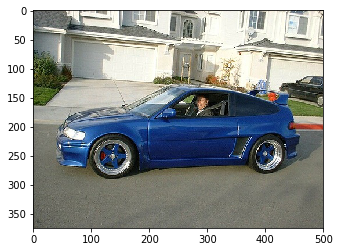

In [36]:
plot_image('/home/jxm/msfthack/Image/VOCdevkit/VOC2007/JPEGImages/000220.jpg')

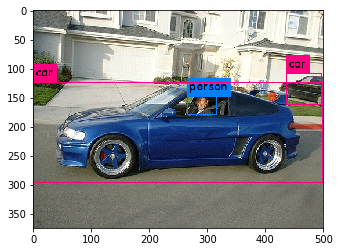

In [35]:
plot_image('predictions.png')